In [1]:
## %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import glob
import sys
import tensorflow as tf
import math
import datetime

In [2]:
# Helper functions, DO NOT modify this

def get_img_array(path):
    """
    Given path of image, returns it's numpy array
    """
    return scipy.misc.imread(path)

def get_files(folder):
    """
    Given path to folder, returns list of files in it
    """
    filenames = [file for file in glob.glob(folder+'*/*')]
    filenames.sort()
    return filenames

def get_label(filepath, label2id):
    """
    Files are assumed to be labeled as: /path/to/file/999_frog.png
    Returns label for a filepath
    """
    tokens = filepath.split('/')
    label = tokens[-1].split('_')[1][:-4]
    if label in label2id:
        return label2id[label]
    else:
        sys.exit("Invalid label: " + label)

In [3]:
# Functions to load data, DO NOT change these

def get_labels(folder, label2id):
    """
    Returns vector of labels extracted from filenames of all files in folder
    :param folder: path to data folder
    :param label2id: mapping of text labels to numeric ids. (Eg: automobile -> 0)
    """
    files = get_files(folder)
    y = []
    for f in files:
        y.append(get_label(f,label2id))
    return np.array(y)

def one_hot(y, num_classes=10):
    """
    Converts each label index in y to vector with one_hot encoding
    """
    y_one_hot = np.zeros((y.shape[0], num_classes))
    y_one_hot[y] = 1
    return y_one_hot.T

def get_label_mapping(label_file):
    """
    Returns mappings of label to index and index to label
    The input file has list of labels, each on a separate line.
    """
    with open(label_file, 'r') as f:
        id2label = f.readlines()
        id2label = [l.strip() for l in id2label]
    label2id = {}
    count = 0
    for label in id2label:
        label2id[label] = count
        count += 1
    return id2label, label2id

def get_images(folder):
    """
    returns numpy array of all samples in folder
    each column is a sample resized to 30x30 and flattened
    """
    files = get_files(folder)
    images = []
    count = 0
    
    for f in files:
        count += 1
        if count % 10000 == 0:
            print("Loaded {}/{}".format(count,len(files)))
        img_arr = get_img_array(f).astype(np.float)
#         img_arr = img_arr.flatten() / 255.0
        images.append(img_arr)
    # X = np.column_stack(images)
    X = np.stack(images, axis=0)
    return X

def get_train_data(data_root_path):
    """
    Return X and y
    """
    train_data_path = data_root_path + 'train'
    id2label, label2id = get_label_mapping(data_root_path+'labels.txt')
    print(label2id)
    X = get_images(train_data_path)
    y = get_labels(train_data_path, label2id)
    return X, y

def save_predictions(filename, y):
    """
    Dumps y into .npy file
    """
    np.save(filename, y)

In [4]:
# Load the data
data_root_path = 'cifar10-hw/'
X_train, y_train = get_train_data(data_root_path) # this may take a few minutes
X_test = get_images(data_root_path + 'test')
print('Data loading done')

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
Loaded 10000/50000
Loaded 20000/50000
Loaded 30000/50000
Loaded 40000/50000
Loaded 50000/50000
Loaded 10000/10000
Data loading done


In [5]:
print(X_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000,)


In [6]:
# Group's helper function
def split(X, y, val_size):
    '''
    split the data into training and validation set
    '''
    indices = np.random.permutation(X.shape[0])
    test_num = int(val_size * X.shape[0])
    return X[indices[test_num:]], X[indices[:test_num]], y[indices[test_num:]], y[indices[:test_num]]

In [7]:
X_trn, X_val, y_trn, y_val = split(X_train, y_train, val_size=0.1)
print(X_trn.shape)
print(X_val.shape)
print(y_trn.shape)
print(y_val.shape)

(45000, 32, 32, 3)
(5000, 32, 32, 3)
(45000,)
(5000,)


In [8]:
# GLobal value
H, W, T = 32, 32, 10 # height/width of images, number of classes of images

## Part 1

Using TensorFlow, implement a Convolutional Neural Network to classify CIFAR10
- At least two Convolutional Layers followed by normalization and pooling layers. 
- Activation function ReLU.
- Optimizer: Gradient Descent
- At least one fully connected layer followed by softmax transformation.

In [16]:
class CNN():
    def __init__(self, model_fn, trainer):
        tf.reset_default_graph()
        self.X = tf.placeholder(tf.float32, [None, H, W, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        self.is_training = tf.placeholder(tf.bool)
        logit, loss = model_fn(self.X, self.Y, self.is_training)
        # https://stackoverflow.com/a/43285333
        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(extra_update_ops):
            train_op = trainer.minimize(loss)
        # train_op = trainer.minimize(loss)
        # Accuracy
        correct = tf.equal(tf.argmax(logit, 1), self.Y)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        self.variables = {
            'train': [loss, correct, train_op],
            'validate': [loss, correct, accuracy]}
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def batch_gen(self, Xd, Yd, batch_size, shuffle=True):
        indicies = np.arange(Xd.shape[0])
        if shuffle:
            np.random.shuffle(indicies)
        for i in range(int(math.ceil(Xd.shape[0] / batch_size))):
            start_idx = (i * batch_size) % Xd.shape[0]
            idx = indicies[start_idx:start_idx + batch_size]
            yield Xd[idx, :], Yd[idx]

    def run(self, Xd, Yd, epochs, batch_size, print_every, plot_losses, status):
        iter_cnt = 0
        for e in range(epochs):
            correct = 0
            losses = []
            for Xb, Yb in self.batch_gen(Xd, Yd, batch_size, shuffle = True):
                feed_dict = {self.X: Xb, self.Y: Yb, self.is_training: status=='train'}
                loss, corr, _ = self.sess.run(self.variables[status], feed_dict = feed_dict)
                losses.append(loss)
                correct += np.sum(corr)
                if status == 'train' and iter_cnt % print_every == 0:
                    print("{} Iter {}: batch trn loss = {:.3f}, accuracy = {:.3f}".format(
                        datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                        iter_cnt,
                        loss,
                        np.mean(corr),
                    ))
                iter_cnt += 1
            epoch_loss = np.mean(losses)
            epoch_accuracy = correct / Xd.shape[0]
            print("Epoch {}: mean loss = {:.3f}, accuracy = {:.3f}".format(
                e, epoch_loss, epoch_accuracy))
            if plot_losses:
                plt.plot(losses)
                plt.grid(True)
                plt.title('Epoch {} Mean Loss'.format(e+1))
                plt.xlabel('minibatch number')
                plt.ylabel('minibatch mean loss')
                plt.show()
        return epoch_loss, epoch_accuracy

    def train(self, Xd, Yd, epochs=1, batch_size=50, print_every=100, plot_losses=False):
        return self.run(Xd, Yd, epochs, batch_size, print_every, plot_losses, status='train')
            
    def validate(self, Xd, Yd, epochs=1, batch_size=50, print_every=100, plot_losses=False):
        return self.run(Xd, Yd, epochs, batch_size, print_every, plot_losses, status='validate')
    
    def predict(self, Xd):
        feed_dict = {self.X: Xd, self.is_training: False}
        variables = [self.Y]
        Yp = self.sess.run(variables, feed_dict = feed_dict)
        return Yp

## Base
- trn: 0.753, val: 0.651 (20 epochs)
- trn: 0.801, val: 0.681    
- trn: 0.848, val: 0.682 (40 epochs)

4096
2017-10-25 13:03:11 Iter 0: batch trn loss = 4.514, accuracy = 0.120
2017-10-25 13:03:27 Iter 100: batch trn loss = 1.704, accuracy = 0.380
2017-10-25 13:03:44 Iter 200: batch trn loss = 1.720, accuracy = 0.420
2017-10-25 13:04:01 Iter 300: batch trn loss = 1.836, accuracy = 0.320
2017-10-25 13:04:18 Iter 400: batch trn loss = 2.099, accuracy = 0.340
2017-10-25 13:04:34 Iter 500: batch trn loss = 1.611, accuracy = 0.420
2017-10-25 13:04:51 Iter 600: batch trn loss = 1.543, accuracy = 0.460
2017-10-25 13:05:08 Iter 700: batch trn loss = 1.617, accuracy = 0.440
2017-10-25 13:05:24 Iter 800: batch trn loss = 1.648, accuracy = 0.480
Epoch 0: mean loss = 1.768, accuracy = 0.386


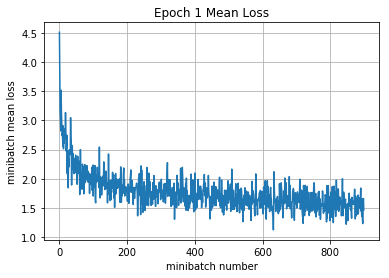

2017-10-25 13:05:41 Iter 900: batch trn loss = 1.566, accuracy = 0.380
2017-10-25 13:05:58 Iter 1000: batch trn loss = 1.276, accuracy = 0.560
2017-10-25 13:06:15 Iter 1100: batch trn loss = 1.384, accuracy = 0.480
2017-10-25 13:06:31 Iter 1200: batch trn loss = 1.547, accuracy = 0.440
2017-10-25 13:06:48 Iter 1300: batch trn loss = 1.254, accuracy = 0.580
2017-10-25 13:07:05 Iter 1400: batch trn loss = 1.417, accuracy = 0.440
2017-10-25 13:07:22 Iter 1500: batch trn loss = 1.435, accuracy = 0.520
2017-10-25 13:07:39 Iter 1600: batch trn loss = 1.447, accuracy = 0.520
2017-10-25 13:07:56 Iter 1700: batch trn loss = 1.572, accuracy = 0.540
Epoch 1: mean loss = 1.443, accuracy = 0.491


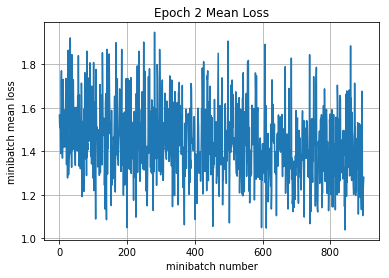

2017-10-25 13:08:13 Iter 1800: batch trn loss = 1.236, accuracy = 0.480
2017-10-25 13:08:30 Iter 1900: batch trn loss = 1.634, accuracy = 0.460
2017-10-25 13:08:46 Iter 2000: batch trn loss = 0.964, accuracy = 0.720
2017-10-25 13:09:03 Iter 2100: batch trn loss = 1.384, accuracy = 0.500
2017-10-25 13:09:21 Iter 2200: batch trn loss = 0.937, accuracy = 0.680
2017-10-25 13:09:38 Iter 2300: batch trn loss = 1.493, accuracy = 0.500
2017-10-25 13:09:55 Iter 2400: batch trn loss = 1.648, accuracy = 0.480
2017-10-25 13:10:11 Iter 2500: batch trn loss = 1.175, accuracy = 0.560
2017-10-25 13:10:28 Iter 2600: batch trn loss = 1.337, accuracy = 0.540
Epoch 2: mean loss = 1.316, accuracy = 0.537


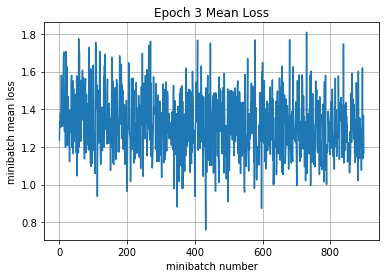

2017-10-25 13:10:45 Iter 2700: batch trn loss = 1.476, accuracy = 0.560
2017-10-25 13:11:01 Iter 2800: batch trn loss = 1.304, accuracy = 0.520
2017-10-25 13:11:18 Iter 2900: batch trn loss = 1.294, accuracy = 0.520
2017-10-25 13:11:35 Iter 3000: batch trn loss = 1.352, accuracy = 0.600
2017-10-25 13:11:51 Iter 3100: batch trn loss = 1.144, accuracy = 0.680
2017-10-25 13:12:25 Iter 3200: batch trn loss = 0.939, accuracy = 0.640
2017-10-25 13:12:44 Iter 3300: batch trn loss = 1.031, accuracy = 0.620
2017-10-25 13:13:01 Iter 3400: batch trn loss = 0.971, accuracy = 0.620
2017-10-25 13:13:18 Iter 3500: batch trn loss = 1.243, accuracy = 0.580
Epoch 3: mean loss = 1.228, accuracy = 0.570


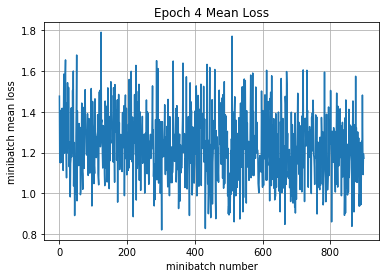

2017-10-25 13:13:34 Iter 3600: batch trn loss = 1.240, accuracy = 0.600
2017-10-25 13:13:51 Iter 3700: batch trn loss = 1.640, accuracy = 0.400
2017-10-25 13:14:08 Iter 3800: batch trn loss = 1.257, accuracy = 0.500
2017-10-25 13:14:24 Iter 3900: batch trn loss = 1.104, accuracy = 0.540
2017-10-25 13:14:41 Iter 4000: batch trn loss = 1.705, accuracy = 0.440
2017-10-25 13:14:58 Iter 4100: batch trn loss = 1.225, accuracy = 0.480
2017-10-25 13:15:14 Iter 4200: batch trn loss = 1.286, accuracy = 0.480
2017-10-25 13:15:31 Iter 4300: batch trn loss = 1.429, accuracy = 0.560
2017-10-25 13:15:48 Iter 4400: batch trn loss = 1.208, accuracy = 0.660
Epoch 4: mean loss = 1.159, accuracy = 0.595


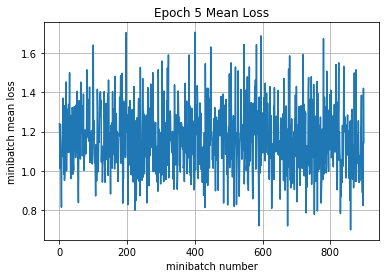

2017-10-25 13:16:04 Iter 4500: batch trn loss = 0.854, accuracy = 0.740
2017-10-25 13:16:21 Iter 4600: batch trn loss = 1.098, accuracy = 0.600
2017-10-25 13:16:38 Iter 4700: batch trn loss = 1.062, accuracy = 0.640
2017-10-25 13:16:54 Iter 4800: batch trn loss = 1.494, accuracy = 0.500
2017-10-25 13:17:11 Iter 4900: batch trn loss = 0.964, accuracy = 0.660
2017-10-25 13:17:28 Iter 5000: batch trn loss = 1.089, accuracy = 0.640
2017-10-25 13:17:45 Iter 5100: batch trn loss = 0.996, accuracy = 0.740
2017-10-25 13:18:01 Iter 5200: batch trn loss = 1.020, accuracy = 0.700
2017-10-25 13:18:19 Iter 5300: batch trn loss = 0.996, accuracy = 0.720
Epoch 5: mean loss = 1.105, accuracy = 0.616


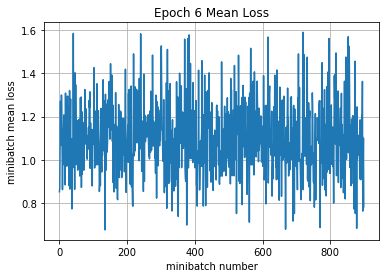

2017-10-25 13:18:36 Iter 5400: batch trn loss = 1.089, accuracy = 0.600
2017-10-25 13:18:53 Iter 5500: batch trn loss = 1.014, accuracy = 0.580
2017-10-25 13:19:10 Iter 5600: batch trn loss = 1.265, accuracy = 0.580
2017-10-25 13:19:27 Iter 5700: batch trn loss = 1.002, accuracy = 0.620
2017-10-25 13:19:45 Iter 5800: batch trn loss = 0.865, accuracy = 0.640
2017-10-25 13:20:02 Iter 5900: batch trn loss = 0.985, accuracy = 0.620
2017-10-25 13:20:19 Iter 6000: batch trn loss = 0.929, accuracy = 0.680
2017-10-25 13:20:35 Iter 6100: batch trn loss = 0.926, accuracy = 0.720
2017-10-25 13:20:52 Iter 6200: batch trn loss = 1.197, accuracy = 0.600
Epoch 6: mean loss = 1.053, accuracy = 0.634


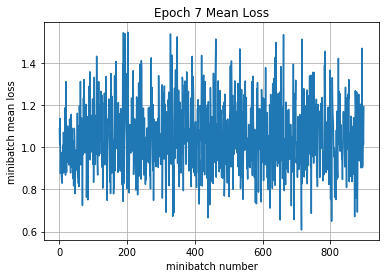

2017-10-25 13:21:09 Iter 6300: batch trn loss = 0.798, accuracy = 0.780
2017-10-25 13:21:26 Iter 6400: batch trn loss = 0.863, accuracy = 0.680
2017-10-25 13:21:43 Iter 6500: batch trn loss = 1.122, accuracy = 0.640
2017-10-25 13:21:59 Iter 6600: batch trn loss = 0.893, accuracy = 0.700
2017-10-25 13:22:16 Iter 6700: batch trn loss = 1.020, accuracy = 0.720
2017-10-25 13:22:34 Iter 6800: batch trn loss = 1.387, accuracy = 0.600
2017-10-25 13:22:52 Iter 6900: batch trn loss = 0.912, accuracy = 0.700
2017-10-25 13:23:10 Iter 7000: batch trn loss = 0.993, accuracy = 0.680
2017-10-25 13:23:29 Iter 7100: batch trn loss = 0.764, accuracy = 0.720
Epoch 7: mean loss = 1.011, accuracy = 0.651


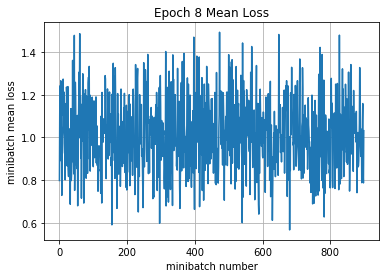

2017-10-25 13:23:46 Iter 7200: batch trn loss = 0.938, accuracy = 0.660
2017-10-25 13:24:04 Iter 7300: batch trn loss = 0.835, accuracy = 0.700
2017-10-25 13:24:22 Iter 7400: batch trn loss = 0.651, accuracy = 0.740
2017-10-25 13:24:39 Iter 7500: batch trn loss = 0.809, accuracy = 0.700
2017-10-25 13:24:56 Iter 7600: batch trn loss = 1.261, accuracy = 0.640
2017-10-25 13:25:13 Iter 7700: batch trn loss = 1.049, accuracy = 0.660
2017-10-25 13:25:29 Iter 7800: batch trn loss = 0.919, accuracy = 0.680
2017-10-25 13:25:46 Iter 7900: batch trn loss = 1.272, accuracy = 0.580
2017-10-25 13:26:02 Iter 8000: batch trn loss = 0.769, accuracy = 0.720
Epoch 8: mean loss = 0.975, accuracy = 0.663


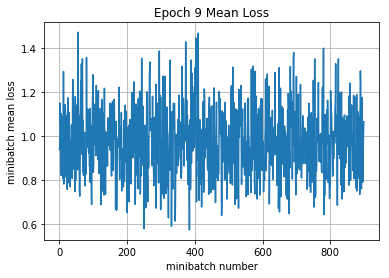

2017-10-25 13:26:19 Iter 8100: batch trn loss = 1.206, accuracy = 0.480
2017-10-25 13:26:36 Iter 8200: batch trn loss = 1.047, accuracy = 0.600
2017-10-25 13:26:52 Iter 8300: batch trn loss = 0.848, accuracy = 0.780
2017-10-25 13:27:09 Iter 8400: batch trn loss = 1.032, accuracy = 0.700
2017-10-25 13:27:25 Iter 8500: batch trn loss = 0.822, accuracy = 0.680
2017-10-25 13:27:42 Iter 8600: batch trn loss = 1.039, accuracy = 0.600
2017-10-25 13:27:58 Iter 8700: batch trn loss = 1.109, accuracy = 0.620
2017-10-25 13:28:15 Iter 8800: batch trn loss = 0.887, accuracy = 0.740
2017-10-25 13:28:31 Iter 8900: batch trn loss = 0.636, accuracy = 0.800
Epoch 9: mean loss = 0.937, accuracy = 0.676


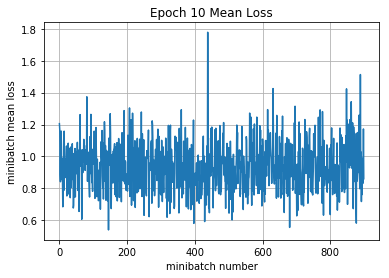

2017-10-25 13:28:48 Iter 9000: batch trn loss = 0.586, accuracy = 0.840
2017-10-25 13:29:08 Iter 9100: batch trn loss = 0.837, accuracy = 0.660
2017-10-25 13:29:24 Iter 9200: batch trn loss = 1.074, accuracy = 0.540
2017-10-25 13:29:41 Iter 9300: batch trn loss = 0.806, accuracy = 0.720
2017-10-25 13:29:58 Iter 9400: batch trn loss = 1.035, accuracy = 0.580
2017-10-25 13:30:14 Iter 9500: batch trn loss = 0.938, accuracy = 0.640
2017-10-25 13:30:31 Iter 9600: batch trn loss = 0.867, accuracy = 0.720
2017-10-25 13:30:47 Iter 9700: batch trn loss = 0.949, accuracy = 0.640
2017-10-25 13:31:05 Iter 9800: batch trn loss = 1.119, accuracy = 0.680
Epoch 10: mean loss = 0.913, accuracy = 0.686


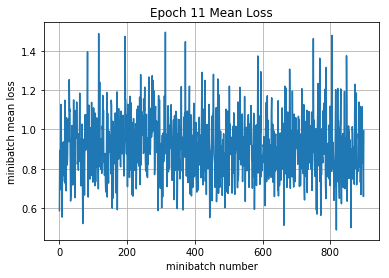

2017-10-25 13:31:24 Iter 9900: batch trn loss = 0.627, accuracy = 0.800
2017-10-25 13:31:42 Iter 10000: batch trn loss = 1.167, accuracy = 0.620
2017-10-25 13:31:58 Iter 10100: batch trn loss = 0.925, accuracy = 0.680
2017-10-25 13:32:14 Iter 10200: batch trn loss = 0.717, accuracy = 0.800
2017-10-25 13:32:31 Iter 10300: batch trn loss = 0.641, accuracy = 0.780
2017-10-25 13:32:47 Iter 10400: batch trn loss = 0.812, accuracy = 0.760
2017-10-25 13:33:04 Iter 10500: batch trn loss = 1.241, accuracy = 0.540
2017-10-25 13:33:21 Iter 10600: batch trn loss = 0.825, accuracy = 0.740
2017-10-25 13:33:38 Iter 10700: batch trn loss = 0.818, accuracy = 0.740
Epoch 11: mean loss = 0.884, accuracy = 0.695


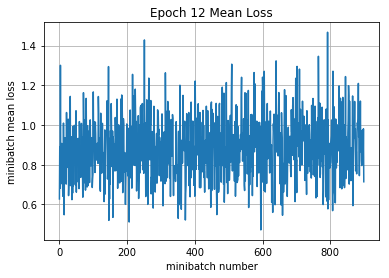

2017-10-25 13:33:55 Iter 10800: batch trn loss = 0.869, accuracy = 0.800
2017-10-25 13:34:12 Iter 10900: batch trn loss = 1.332, accuracy = 0.620
2017-10-25 13:34:29 Iter 11000: batch trn loss = 0.994, accuracy = 0.700
2017-10-25 13:34:45 Iter 11100: batch trn loss = 0.938, accuracy = 0.680
2017-10-25 13:35:01 Iter 11200: batch trn loss = 0.734, accuracy = 0.760
2017-10-25 13:35:18 Iter 11300: batch trn loss = 0.804, accuracy = 0.740
2017-10-25 13:35:34 Iter 11400: batch trn loss = 0.724, accuracy = 0.760
2017-10-25 13:35:51 Iter 11500: batch trn loss = 0.682, accuracy = 0.760
2017-10-25 13:36:07 Iter 11600: batch trn loss = 0.812, accuracy = 0.720
Epoch 12: mean loss = 0.859, accuracy = 0.703


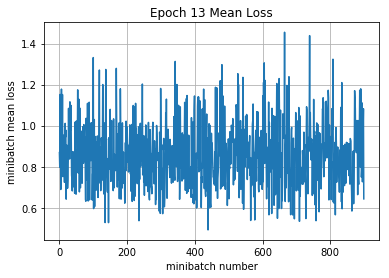

2017-10-25 13:36:24 Iter 11700: batch trn loss = 0.793, accuracy = 0.740
2017-10-25 13:36:40 Iter 11800: batch trn loss = 0.784, accuracy = 0.800
2017-10-25 13:36:57 Iter 11900: batch trn loss = 0.897, accuracy = 0.740
2017-10-25 13:37:13 Iter 12000: batch trn loss = 1.041, accuracy = 0.640
2017-10-25 13:37:29 Iter 12100: batch trn loss = 0.596, accuracy = 0.820
2017-10-25 13:37:46 Iter 12200: batch trn loss = 0.936, accuracy = 0.660
2017-10-25 13:38:02 Iter 12300: batch trn loss = 0.838, accuracy = 0.740
2017-10-25 13:38:19 Iter 12400: batch trn loss = 0.921, accuracy = 0.620
2017-10-25 13:38:35 Iter 12500: batch trn loss = 0.855, accuracy = 0.780
Epoch 13: mean loss = 0.837, accuracy = 0.712


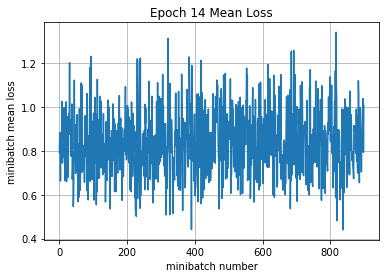

2017-10-25 13:38:51 Iter 12600: batch trn loss = 0.691, accuracy = 0.760
2017-10-25 13:39:09 Iter 12700: batch trn loss = 0.606, accuracy = 0.800
2017-10-25 13:39:26 Iter 12800: batch trn loss = 0.787, accuracy = 0.740
2017-10-25 13:39:43 Iter 12900: batch trn loss = 0.898, accuracy = 0.680
2017-10-25 13:39:59 Iter 13000: batch trn loss = 1.051, accuracy = 0.660
2017-10-25 13:40:16 Iter 13100: batch trn loss = 0.827, accuracy = 0.760
2017-10-25 13:40:32 Iter 13200: batch trn loss = 0.973, accuracy = 0.680
2017-10-25 13:40:48 Iter 13300: batch trn loss = 0.910, accuracy = 0.640
2017-10-25 13:41:05 Iter 13400: batch trn loss = 1.071, accuracy = 0.620
Epoch 14: mean loss = 0.816, accuracy = 0.718


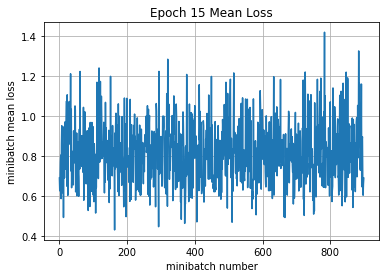

2017-10-25 13:41:22 Iter 13500: batch trn loss = 0.648, accuracy = 0.780
2017-10-25 13:41:38 Iter 13600: batch trn loss = 0.978, accuracy = 0.680
2017-10-25 13:41:55 Iter 13700: batch trn loss = 0.529, accuracy = 0.820
2017-10-25 13:42:12 Iter 13800: batch trn loss = 0.994, accuracy = 0.700
2017-10-25 13:42:28 Iter 13900: batch trn loss = 0.943, accuracy = 0.720
2017-10-25 13:42:45 Iter 14000: batch trn loss = 1.083, accuracy = 0.580
2017-10-25 13:43:02 Iter 14100: batch trn loss = 0.533, accuracy = 0.800
2017-10-25 13:43:21 Iter 14200: batch trn loss = 0.884, accuracy = 0.700
2017-10-25 13:43:38 Iter 14300: batch trn loss = 0.997, accuracy = 0.560
Epoch 15: mean loss = 0.793, accuracy = 0.728


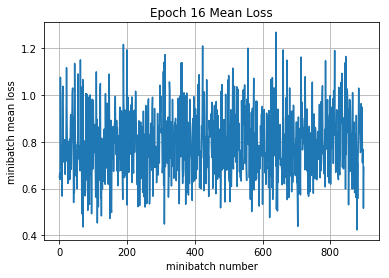

2017-10-25 13:43:54 Iter 14400: batch trn loss = 0.583, accuracy = 0.800
2017-10-25 13:44:11 Iter 14500: batch trn loss = 0.753, accuracy = 0.680
2017-10-25 13:44:27 Iter 14600: batch trn loss = 0.799, accuracy = 0.760
2017-10-25 13:44:44 Iter 14700: batch trn loss = 1.123, accuracy = 0.640
2017-10-25 13:45:00 Iter 14800: batch trn loss = 0.896, accuracy = 0.720
2017-10-25 13:45:17 Iter 14900: batch trn loss = 0.674, accuracy = 0.800
2017-10-25 13:45:33 Iter 15000: batch trn loss = 0.627, accuracy = 0.760
2017-10-25 13:45:49 Iter 15100: batch trn loss = 0.542, accuracy = 0.780
2017-10-25 13:46:06 Iter 15200: batch trn loss = 0.546, accuracy = 0.840
Epoch 16: mean loss = 0.774, accuracy = 0.733


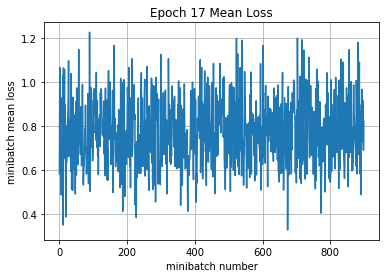

2017-10-25 13:46:23 Iter 15300: batch trn loss = 0.749, accuracy = 0.760
2017-10-25 13:46:40 Iter 15400: batch trn loss = 0.544, accuracy = 0.820
2017-10-25 13:46:58 Iter 15500: batch trn loss = 0.854, accuracy = 0.700
2017-10-25 13:47:15 Iter 15600: batch trn loss = 0.843, accuracy = 0.740
2017-10-25 13:47:31 Iter 15700: batch trn loss = 0.846, accuracy = 0.700
2017-10-25 13:47:48 Iter 15800: batch trn loss = 0.831, accuracy = 0.740
2017-10-25 13:48:04 Iter 15900: batch trn loss = 0.754, accuracy = 0.740
2017-10-25 13:48:21 Iter 16000: batch trn loss = 0.738, accuracy = 0.720
2017-10-25 13:48:37 Iter 16100: batch trn loss = 0.774, accuracy = 0.680
Epoch 17: mean loss = 0.755, accuracy = 0.742


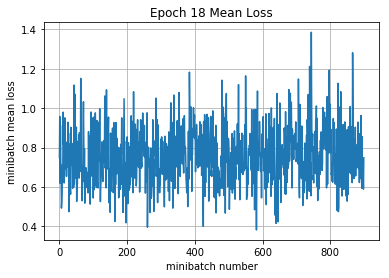

2017-10-25 13:48:54 Iter 16200: batch trn loss = 0.532, accuracy = 0.840
2017-10-25 13:49:11 Iter 16300: batch trn loss = 0.972, accuracy = 0.660
2017-10-25 13:49:27 Iter 16400: batch trn loss = 0.609, accuracy = 0.820
2017-10-25 13:49:44 Iter 16500: batch trn loss = 1.041, accuracy = 0.660
2017-10-25 13:50:01 Iter 16600: batch trn loss = 1.132, accuracy = 0.600
2017-10-25 13:50:17 Iter 16700: batch trn loss = 0.551, accuracy = 0.800
2017-10-25 13:50:34 Iter 16800: batch trn loss = 0.887, accuracy = 0.700
2017-10-25 13:50:50 Iter 16900: batch trn loss = 0.499, accuracy = 0.800
2017-10-25 13:51:07 Iter 17000: batch trn loss = 0.718, accuracy = 0.740
Epoch 18: mean loss = 0.736, accuracy = 0.749


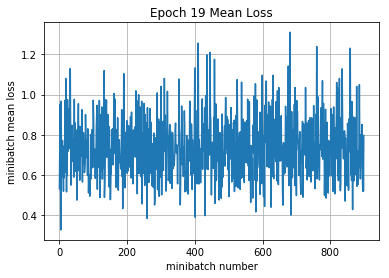

2017-10-25 13:51:24 Iter 17100: batch trn loss = 0.703, accuracy = 0.780
2017-10-25 13:51:40 Iter 17200: batch trn loss = 0.470, accuracy = 0.880
2017-10-25 13:51:57 Iter 17300: batch trn loss = 0.748, accuracy = 0.760
2017-10-25 13:52:13 Iter 17400: batch trn loss = 0.744, accuracy = 0.760
2017-10-25 13:52:30 Iter 17500: batch trn loss = 0.694, accuracy = 0.760
2017-10-25 13:52:47 Iter 17600: batch trn loss = 0.493, accuracy = 0.820
2017-10-25 13:53:03 Iter 17700: batch trn loss = 0.632, accuracy = 0.780
2017-10-25 13:53:20 Iter 17800: batch trn loss = 0.887, accuracy = 0.680
2017-10-25 13:53:37 Iter 17900: batch trn loss = 0.698, accuracy = 0.760
Epoch 19: mean loss = 0.718, accuracy = 0.753


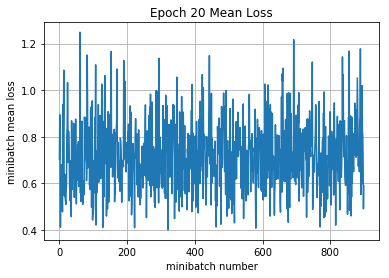

Epoch 0: mean loss = 1.066, accuracy = 0.651


In [50]:
# trn: 0.753, val: 0.651
def model_fn(layer_input, labels, is_training):
    F1 = 32
    layer_conv1 = tf.layers.conv2d(inputs=layer_input, filters=F1, kernel_size=[5, 5], padding='same', activation=tf.nn.relu)
    layer_bn1 = tf.layers.batch_normalization(inputs=layer_conv1, training=is_training)
    layer_pool1 = tf.layers.max_pooling2d(inputs=layer_conv1, pool_size=[2, 2], strides=2)
    F2 = 64
    layer_conv2 = tf.layers.conv2d(inputs=layer_pool1, filters=F2, kernel_size=[5, 5], padding='same', activation=tf.nn.relu)
    layer_bn2 = tf.layers.batch_normalization(inputs=layer_conv2, training=is_training)
    layer_pool2 = tf.layers.max_pooling2d(inputs=layer_bn2, pool_size=[2, 2], strides=2)
    flat_size = int(H / 4 * W / 4 * F2)
    print(flat_size)
    layer_pool2_flat = tf.reshape(layer_pool2, [-1, flat_size])
    layer_dense = tf.layers.dense(inputs=layer_pool2_flat, units=1024)
    # layer_dropout = tf.layers.dropout(inputs=layer_dense, rate=0.4)
    layer_logit = tf.layers.dense(inputs=layer_dense, units=T)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int64), depth=10)
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=layer_logit)
    return layer_logit, loss

trainer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
cnn = CNN(model_fn, trainer)
print('train')
cnn.train(X_trn, y_trn, epochs=20, batch_size=50, print_every=100, plot_losses=True)
print('validation')
cnn.validate(X_val, y_val, epochs=1, batch_size=50)

train
2017-10-25 13:56:13 Iter 0: batch trn loss = 0.745, accuracy = 0.760
2017-10-25 13:56:29 Iter 100: batch trn loss = 0.769, accuracy = 0.740
2017-10-25 13:56:46 Iter 200: batch trn loss = 0.802, accuracy = 0.740
2017-10-25 13:57:02 Iter 300: batch trn loss = 0.898, accuracy = 0.720
2017-10-25 13:57:19 Iter 400: batch trn loss = 0.695, accuracy = 0.780
2017-10-25 13:57:36 Iter 500: batch trn loss = 0.775, accuracy = 0.720
2017-10-25 13:57:52 Iter 600: batch trn loss = 0.763, accuracy = 0.680
2017-10-25 13:58:09 Iter 700: batch trn loss = 0.627, accuracy = 0.760
2017-10-25 13:58:25 Iter 800: batch trn loss = 0.535, accuracy = 0.780
Epoch 0: mean loss = 0.703, accuracy = 0.759


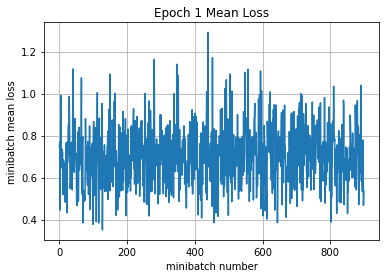

2017-10-25 13:58:42 Iter 900: batch trn loss = 0.666, accuracy = 0.740
2017-10-25 13:58:59 Iter 1000: batch trn loss = 0.447, accuracy = 0.860
2017-10-25 13:59:15 Iter 1100: batch trn loss = 0.681, accuracy = 0.840
2017-10-25 13:59:32 Iter 1200: batch trn loss = 0.917, accuracy = 0.660
2017-10-25 13:59:49 Iter 1300: batch trn loss = 0.596, accuracy = 0.780
2017-10-25 14:00:06 Iter 1400: batch trn loss = 0.517, accuracy = 0.760
2017-10-25 14:00:23 Iter 1500: batch trn loss = 0.573, accuracy = 0.740
2017-10-25 14:00:40 Iter 1600: batch trn loss = 0.870, accuracy = 0.760
2017-10-25 14:00:58 Iter 1700: batch trn loss = 0.548, accuracy = 0.800
Epoch 1: mean loss = 0.686, accuracy = 0.765


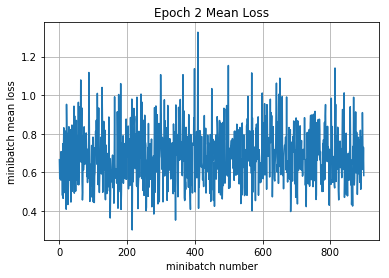

2017-10-25 14:01:17 Iter 1800: batch trn loss = 0.730, accuracy = 0.780
2017-10-25 14:01:34 Iter 1900: batch trn loss = 0.794, accuracy = 0.760
2017-10-25 14:01:51 Iter 2000: batch trn loss = 0.596, accuracy = 0.760
2017-10-25 14:02:07 Iter 2100: batch trn loss = 0.800, accuracy = 0.820
2017-10-25 14:02:24 Iter 2200: batch trn loss = 0.651, accuracy = 0.760
2017-10-25 14:02:40 Iter 2300: batch trn loss = 0.494, accuracy = 0.800
2017-10-25 14:02:57 Iter 2400: batch trn loss = 0.461, accuracy = 0.840
2017-10-25 14:03:13 Iter 2500: batch trn loss = 0.999, accuracy = 0.620
2017-10-25 14:03:30 Iter 2600: batch trn loss = 0.731, accuracy = 0.800
Epoch 2: mean loss = 0.669, accuracy = 0.771


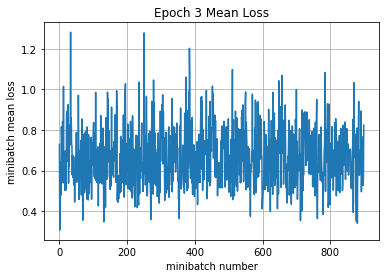

2017-10-25 14:03:47 Iter 2700: batch trn loss = 0.574, accuracy = 0.760
2017-10-25 14:04:03 Iter 2800: batch trn loss = 0.594, accuracy = 0.780
2017-10-25 14:04:20 Iter 2900: batch trn loss = 0.740, accuracy = 0.740
2017-10-25 14:04:36 Iter 3000: batch trn loss = 0.580, accuracy = 0.740
2017-10-25 14:04:53 Iter 3100: batch trn loss = 0.626, accuracy = 0.820
2017-10-25 14:05:10 Iter 3200: batch trn loss = 0.692, accuracy = 0.740
2017-10-25 14:05:26 Iter 3300: batch trn loss = 0.675, accuracy = 0.720
2017-10-25 14:05:43 Iter 3400: batch trn loss = 0.615, accuracy = 0.740
2017-10-25 14:06:00 Iter 3500: batch trn loss = 0.454, accuracy = 0.860
Epoch 3: mean loss = 0.656, accuracy = 0.775


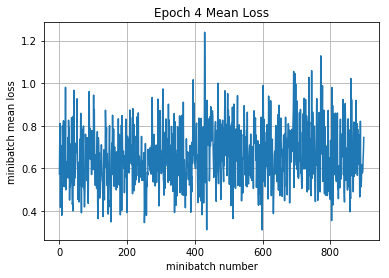

2017-10-25 14:06:16 Iter 3600: batch trn loss = 0.530, accuracy = 0.840
2017-10-25 14:06:33 Iter 3700: batch trn loss = 0.522, accuracy = 0.840
2017-10-25 14:06:49 Iter 3800: batch trn loss = 0.665, accuracy = 0.800
2017-10-25 14:07:06 Iter 3900: batch trn loss = 0.653, accuracy = 0.780
2017-10-25 14:07:23 Iter 4000: batch trn loss = 0.779, accuracy = 0.760
2017-10-25 14:07:39 Iter 4100: batch trn loss = 0.571, accuracy = 0.880
2017-10-25 14:07:56 Iter 4200: batch trn loss = 0.694, accuracy = 0.800
2017-10-25 14:08:12 Iter 4300: batch trn loss = 0.605, accuracy = 0.820
2017-10-25 14:08:29 Iter 4400: batch trn loss = 0.652, accuracy = 0.800
Epoch 4: mean loss = 0.638, accuracy = 0.782


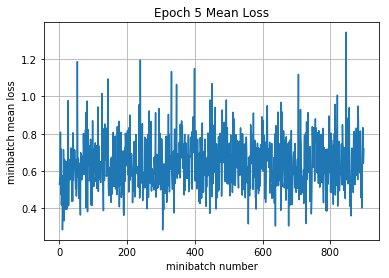

2017-10-25 14:08:45 Iter 4500: batch trn loss = 0.441, accuracy = 0.840
2017-10-25 14:09:02 Iter 4600: batch trn loss = 0.496, accuracy = 0.800
2017-10-25 14:09:18 Iter 4700: batch trn loss = 0.764, accuracy = 0.700
2017-10-25 14:09:35 Iter 4800: batch trn loss = 0.572, accuracy = 0.800
2017-10-25 14:09:54 Iter 4900: batch trn loss = 0.488, accuracy = 0.800
2017-10-25 14:10:16 Iter 5000: batch trn loss = 1.009, accuracy = 0.620
2017-10-25 14:10:33 Iter 5100: batch trn loss = 0.666, accuracy = 0.740
2017-10-25 14:10:54 Iter 5200: batch trn loss = 0.937, accuracy = 0.720
2017-10-25 14:11:13 Iter 5300: batch trn loss = 0.599, accuracy = 0.820
Epoch 5: mean loss = 0.622, accuracy = 0.786


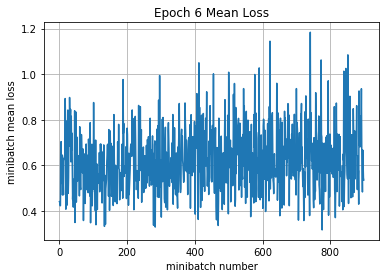

2017-10-25 14:11:31 Iter 5400: batch trn loss = 0.450, accuracy = 0.860
2017-10-25 14:11:48 Iter 5500: batch trn loss = 0.611, accuracy = 0.820
2017-10-25 14:12:05 Iter 5600: batch trn loss = 0.465, accuracy = 0.880
2017-10-25 14:12:21 Iter 5700: batch trn loss = 0.735, accuracy = 0.660
2017-10-25 14:12:38 Iter 5800: batch trn loss = 0.772, accuracy = 0.700
2017-10-25 14:12:55 Iter 5900: batch trn loss = 0.607, accuracy = 0.780
2017-10-25 14:13:12 Iter 6000: batch trn loss = 0.687, accuracy = 0.720
2017-10-25 14:13:28 Iter 6100: batch trn loss = 0.582, accuracy = 0.740
2017-10-25 14:13:45 Iter 6200: batch trn loss = 0.738, accuracy = 0.740
Epoch 6: mean loss = 0.611, accuracy = 0.792


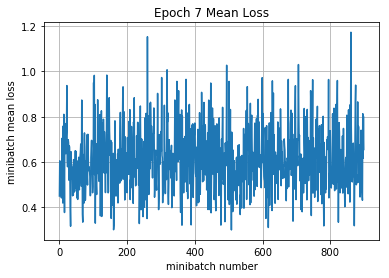

2017-10-25 14:14:02 Iter 6300: batch trn loss = 0.612, accuracy = 0.840
2017-10-25 14:14:19 Iter 6400: batch trn loss = 0.409, accuracy = 0.860
2017-10-25 14:14:35 Iter 6500: batch trn loss = 0.375, accuracy = 0.900
2017-10-25 14:14:52 Iter 6600: batch trn loss = 0.508, accuracy = 0.860
2017-10-25 14:15:08 Iter 6700: batch trn loss = 0.427, accuracy = 0.840
2017-10-25 14:15:25 Iter 6800: batch trn loss = 0.602, accuracy = 0.780
2017-10-25 14:15:42 Iter 6900: batch trn loss = 0.448, accuracy = 0.880
2017-10-25 14:15:58 Iter 7000: batch trn loss = 1.039, accuracy = 0.580
2017-10-25 14:16:15 Iter 7100: batch trn loss = 0.647, accuracy = 0.840
Epoch 7: mean loss = 0.595, accuracy = 0.796


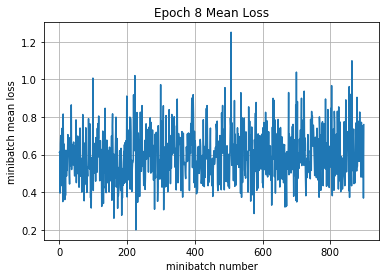

2017-10-25 14:16:31 Iter 7200: batch trn loss = 0.802, accuracy = 0.740
2017-10-25 14:16:48 Iter 7300: batch trn loss = 0.547, accuracy = 0.880
2017-10-25 14:17:04 Iter 7400: batch trn loss = 0.471, accuracy = 0.840
2017-10-25 14:17:21 Iter 7500: batch trn loss = 0.494, accuracy = 0.840
2017-10-25 14:17:37 Iter 7600: batch trn loss = 0.803, accuracy = 0.740
2017-10-25 14:17:54 Iter 7700: batch trn loss = 0.405, accuracy = 0.840
2017-10-25 14:18:11 Iter 7800: batch trn loss = 0.622, accuracy = 0.800
2017-10-25 14:18:27 Iter 7900: batch trn loss = 0.534, accuracy = 0.760
2017-10-25 14:18:44 Iter 8000: batch trn loss = 0.554, accuracy = 0.780
Epoch 8: mean loss = 0.579, accuracy = 0.804


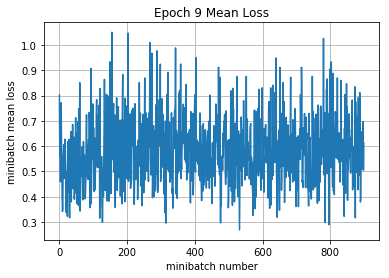

2017-10-25 14:19:00 Iter 8100: batch trn loss = 0.462, accuracy = 0.880
2017-10-25 14:19:17 Iter 8200: batch trn loss = 0.550, accuracy = 0.800
2017-10-25 14:19:33 Iter 8300: batch trn loss = 0.469, accuracy = 0.840
2017-10-25 14:19:50 Iter 8400: batch trn loss = 0.545, accuracy = 0.820
2017-10-25 14:20:06 Iter 8500: batch trn loss = 0.496, accuracy = 0.820
2017-10-25 14:20:23 Iter 8600: batch trn loss = 0.664, accuracy = 0.780
2017-10-25 14:20:39 Iter 8700: batch trn loss = 0.443, accuracy = 0.880
2017-10-25 14:20:55 Iter 8800: batch trn loss = 0.597, accuracy = 0.840
2017-10-25 14:21:12 Iter 8900: batch trn loss = 0.557, accuracy = 0.760
Epoch 9: mean loss = 0.566, accuracy = 0.805


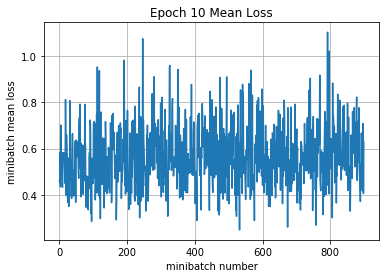

validation
Epoch 0: mean loss = 1.021, accuracy = 0.681


In [51]:
# continue on training for 10 more epochs to see if there will be any increase
# trn: 0.801, val: 0.681
print('train')
cnn.train(X_trn, y_trn, epochs=10, batch_size=50, print_every=100, plot_losses=True)
print('validation')
cnn.validate(X_val, y_val, epochs=1, batch_size=50)

train
2017-10-25 14:21:59 Iter 0: batch trn loss = 0.545, accuracy = 0.820
2017-10-25 14:22:16 Iter 100: batch trn loss = 0.544, accuracy = 0.820
2017-10-25 14:22:32 Iter 200: batch trn loss = 0.545, accuracy = 0.760
2017-10-25 14:22:49 Iter 300: batch trn loss = 0.378, accuracy = 0.840
2017-10-25 14:23:05 Iter 400: batch trn loss = 0.680, accuracy = 0.760
2017-10-25 14:23:22 Iter 500: batch trn loss = 0.513, accuracy = 0.840
2017-10-25 14:23:38 Iter 600: batch trn loss = 0.530, accuracy = 0.840
2017-10-25 14:23:54 Iter 700: batch trn loss = 0.636, accuracy = 0.740
2017-10-25 14:24:11 Iter 800: batch trn loss = 0.630, accuracy = 0.780
Epoch 0: mean loss = 0.555, accuracy = 0.811


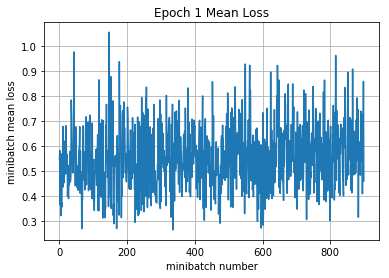

2017-10-25 14:24:28 Iter 900: batch trn loss = 0.513, accuracy = 0.820
2017-10-25 14:24:44 Iter 1000: batch trn loss = 0.664, accuracy = 0.760
2017-10-25 14:25:01 Iter 1100: batch trn loss = 0.585, accuracy = 0.740
2017-10-25 14:25:18 Iter 1200: batch trn loss = 0.355, accuracy = 0.880
2017-10-25 14:25:34 Iter 1300: batch trn loss = 0.710, accuracy = 0.840
2017-10-25 14:25:51 Iter 1400: batch trn loss = 0.357, accuracy = 0.880
2017-10-25 14:26:08 Iter 1500: batch trn loss = 0.571, accuracy = 0.840
2017-10-25 14:26:25 Iter 1600: batch trn loss = 0.421, accuracy = 0.840
2017-10-25 14:26:41 Iter 1700: batch trn loss = 0.854, accuracy = 0.680
Epoch 1: mean loss = 0.540, accuracy = 0.816


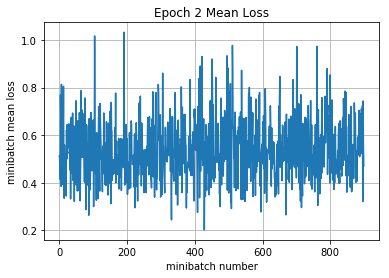

2017-10-25 14:26:58 Iter 1800: batch trn loss = 0.453, accuracy = 0.820
2017-10-25 14:27:15 Iter 1900: batch trn loss = 0.501, accuracy = 0.800
2017-10-25 14:27:31 Iter 2000: batch trn loss = 0.663, accuracy = 0.680
2017-10-25 14:27:48 Iter 2100: batch trn loss = 0.596, accuracy = 0.780
2017-10-25 14:28:04 Iter 2200: batch trn loss = 0.520, accuracy = 0.860
2017-10-25 14:28:21 Iter 2300: batch trn loss = 0.307, accuracy = 0.880
2017-10-25 14:28:37 Iter 2400: batch trn loss = 0.501, accuracy = 0.840
2017-10-25 14:28:54 Iter 2500: batch trn loss = 0.436, accuracy = 0.920
2017-10-25 14:29:11 Iter 2600: batch trn loss = 0.947, accuracy = 0.620
Epoch 2: mean loss = 0.528, accuracy = 0.819


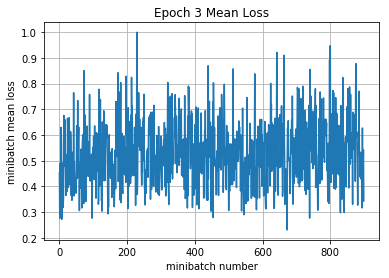

2017-10-25 14:29:28 Iter 2700: batch trn loss = 0.531, accuracy = 0.820
2017-10-25 14:29:44 Iter 2800: batch trn loss = 0.523, accuracy = 0.900
2017-10-25 14:30:01 Iter 2900: batch trn loss = 0.622, accuracy = 0.800
2017-10-25 14:30:17 Iter 3000: batch trn loss = 0.480, accuracy = 0.800
2017-10-25 14:30:34 Iter 3100: batch trn loss = 0.610, accuracy = 0.780
2017-10-25 14:30:50 Iter 3200: batch trn loss = 0.594, accuracy = 0.760
2017-10-25 14:31:08 Iter 3300: batch trn loss = 0.451, accuracy = 0.820
2017-10-25 14:31:26 Iter 3400: batch trn loss = 0.659, accuracy = 0.780
2017-10-25 14:31:43 Iter 3500: batch trn loss = 0.526, accuracy = 0.900
Epoch 3: mean loss = 0.515, accuracy = 0.825


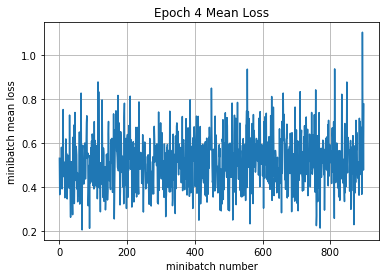

2017-10-25 14:32:00 Iter 3600: batch trn loss = 0.478, accuracy = 0.840
2017-10-25 14:32:16 Iter 3700: batch trn loss = 0.616, accuracy = 0.780
2017-10-25 14:32:32 Iter 3800: batch trn loss = 0.365, accuracy = 0.900
2017-10-25 14:32:49 Iter 3900: batch trn loss = 0.334, accuracy = 0.860
2017-10-25 14:33:06 Iter 4000: batch trn loss = 0.527, accuracy = 0.820
2017-10-25 14:33:23 Iter 4100: batch trn loss = 0.556, accuracy = 0.800
2017-10-25 14:33:39 Iter 4200: batch trn loss = 0.591, accuracy = 0.780
2017-10-25 14:33:56 Iter 4300: batch trn loss = 0.478, accuracy = 0.820
2017-10-25 14:34:12 Iter 4400: batch trn loss = 0.367, accuracy = 0.900
Epoch 4: mean loss = 0.502, accuracy = 0.828


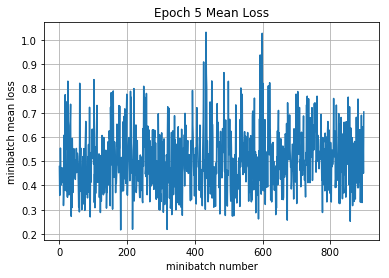

2017-10-25 14:34:29 Iter 4500: batch trn loss = 0.671, accuracy = 0.720
2017-10-25 14:34:46 Iter 4600: batch trn loss = 0.353, accuracy = 0.920
2017-10-25 14:35:02 Iter 4700: batch trn loss = 0.468, accuracy = 0.840
2017-10-25 14:35:19 Iter 4800: batch trn loss = 0.472, accuracy = 0.860
2017-10-25 14:35:35 Iter 4900: batch trn loss = 0.523, accuracy = 0.860
2017-10-25 14:35:51 Iter 5000: batch trn loss = 0.607, accuracy = 0.800
2017-10-25 14:36:08 Iter 5100: batch trn loss = 0.381, accuracy = 0.840
2017-10-25 14:36:24 Iter 5200: batch trn loss = 0.474, accuracy = 0.820
2017-10-25 14:36:42 Iter 5300: batch trn loss = 0.403, accuracy = 0.880
Epoch 5: mean loss = 0.490, accuracy = 0.834


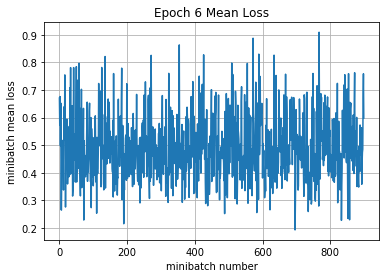

2017-10-25 14:36:59 Iter 5400: batch trn loss = 0.497, accuracy = 0.860
2017-10-25 14:37:16 Iter 5500: batch trn loss = 0.422, accuracy = 0.860
2017-10-25 14:37:33 Iter 5600: batch trn loss = 0.436, accuracy = 0.820
2017-10-25 14:37:50 Iter 5700: batch trn loss = 0.691, accuracy = 0.800
2017-10-25 14:38:07 Iter 5800: batch trn loss = 0.430, accuracy = 0.840
2017-10-25 14:38:24 Iter 5900: batch trn loss = 0.531, accuracy = 0.820
2017-10-25 14:38:40 Iter 6000: batch trn loss = 0.445, accuracy = 0.900
2017-10-25 14:38:56 Iter 6100: batch trn loss = 0.532, accuracy = 0.780
2017-10-25 14:39:13 Iter 6200: batch trn loss = 0.518, accuracy = 0.760
Epoch 6: mean loss = 0.479, accuracy = 0.837


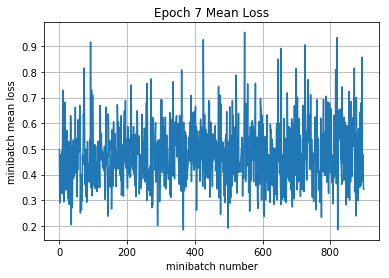

2017-10-25 14:39:30 Iter 6300: batch trn loss = 0.452, accuracy = 0.840
2017-10-25 14:39:46 Iter 6400: batch trn loss = 0.360, accuracy = 0.900
2017-10-25 14:40:03 Iter 6500: batch trn loss = 0.475, accuracy = 0.880
2017-10-25 14:40:22 Iter 6600: batch trn loss = 0.452, accuracy = 0.820
2017-10-25 14:40:38 Iter 6700: batch trn loss = 0.389, accuracy = 0.840
2017-10-25 14:40:56 Iter 6800: batch trn loss = 0.418, accuracy = 0.880
2017-10-25 14:41:13 Iter 6900: batch trn loss = 0.490, accuracy = 0.820
2017-10-25 14:41:31 Iter 7000: batch trn loss = 0.781, accuracy = 0.760
2017-10-25 14:41:47 Iter 7100: batch trn loss = 0.644, accuracy = 0.800
Epoch 7: mean loss = 0.466, accuracy = 0.842


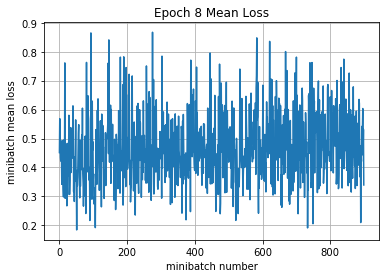

2017-10-25 14:42:04 Iter 7200: batch trn loss = 0.368, accuracy = 0.860
2017-10-25 14:42:20 Iter 7300: batch trn loss = 0.427, accuracy = 0.820
2017-10-25 14:42:36 Iter 7400: batch trn loss = 0.658, accuracy = 0.860
2017-10-25 14:42:53 Iter 7500: batch trn loss = 0.560, accuracy = 0.800
2017-10-25 14:43:10 Iter 7600: batch trn loss = 0.625, accuracy = 0.800
2017-10-25 14:43:26 Iter 7700: batch trn loss = 0.402, accuracy = 0.840
2017-10-25 14:43:42 Iter 7800: batch trn loss = 0.453, accuracy = 0.820
2017-10-25 14:43:59 Iter 7900: batch trn loss = 0.325, accuracy = 0.880
2017-10-25 14:44:16 Iter 8000: batch trn loss = 0.437, accuracy = 0.800
Epoch 8: mean loss = 0.455, accuracy = 0.846


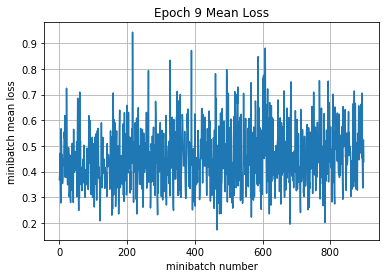

2017-10-25 14:44:34 Iter 8100: batch trn loss = 0.386, accuracy = 0.880
2017-10-25 14:44:51 Iter 8200: batch trn loss = 0.468, accuracy = 0.840
2017-10-25 14:45:08 Iter 8300: batch trn loss = 0.373, accuracy = 0.840
2017-10-25 14:45:25 Iter 8400: batch trn loss = 0.349, accuracy = 0.860
2017-10-25 14:45:43 Iter 8500: batch trn loss = 0.324, accuracy = 0.860
2017-10-25 14:46:00 Iter 8600: batch trn loss = 0.418, accuracy = 0.880
2017-10-25 14:46:17 Iter 8700: batch trn loss = 0.365, accuracy = 0.900
2017-10-25 14:46:35 Iter 8800: batch trn loss = 0.482, accuracy = 0.860
2017-10-25 14:46:53 Iter 8900: batch trn loss = 0.568, accuracy = 0.740
Epoch 9: mean loss = 0.446, accuracy = 0.848


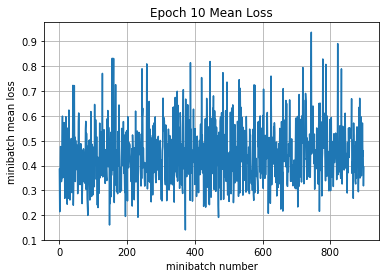

validation
Epoch 0: mean loss = 1.053, accuracy = 0.682


In [52]:
# continue on training for 10 more epochs to see if there will be any increase
# from 30 to 40, no significant increase
# trn: 0.848, val: 0.682
print('train')
cnn.train(X_trn, y_trn, epochs=10, batch_size=50, print_every=100, plot_losses=True)
print('validation')
cnn.validate(X_val, y_val, epochs=1, batch_size=50)

## use [3, 3] kernel_size, worse
trn: 0.728, val: 0.635 (20 epochs)

4096
train
2017-10-25 14:49:22 Iter 0: batch trn loss = 4.847, accuracy = 0.080
2017-10-25 14:49:34 Iter 100: batch trn loss = 2.310, accuracy = 0.280
2017-10-25 14:49:46 Iter 200: batch trn loss = 1.758, accuracy = 0.460
2017-10-25 14:49:57 Iter 300: batch trn loss = 1.672, accuracy = 0.460
2017-10-25 14:50:09 Iter 400: batch trn loss = 1.686, accuracy = 0.360
2017-10-25 14:50:20 Iter 500: batch trn loss = 1.589, accuracy = 0.360
2017-10-25 14:50:32 Iter 600: batch trn loss = 1.345, accuracy = 0.560
2017-10-25 14:50:43 Iter 700: batch trn loss = 1.530, accuracy = 0.440
2017-10-25 14:50:55 Iter 800: batch trn loss = 1.302, accuracy = 0.520
Epoch 0: mean loss = 1.791, accuracy = 0.394


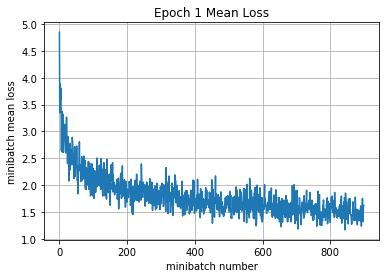

2017-10-25 14:51:06 Iter 900: batch trn loss = 1.588, accuracy = 0.460
2017-10-25 14:51:18 Iter 1000: batch trn loss = 1.344, accuracy = 0.500
2017-10-25 14:51:29 Iter 1100: batch trn loss = 1.379, accuracy = 0.500
2017-10-25 14:51:41 Iter 1200: batch trn loss = 1.157, accuracy = 0.520
2017-10-25 14:51:52 Iter 1300: batch trn loss = 1.624, accuracy = 0.440
2017-10-25 14:52:04 Iter 1400: batch trn loss = 1.613, accuracy = 0.460
2017-10-25 14:52:15 Iter 1500: batch trn loss = 1.338, accuracy = 0.500
2017-10-25 14:52:27 Iter 1600: batch trn loss = 1.311, accuracy = 0.620
2017-10-25 14:52:38 Iter 1700: batch trn loss = 1.531, accuracy = 0.440
Epoch 1: mean loss = 1.401, accuracy = 0.507


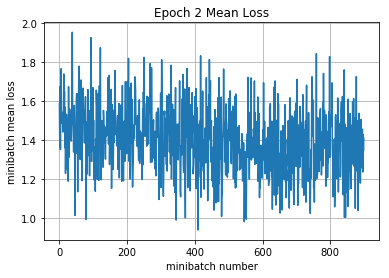

2017-10-25 14:52:50 Iter 1800: batch trn loss = 1.563, accuracy = 0.480
2017-10-25 14:53:01 Iter 1900: batch trn loss = 1.298, accuracy = 0.580
2017-10-25 14:53:13 Iter 2000: batch trn loss = 1.334, accuracy = 0.520
2017-10-25 14:53:24 Iter 2100: batch trn loss = 0.987, accuracy = 0.620
2017-10-25 14:53:36 Iter 2200: batch trn loss = 1.292, accuracy = 0.580
2017-10-25 14:53:47 Iter 2300: batch trn loss = 1.057, accuracy = 0.660
2017-10-25 14:53:58 Iter 2400: batch trn loss = 1.207, accuracy = 0.560
2017-10-25 14:54:11 Iter 2500: batch trn loss = 1.560, accuracy = 0.440
2017-10-25 14:54:22 Iter 2600: batch trn loss = 1.142, accuracy = 0.520
Epoch 2: mean loss = 1.276, accuracy = 0.555


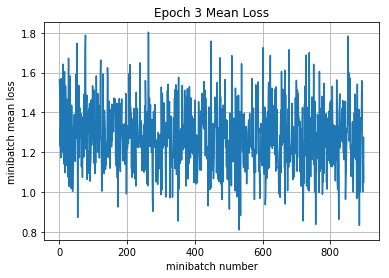

2017-10-25 14:54:35 Iter 2700: batch trn loss = 1.200, accuracy = 0.520
2017-10-25 14:54:47 Iter 2800: batch trn loss = 1.127, accuracy = 0.700
2017-10-25 14:54:58 Iter 2900: batch trn loss = 1.273, accuracy = 0.620
2017-10-25 14:55:10 Iter 3000: batch trn loss = 1.411, accuracy = 0.500
2017-10-25 14:55:21 Iter 3100: batch trn loss = 1.144, accuracy = 0.560
2017-10-25 14:55:33 Iter 3200: batch trn loss = 1.465, accuracy = 0.440
2017-10-25 14:55:45 Iter 3300: batch trn loss = 1.360, accuracy = 0.560
2017-10-25 14:55:57 Iter 3400: batch trn loss = 1.335, accuracy = 0.520
2017-10-25 14:56:10 Iter 3500: batch trn loss = 1.156, accuracy = 0.560
Epoch 3: mean loss = 1.190, accuracy = 0.587


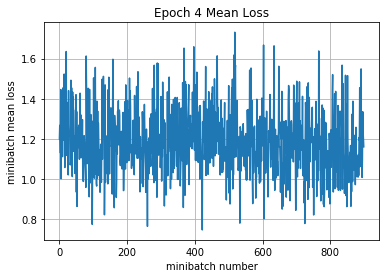

2017-10-25 14:56:24 Iter 3600: batch trn loss = 1.167, accuracy = 0.500
2017-10-25 14:56:37 Iter 3700: batch trn loss = 1.265, accuracy = 0.600
2017-10-25 14:56:51 Iter 3800: batch trn loss = 1.317, accuracy = 0.520
2017-10-25 14:57:05 Iter 3900: batch trn loss = 1.057, accuracy = 0.620
2017-10-25 14:57:20 Iter 4000: batch trn loss = 1.334, accuracy = 0.560
2017-10-25 14:57:35 Iter 4100: batch trn loss = 1.020, accuracy = 0.680
2017-10-25 14:57:52 Iter 4200: batch trn loss = 1.101, accuracy = 0.600
2017-10-25 14:58:06 Iter 4300: batch trn loss = 1.040, accuracy = 0.600
2017-10-25 14:58:21 Iter 4400: batch trn loss = 1.293, accuracy = 0.700
Epoch 4: mean loss = 1.129, accuracy = 0.608


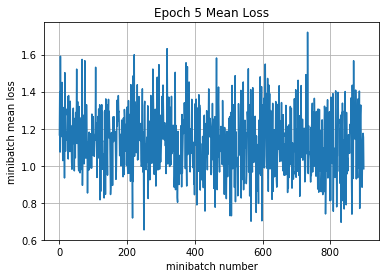

2017-10-25 14:58:39 Iter 4500: batch trn loss = 1.112, accuracy = 0.640
2017-10-25 14:58:54 Iter 4600: batch trn loss = 1.035, accuracy = 0.660
2017-10-25 14:59:09 Iter 4700: batch trn loss = 0.812, accuracy = 0.760
2017-10-25 14:59:24 Iter 4800: batch trn loss = 0.991, accuracy = 0.680
2017-10-25 14:59:38 Iter 4900: batch trn loss = 0.878, accuracy = 0.660
2017-10-25 14:59:51 Iter 5000: batch trn loss = 0.945, accuracy = 0.720
2017-10-25 15:00:05 Iter 5100: batch trn loss = 1.235, accuracy = 0.500
2017-10-25 15:00:24 Iter 5200: batch trn loss = 0.958, accuracy = 0.660
2017-10-25 15:00:38 Iter 5300: batch trn loss = 1.123, accuracy = 0.640
Epoch 5: mean loss = 1.085, accuracy = 0.625


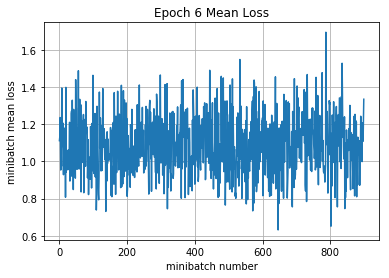

2017-10-25 15:00:52 Iter 5400: batch trn loss = 1.101, accuracy = 0.640
2017-10-25 15:01:05 Iter 5500: batch trn loss = 1.128, accuracy = 0.580
2017-10-25 15:01:20 Iter 5600: batch trn loss = 1.030, accuracy = 0.680
2017-10-25 15:01:35 Iter 5700: batch trn loss = 1.059, accuracy = 0.600
2017-10-25 15:01:49 Iter 5800: batch trn loss = 1.101, accuracy = 0.580
2017-10-25 15:02:03 Iter 5900: batch trn loss = 0.973, accuracy = 0.660
2017-10-25 15:02:16 Iter 6000: batch trn loss = 1.131, accuracy = 0.620
2017-10-25 15:02:31 Iter 6100: batch trn loss = 1.073, accuracy = 0.640
2017-10-25 15:02:44 Iter 6200: batch trn loss = 1.208, accuracy = 0.560
Epoch 6: mean loss = 1.044, accuracy = 0.639


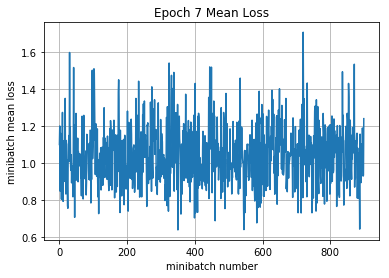

2017-10-25 15:02:58 Iter 6300: batch trn loss = 1.126, accuracy = 0.580
2017-10-25 15:03:11 Iter 6400: batch trn loss = 0.737, accuracy = 0.740
2017-10-25 15:03:25 Iter 6500: batch trn loss = 1.088, accuracy = 0.620
2017-10-25 15:03:39 Iter 6600: batch trn loss = 1.034, accuracy = 0.640
2017-10-25 15:03:52 Iter 6700: batch trn loss = 0.972, accuracy = 0.620
2017-10-25 15:04:04 Iter 6800: batch trn loss = 0.951, accuracy = 0.740
2017-10-25 15:04:16 Iter 6900: batch trn loss = 0.937, accuracy = 0.680
2017-10-25 15:04:29 Iter 7000: batch trn loss = 1.158, accuracy = 0.580
2017-10-25 15:04:41 Iter 7100: batch trn loss = 0.997, accuracy = 0.700
Epoch 7: mean loss = 1.013, accuracy = 0.652


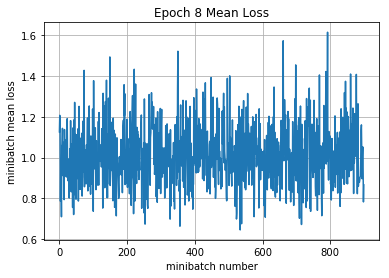

2017-10-25 15:04:54 Iter 7200: batch trn loss = 1.105, accuracy = 0.560
2017-10-25 15:05:06 Iter 7300: batch trn loss = 1.021, accuracy = 0.620
2017-10-25 15:05:18 Iter 7400: batch trn loss = 0.843, accuracy = 0.760
2017-10-25 15:05:31 Iter 7500: batch trn loss = 0.653, accuracy = 0.800
2017-10-25 15:05:44 Iter 7600: batch trn loss = 0.935, accuracy = 0.640
2017-10-25 15:05:56 Iter 7700: batch trn loss = 0.919, accuracy = 0.660
2017-10-25 15:06:08 Iter 7800: batch trn loss = 0.982, accuracy = 0.660
2017-10-25 15:06:20 Iter 7900: batch trn loss = 1.121, accuracy = 0.680
2017-10-25 15:06:33 Iter 8000: batch trn loss = 1.196, accuracy = 0.500
Epoch 8: mean loss = 0.980, accuracy = 0.662


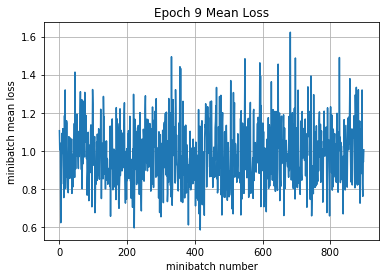

2017-10-25 15:06:45 Iter 8100: batch trn loss = 0.959, accuracy = 0.760
2017-10-25 15:06:57 Iter 8200: batch trn loss = 1.268, accuracy = 0.580
2017-10-25 15:07:10 Iter 8300: batch trn loss = 0.965, accuracy = 0.700
2017-10-25 15:07:22 Iter 8400: batch trn loss = 0.819, accuracy = 0.700
2017-10-25 15:07:35 Iter 8500: batch trn loss = 0.947, accuracy = 0.660
2017-10-25 15:07:47 Iter 8600: batch trn loss = 0.925, accuracy = 0.700
2017-10-25 15:08:00 Iter 8700: batch trn loss = 1.121, accuracy = 0.660
2017-10-25 15:08:12 Iter 8800: batch trn loss = 0.694, accuracy = 0.780
2017-10-25 15:08:25 Iter 8900: batch trn loss = 0.981, accuracy = 0.740
Epoch 9: mean loss = 0.956, accuracy = 0.670


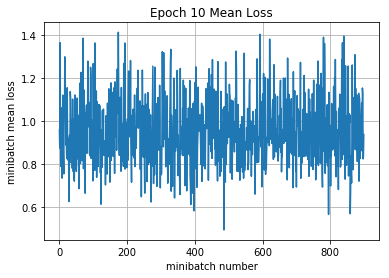

2017-10-25 15:08:37 Iter 9000: batch trn loss = 0.983, accuracy = 0.620
2017-10-25 15:08:49 Iter 9100: batch trn loss = 0.700, accuracy = 0.740
2017-10-25 15:09:01 Iter 9200: batch trn loss = 0.824, accuracy = 0.680
2017-10-25 15:09:14 Iter 9300: batch trn loss = 0.857, accuracy = 0.640
2017-10-25 15:09:26 Iter 9400: batch trn loss = 0.925, accuracy = 0.620
2017-10-25 15:09:38 Iter 9500: batch trn loss = 1.068, accuracy = 0.540
2017-10-25 15:09:50 Iter 9600: batch trn loss = 0.768, accuracy = 0.740
2017-10-25 15:10:02 Iter 9700: batch trn loss = 0.838, accuracy = 0.740
2017-10-25 15:10:14 Iter 9800: batch trn loss = 0.968, accuracy = 0.740
Epoch 10: mean loss = 0.931, accuracy = 0.680


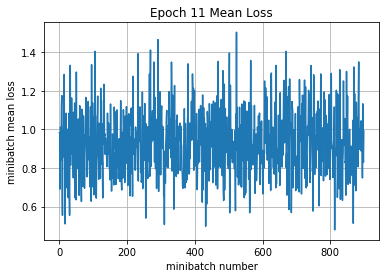

2017-10-25 15:10:26 Iter 9900: batch trn loss = 0.828, accuracy = 0.740
2017-10-25 15:10:38 Iter 10000: batch trn loss = 1.008, accuracy = 0.640
2017-10-25 15:10:50 Iter 10100: batch trn loss = 1.028, accuracy = 0.660
2017-10-25 15:11:02 Iter 10200: batch trn loss = 0.935, accuracy = 0.700
2017-10-25 15:11:14 Iter 10300: batch trn loss = 1.054, accuracy = 0.620
2017-10-25 15:11:27 Iter 10400: batch trn loss = 1.017, accuracy = 0.640
2017-10-25 15:11:39 Iter 10500: batch trn loss = 0.977, accuracy = 0.640
2017-10-25 15:11:51 Iter 10600: batch trn loss = 1.059, accuracy = 0.640
2017-10-25 15:12:03 Iter 10700: batch trn loss = 0.790, accuracy = 0.700
Epoch 11: mean loss = 0.910, accuracy = 0.687


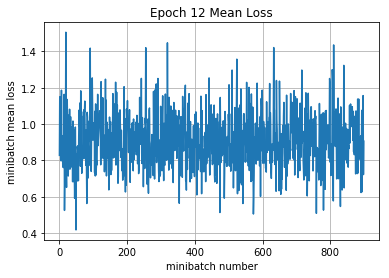

2017-10-25 15:12:15 Iter 10800: batch trn loss = 0.772, accuracy = 0.760
2017-10-25 15:12:27 Iter 10900: batch trn loss = 0.724, accuracy = 0.740
2017-10-25 15:12:39 Iter 11000: batch trn loss = 0.931, accuracy = 0.620
2017-10-25 15:12:51 Iter 11100: batch trn loss = 0.603, accuracy = 0.800
2017-10-25 15:13:03 Iter 11200: batch trn loss = 0.912, accuracy = 0.660
2017-10-25 15:13:15 Iter 11300: batch trn loss = 0.974, accuracy = 0.640
2017-10-25 15:13:27 Iter 11400: batch trn loss = 0.719, accuracy = 0.760
2017-10-25 15:13:39 Iter 11500: batch trn loss = 1.149, accuracy = 0.660
2017-10-25 15:13:51 Iter 11600: batch trn loss = 0.672, accuracy = 0.800
Epoch 12: mean loss = 0.888, accuracy = 0.694


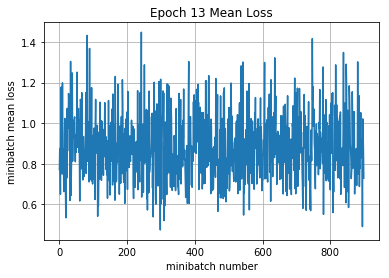

2017-10-25 15:14:04 Iter 11700: batch trn loss = 0.966, accuracy = 0.740
2017-10-25 15:14:16 Iter 11800: batch trn loss = 0.727, accuracy = 0.760
2017-10-25 15:14:28 Iter 11900: batch trn loss = 0.768, accuracy = 0.800
2017-10-25 15:14:40 Iter 12000: batch trn loss = 0.793, accuracy = 0.720
2017-10-25 15:14:52 Iter 12100: batch trn loss = 0.944, accuracy = 0.680
2017-10-25 15:15:04 Iter 12200: batch trn loss = 0.804, accuracy = 0.760
2017-10-25 15:15:16 Iter 12300: batch trn loss = 0.886, accuracy = 0.740
2017-10-25 15:15:28 Iter 12400: batch trn loss = 0.694, accuracy = 0.820
2017-10-25 15:15:40 Iter 12500: batch trn loss = 0.578, accuracy = 0.760
Epoch 13: mean loss = 0.869, accuracy = 0.701


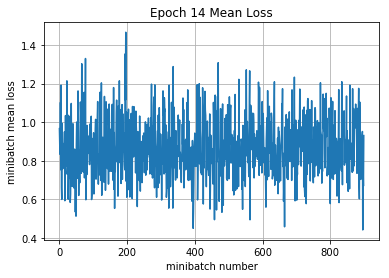

2017-10-25 15:15:52 Iter 12600: batch trn loss = 1.013, accuracy = 0.680
2017-10-25 15:16:04 Iter 12700: batch trn loss = 0.839, accuracy = 0.680
2017-10-25 15:16:16 Iter 12800: batch trn loss = 1.055, accuracy = 0.640
2017-10-25 15:16:28 Iter 12900: batch trn loss = 0.700, accuracy = 0.760
2017-10-25 15:16:41 Iter 13000: batch trn loss = 0.658, accuracy = 0.780
2017-10-25 15:16:53 Iter 13100: batch trn loss = 0.522, accuracy = 0.840
2017-10-25 15:17:05 Iter 13200: batch trn loss = 1.134, accuracy = 0.600
2017-10-25 15:17:17 Iter 13300: batch trn loss = 0.812, accuracy = 0.760
2017-10-25 15:17:29 Iter 13400: batch trn loss = 0.776, accuracy = 0.720
Epoch 14: mean loss = 0.853, accuracy = 0.708


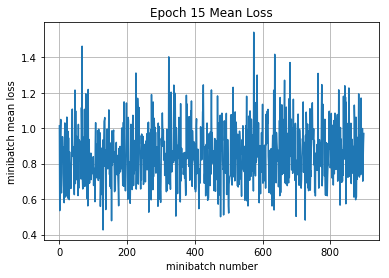

2017-10-25 15:17:41 Iter 13500: batch trn loss = 0.650, accuracy = 0.780
2017-10-25 15:17:53 Iter 13600: batch trn loss = 0.581, accuracy = 0.740
2017-10-25 15:18:05 Iter 13700: batch trn loss = 0.835, accuracy = 0.680
2017-10-25 15:18:17 Iter 13800: batch trn loss = 0.664, accuracy = 0.760
2017-10-25 15:18:29 Iter 13900: batch trn loss = 1.046, accuracy = 0.700
2017-10-25 15:18:41 Iter 14000: batch trn loss = 1.012, accuracy = 0.720
2017-10-25 15:18:54 Iter 14100: batch trn loss = 0.565, accuracy = 0.780
2017-10-25 15:19:06 Iter 14200: batch trn loss = 0.807, accuracy = 0.740
2017-10-25 15:19:18 Iter 14300: batch trn loss = 0.962, accuracy = 0.600
Epoch 15: mean loss = 0.838, accuracy = 0.710


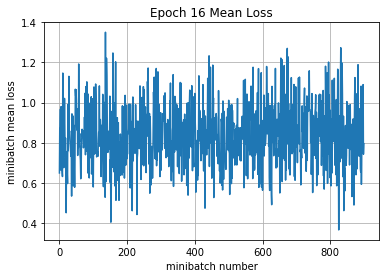

2017-10-25 15:19:30 Iter 14400: batch trn loss = 0.848, accuracy = 0.740
2017-10-25 15:19:42 Iter 14500: batch trn loss = 0.839, accuracy = 0.800
2017-10-25 15:19:54 Iter 14600: batch trn loss = 0.731, accuracy = 0.800
2017-10-25 15:20:06 Iter 14700: batch trn loss = 0.860, accuracy = 0.660
2017-10-25 15:20:19 Iter 14800: batch trn loss = 0.887, accuracy = 0.740
2017-10-25 15:20:31 Iter 14900: batch trn loss = 1.082, accuracy = 0.660
2017-10-25 15:20:43 Iter 15000: batch trn loss = 0.931, accuracy = 0.700
2017-10-25 15:20:55 Iter 15100: batch trn loss = 0.767, accuracy = 0.720
2017-10-25 15:21:07 Iter 15200: batch trn loss = 0.622, accuracy = 0.760
Epoch 16: mean loss = 0.824, accuracy = 0.716


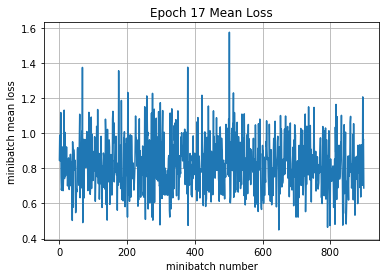

2017-10-25 15:21:20 Iter 15300: batch trn loss = 0.578, accuracy = 0.840
2017-10-25 15:21:32 Iter 15400: batch trn loss = 0.637, accuracy = 0.800
2017-10-25 15:21:44 Iter 15500: batch trn loss = 0.985, accuracy = 0.760
2017-10-25 15:21:56 Iter 15600: batch trn loss = 0.651, accuracy = 0.800
2017-10-25 15:22:09 Iter 15700: batch trn loss = 0.951, accuracy = 0.660
2017-10-25 15:22:21 Iter 15800: batch trn loss = 0.739, accuracy = 0.740
2017-10-25 15:22:33 Iter 15900: batch trn loss = 1.036, accuracy = 0.640
2017-10-25 15:22:45 Iter 16000: batch trn loss = 0.824, accuracy = 0.760
2017-10-25 15:22:57 Iter 16100: batch trn loss = 0.723, accuracy = 0.720
Epoch 17: mean loss = 0.811, accuracy = 0.721


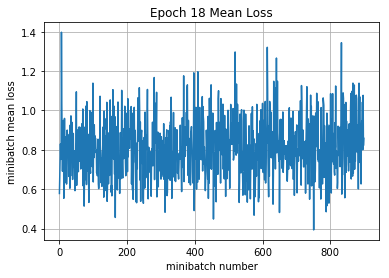

2017-10-25 15:23:09 Iter 16200: batch trn loss = 0.673, accuracy = 0.820
2017-10-25 15:23:21 Iter 16300: batch trn loss = 0.958, accuracy = 0.660
2017-10-25 15:23:33 Iter 16400: batch trn loss = 0.720, accuracy = 0.740
2017-10-25 15:23:46 Iter 16500: batch trn loss = 0.596, accuracy = 0.780
2017-10-25 15:23:58 Iter 16600: batch trn loss = 0.852, accuracy = 0.740
2017-10-25 15:24:11 Iter 16700: batch trn loss = 0.705, accuracy = 0.780
2017-10-25 15:24:23 Iter 16800: batch trn loss = 0.997, accuracy = 0.560
2017-10-25 15:24:36 Iter 16900: batch trn loss = 0.601, accuracy = 0.760
2017-10-25 15:24:49 Iter 17000: batch trn loss = 0.819, accuracy = 0.780
Epoch 18: mean loss = 0.798, accuracy = 0.724


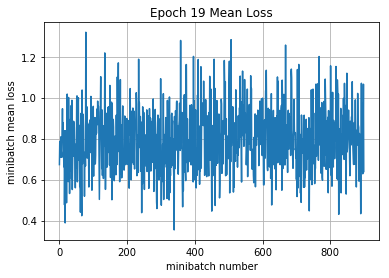

2017-10-25 15:25:02 Iter 17100: batch trn loss = 0.716, accuracy = 0.660
2017-10-25 15:25:15 Iter 17200: batch trn loss = 0.771, accuracy = 0.760
2017-10-25 15:25:29 Iter 17300: batch trn loss = 0.754, accuracy = 0.720
2017-10-25 15:25:42 Iter 17400: batch trn loss = 0.818, accuracy = 0.720
2017-10-25 15:25:56 Iter 17500: batch trn loss = 1.212, accuracy = 0.600
2017-10-25 15:26:09 Iter 17600: batch trn loss = 0.699, accuracy = 0.780
2017-10-25 15:26:23 Iter 17700: batch trn loss = 0.843, accuracy = 0.680
2017-10-25 15:26:37 Iter 17800: batch trn loss = 0.816, accuracy = 0.740
2017-10-25 15:26:50 Iter 17900: batch trn loss = 1.150, accuracy = 0.640
Epoch 19: mean loss = 0.784, accuracy = 0.728


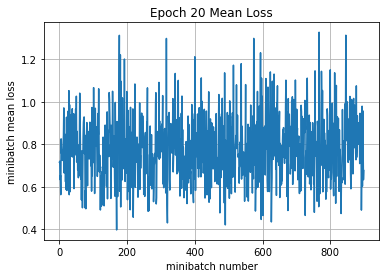

validation
Epoch 0: mean loss = 1.115, accuracy = 0.635


In [55]:
def model_fn(layer_input, labels, is_training):
    F1 = 32
    layer_conv1 = tf.layers.conv2d(inputs=layer_input, filters=F1, kernel_size=[3, 3], padding='same', activation=tf.nn.relu)
    layer_bn1 = tf.layers.batch_normalization(inputs=layer_conv1, training=is_training)
    layer_pool1 = tf.layers.max_pooling2d(inputs=layer_conv1, pool_size=[2, 2], strides=2)
    F2 = 64
    layer_conv2 = tf.layers.conv2d(inputs=layer_pool1, filters=F2, kernel_size=[3, 3], padding='same', activation=tf.nn.relu)
    layer_bn2 = tf.layers.batch_normalization(inputs=layer_conv2, training=is_training)
    layer_pool2 = tf.layers.max_pooling2d(inputs=layer_bn2, pool_size=[2, 2], strides=2)
    flat_size = int(H / 4 * W / 4 * F2)
    print(flat_size)
    layer_pool2_flat = tf.reshape(layer_pool2, [-1, flat_size])
    layer_dense = tf.layers.dense(inputs=layer_pool2_flat, units=1024)
    # layer_dropout = tf.layers.dropout(inputs=layer_dense, rate=0.4)
    layer_logit = tf.layers.dense(inputs=layer_dense, units=T)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int64), depth=10)
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=layer_logit)
    return layer_logit, loss

trai1ner = tf.train.GradientDescentOptimizer(learning_rate=0.001)
cnn = CNN(model_fn, trainer)
print('train')
cnn.train(X_trn, y_trn, epochs=20, batch_size=50, print_every=100, plot_losses=True)
print('validation')
cnn.validate(X_val, y_val, epochs=1, batch_size=50)

## [0005] last dense with activation and batch normalization
- trn: 0.832, val: 0.681 (20 epochs)
- trn: 0.904, val: 0.659 (30 epochs)

4096
train
2017-10-25 15:38:28 Iter 0: batch trn loss = 3.241, accuracy = 0.020
2017-10-25 15:38:52 Iter 100: batch trn loss = 2.336, accuracy = 0.300
2017-10-25 15:39:17 Iter 200: batch trn loss = 1.808, accuracy = 0.340
2017-10-25 15:39:42 Iter 300: batch trn loss = 1.572, accuracy = 0.340
2017-10-25 15:40:08 Iter 400: batch trn loss = 1.995, accuracy = 0.220
2017-10-25 15:40:32 Iter 500: batch trn loss = 1.641, accuracy = 0.400
2017-10-25 15:40:57 Iter 600: batch trn loss = 1.455, accuracy = 0.560
2017-10-25 15:41:18 Iter 700: batch trn loss = 1.350, accuracy = 0.600
2017-10-25 15:41:44 Iter 800: batch trn loss = 1.505, accuracy = 0.460
Epoch 0: mean loss = 1.800, accuracy = 0.386


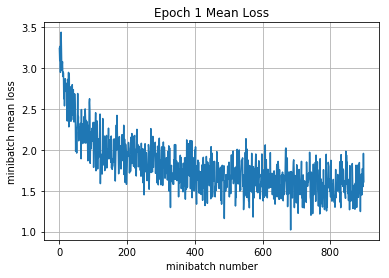

2017-10-25 15:42:09 Iter 900: batch trn loss = 1.416, accuracy = 0.500
2017-10-25 15:42:35 Iter 1000: batch trn loss = 1.369, accuracy = 0.520
2017-10-25 15:43:00 Iter 1100: batch trn loss = 1.365, accuracy = 0.580
2017-10-25 15:43:25 Iter 1200: batch trn loss = 1.291, accuracy = 0.520
2017-10-25 15:43:50 Iter 1300: batch trn loss = 1.303, accuracy = 0.520
2017-10-25 15:44:15 Iter 1400: batch trn loss = 1.348, accuracy = 0.540
2017-10-25 15:44:40 Iter 1500: batch trn loss = 1.266, accuracy = 0.540
2017-10-25 15:45:06 Iter 1600: batch trn loss = 1.178, accuracy = 0.640
2017-10-25 15:45:35 Iter 1700: batch trn loss = 1.415, accuracy = 0.480
Epoch 1: mean loss = 1.375, accuracy = 0.518


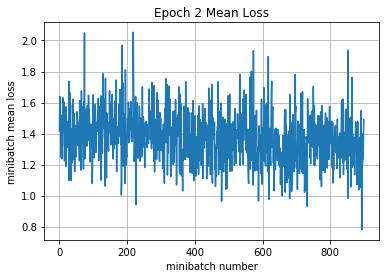

2017-10-25 15:46:01 Iter 1800: batch trn loss = 1.020, accuracy = 0.640
2017-10-25 15:46:26 Iter 1900: batch trn loss = 1.009, accuracy = 0.620
2017-10-25 15:46:52 Iter 2000: batch trn loss = 1.227, accuracy = 0.540
2017-10-25 15:47:17 Iter 2100: batch trn loss = 1.479, accuracy = 0.560
2017-10-25 15:47:42 Iter 2200: batch trn loss = 1.454, accuracy = 0.420
2017-10-25 15:48:08 Iter 2300: batch trn loss = 1.339, accuracy = 0.500
2017-10-25 15:48:33 Iter 2400: batch trn loss = 1.564, accuracy = 0.360
2017-10-25 15:48:58 Iter 2500: batch trn loss = 1.289, accuracy = 0.660
2017-10-25 15:49:24 Iter 2600: batch trn loss = 0.906, accuracy = 0.660
Epoch 2: mean loss = 1.223, accuracy = 0.571


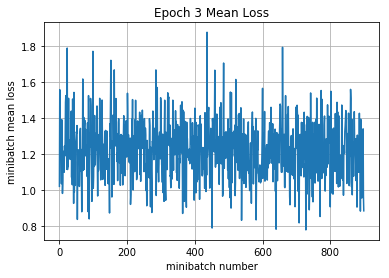

2017-10-25 15:49:49 Iter 2700: batch trn loss = 1.068, accuracy = 0.640
2017-10-25 15:50:16 Iter 2800: batch trn loss = 1.129, accuracy = 0.600
2017-10-25 15:50:42 Iter 2900: batch trn loss = 1.086, accuracy = 0.600
2017-10-25 15:51:07 Iter 3000: batch trn loss = 1.295, accuracy = 0.600
2017-10-25 15:51:32 Iter 3100: batch trn loss = 1.043, accuracy = 0.620
2017-10-25 15:51:58 Iter 3200: batch trn loss = 1.155, accuracy = 0.540
2017-10-25 15:52:24 Iter 3300: batch trn loss = 0.937, accuracy = 0.660
2017-10-25 15:52:50 Iter 3400: batch trn loss = 1.375, accuracy = 0.480
2017-10-25 15:53:16 Iter 3500: batch trn loss = 1.083, accuracy = 0.660
Epoch 3: mean loss = 1.125, accuracy = 0.608


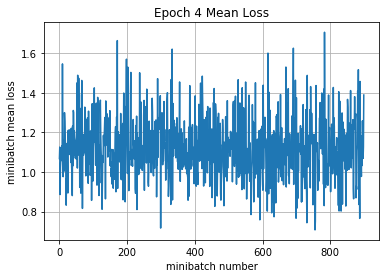

2017-10-25 15:53:42 Iter 3600: batch trn loss = 1.091, accuracy = 0.640
2017-10-25 15:54:07 Iter 3700: batch trn loss = 1.065, accuracy = 0.600
2017-10-25 15:54:34 Iter 3800: batch trn loss = 1.098, accuracy = 0.720
2017-10-25 15:55:00 Iter 3900: batch trn loss = 1.022, accuracy = 0.680
2017-10-25 15:55:25 Iter 4000: batch trn loss = 1.009, accuracy = 0.640
2017-10-25 15:55:49 Iter 4100: batch trn loss = 0.971, accuracy = 0.640
2017-10-25 15:56:14 Iter 4200: batch trn loss = 0.997, accuracy = 0.620
2017-10-25 15:56:39 Iter 4300: batch trn loss = 1.060, accuracy = 0.620
2017-10-25 15:57:04 Iter 4400: batch trn loss = 1.270, accuracy = 0.480
Epoch 4: mean loss = 1.046, accuracy = 0.639


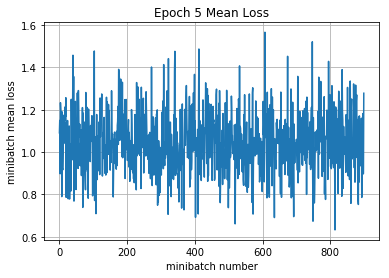

2017-10-25 15:57:30 Iter 4500: batch trn loss = 1.207, accuracy = 0.580
2017-10-25 15:57:56 Iter 4600: batch trn loss = 1.380, accuracy = 0.460
2017-10-25 15:58:23 Iter 4700: batch trn loss = 1.006, accuracy = 0.600
2017-10-25 15:58:49 Iter 4800: batch trn loss = 0.902, accuracy = 0.660
2017-10-25 15:59:14 Iter 4900: batch trn loss = 0.908, accuracy = 0.700
2017-10-25 15:59:41 Iter 5000: batch trn loss = 0.963, accuracy = 0.680
2017-10-25 16:00:08 Iter 5100: batch trn loss = 0.938, accuracy = 0.680
2017-10-25 16:00:34 Iter 5200: batch trn loss = 1.073, accuracy = 0.620
2017-10-25 16:01:03 Iter 5300: batch trn loss = 1.022, accuracy = 0.600
Epoch 5: mean loss = 0.988, accuracy = 0.657


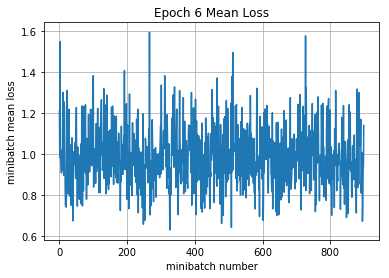

2017-10-25 16:01:34 Iter 5400: batch trn loss = 0.850, accuracy = 0.680
2017-10-25 16:02:02 Iter 5500: batch trn loss = 1.122, accuracy = 0.640
2017-10-25 16:02:28 Iter 5600: batch trn loss = 1.115, accuracy = 0.640
2017-10-25 16:02:53 Iter 5700: batch trn loss = 1.145, accuracy = 0.600
2017-10-25 16:03:19 Iter 5800: batch trn loss = 0.844, accuracy = 0.740
2017-10-25 16:03:46 Iter 5900: batch trn loss = 1.019, accuracy = 0.720
2017-10-25 16:04:11 Iter 6000: batch trn loss = 0.822, accuracy = 0.700
2017-10-25 16:04:37 Iter 6100: batch trn loss = 1.021, accuracy = 0.640
2017-10-25 16:05:03 Iter 6200: batch trn loss = 0.903, accuracy = 0.680
Epoch 6: mean loss = 0.929, accuracy = 0.678


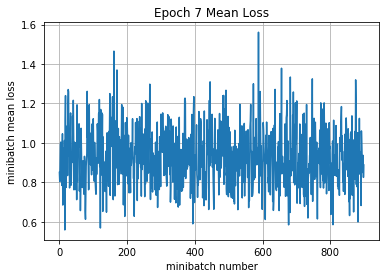

2017-10-25 16:05:28 Iter 6300: batch trn loss = 0.815, accuracy = 0.780
2017-10-25 16:05:53 Iter 6400: batch trn loss = 1.020, accuracy = 0.660
2017-10-25 16:06:18 Iter 6500: batch trn loss = 0.708, accuracy = 0.680
2017-10-25 16:06:43 Iter 6600: batch trn loss = 1.195, accuracy = 0.560
2017-10-25 16:07:12 Iter 6700: batch trn loss = 0.822, accuracy = 0.700
2017-10-25 16:07:38 Iter 6800: batch trn loss = 0.708, accuracy = 0.760
2017-10-25 16:08:02 Iter 6900: batch trn loss = 0.796, accuracy = 0.740
2017-10-25 16:08:28 Iter 7000: batch trn loss = 0.996, accuracy = 0.660
2017-10-25 16:08:54 Iter 7100: batch trn loss = 0.586, accuracy = 0.840
Epoch 7: mean loss = 0.882, accuracy = 0.699


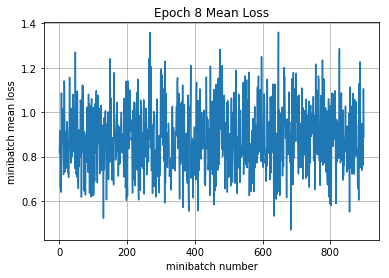

2017-10-25 16:09:19 Iter 7200: batch trn loss = 0.775, accuracy = 0.780
2017-10-25 16:09:45 Iter 7300: batch trn loss = 0.781, accuracy = 0.760
2017-10-25 16:10:12 Iter 7400: batch trn loss = 0.967, accuracy = 0.540
2017-10-25 16:10:38 Iter 7500: batch trn loss = 0.768, accuracy = 0.780
2017-10-25 16:11:04 Iter 7600: batch trn loss = 0.938, accuracy = 0.700
2017-10-25 16:11:31 Iter 7700: batch trn loss = 1.019, accuracy = 0.700
2017-10-25 16:11:58 Iter 7800: batch trn loss = 0.940, accuracy = 0.660
2017-10-25 16:12:24 Iter 7900: batch trn loss = 1.103, accuracy = 0.700
2017-10-25 16:12:49 Iter 8000: batch trn loss = 0.843, accuracy = 0.720
Epoch 8: mean loss = 0.841, accuracy = 0.711


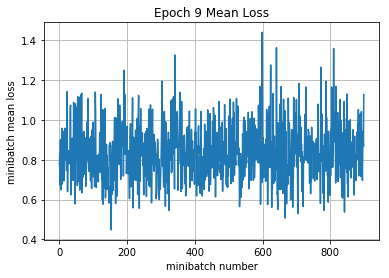

2017-10-25 16:13:15 Iter 8100: batch trn loss = 0.950, accuracy = 0.640
2017-10-25 16:13:41 Iter 8200: batch trn loss = 0.675, accuracy = 0.800
2017-10-25 16:14:08 Iter 8300: batch trn loss = 0.944, accuracy = 0.620
2017-10-25 16:14:33 Iter 8400: batch trn loss = 0.495, accuracy = 0.920
2017-10-25 16:15:01 Iter 8500: batch trn loss = 0.791, accuracy = 0.680
2017-10-25 16:15:30 Iter 8600: batch trn loss = 0.546, accuracy = 0.860
2017-10-25 16:15:56 Iter 8700: batch trn loss = 1.017, accuracy = 0.620
2017-10-25 16:16:22 Iter 8800: batch trn loss = 0.994, accuracy = 0.640
2017-10-25 16:16:47 Iter 8900: batch trn loss = 0.736, accuracy = 0.680
Epoch 9: mean loss = 0.801, accuracy = 0.729


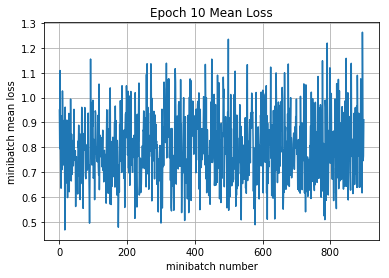

2017-10-25 16:17:13 Iter 9000: batch trn loss = 0.654, accuracy = 0.780
2017-10-25 16:17:40 Iter 9100: batch trn loss = 0.690, accuracy = 0.760
2017-10-25 16:18:04 Iter 9200: batch trn loss = 1.093, accuracy = 0.620
2017-10-25 16:18:29 Iter 9300: batch trn loss = 0.799, accuracy = 0.720
2017-10-25 16:18:54 Iter 9400: batch trn loss = 0.806, accuracy = 0.760
2017-10-25 16:19:19 Iter 9500: batch trn loss = 0.858, accuracy = 0.760
2017-10-25 16:19:45 Iter 9600: batch trn loss = 0.682, accuracy = 0.760
2017-10-25 16:20:10 Iter 9700: batch trn loss = 0.960, accuracy = 0.620
2017-10-25 16:20:37 Iter 9800: batch trn loss = 0.812, accuracy = 0.640
Epoch 10: mean loss = 0.767, accuracy = 0.741


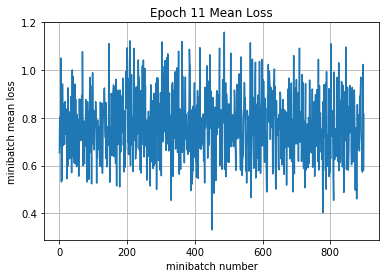

2017-10-25 16:21:02 Iter 9900: batch trn loss = 0.488, accuracy = 0.780
2017-10-25 16:21:28 Iter 10000: batch trn loss = 0.790, accuracy = 0.700
2017-10-25 16:21:52 Iter 10100: batch trn loss = 0.670, accuracy = 0.800
2017-10-25 16:22:17 Iter 10200: batch trn loss = 0.521, accuracy = 0.840
2017-10-25 16:22:43 Iter 10300: batch trn loss = 0.542, accuracy = 0.880
2017-10-25 16:23:08 Iter 10400: batch trn loss = 0.872, accuracy = 0.660
2017-10-25 16:23:32 Iter 10500: batch trn loss = 0.858, accuracy = 0.720
2017-10-25 16:23:58 Iter 10600: batch trn loss = 0.717, accuracy = 0.720
2017-10-25 16:24:25 Iter 10700: batch trn loss = 0.709, accuracy = 0.780
Epoch 11: mean loss = 0.738, accuracy = 0.751


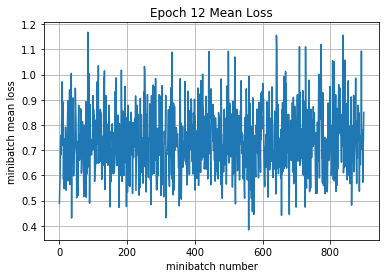

2017-10-25 16:24:51 Iter 10800: batch trn loss = 0.618, accuracy = 0.840
2017-10-25 16:25:20 Iter 10900: batch trn loss = 0.631, accuracy = 0.780
2017-10-25 16:25:50 Iter 11000: batch trn loss = 0.642, accuracy = 0.820
2017-10-25 16:26:16 Iter 11100: batch trn loss = 0.575, accuracy = 0.780
2017-10-25 16:26:41 Iter 11200: batch trn loss = 0.546, accuracy = 0.800
2017-10-25 16:27:08 Iter 11300: batch trn loss = 1.166, accuracy = 0.560
2017-10-25 16:27:35 Iter 11400: batch trn loss = 0.789, accuracy = 0.720
2017-10-25 16:28:01 Iter 11500: batch trn loss = 0.690, accuracy = 0.800
2017-10-25 16:28:24 Iter 11600: batch trn loss = 0.604, accuracy = 0.760
Epoch 12: mean loss = 0.707, accuracy = 0.763


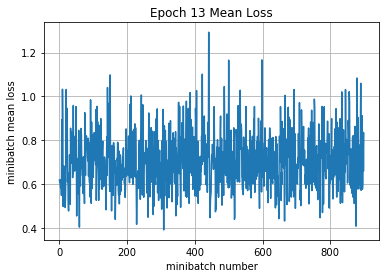

2017-10-25 16:28:46 Iter 11700: batch trn loss = 0.583, accuracy = 0.800
2017-10-25 16:29:14 Iter 11800: batch trn loss = 0.591, accuracy = 0.780
2017-10-25 16:29:40 Iter 11900: batch trn loss = 0.560, accuracy = 0.820
2017-10-25 16:30:06 Iter 12000: batch trn loss = 0.751, accuracy = 0.760
2017-10-25 16:30:31 Iter 12100: batch trn loss = 0.832, accuracy = 0.700
2017-10-25 16:30:57 Iter 12200: batch trn loss = 0.754, accuracy = 0.680
2017-10-25 16:31:29 Iter 12300: batch trn loss = 0.492, accuracy = 0.840
2017-10-25 16:31:58 Iter 12400: batch trn loss = 0.824, accuracy = 0.740
2017-10-25 16:32:24 Iter 12500: batch trn loss = 0.754, accuracy = 0.780
Epoch 13: mean loss = 0.678, accuracy = 0.775


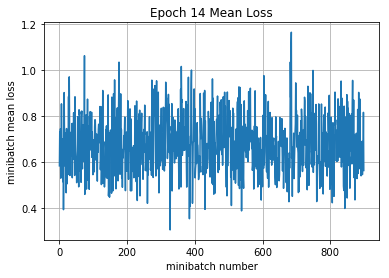

2017-10-25 16:32:49 Iter 12600: batch trn loss = 0.566, accuracy = 0.840
2017-10-25 16:33:14 Iter 12700: batch trn loss = 0.557, accuracy = 0.780
2017-10-25 16:33:39 Iter 12800: batch trn loss = 0.648, accuracy = 0.760
2017-10-25 16:34:03 Iter 12900: batch trn loss = 0.620, accuracy = 0.740
2017-10-25 16:34:28 Iter 13000: batch trn loss = 0.417, accuracy = 0.860
2017-10-25 16:34:53 Iter 13100: batch trn loss = 0.558, accuracy = 0.820
2017-10-25 16:35:18 Iter 13200: batch trn loss = 0.687, accuracy = 0.780
2017-10-25 16:35:41 Iter 13300: batch trn loss = 0.772, accuracy = 0.740
2017-10-25 16:36:07 Iter 13400: batch trn loss = 0.738, accuracy = 0.740
Epoch 14: mean loss = 0.647, accuracy = 0.787


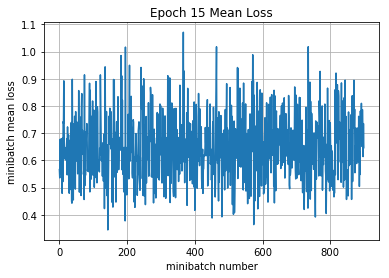

2017-10-25 16:36:33 Iter 13500: batch trn loss = 0.777, accuracy = 0.760
2017-10-25 16:36:59 Iter 13600: batch trn loss = 0.622, accuracy = 0.800
2017-10-25 16:37:25 Iter 13700: batch trn loss = 0.721, accuracy = 0.780
2017-10-25 16:37:50 Iter 13800: batch trn loss = 0.491, accuracy = 0.840
2017-10-25 16:38:14 Iter 13900: batch trn loss = 0.533, accuracy = 0.780
2017-10-25 16:38:39 Iter 14000: batch trn loss = 0.529, accuracy = 0.840
2017-10-25 16:39:04 Iter 14100: batch trn loss = 0.657, accuracy = 0.780
2017-10-25 16:39:29 Iter 14200: batch trn loss = 0.633, accuracy = 0.800
2017-10-25 16:39:53 Iter 14300: batch trn loss = 0.758, accuracy = 0.740
Epoch 15: mean loss = 0.625, accuracy = 0.795


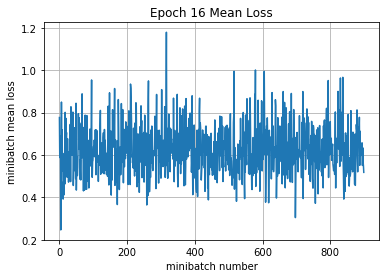

2017-10-25 16:40:19 Iter 14400: batch trn loss = 0.569, accuracy = 0.800
2017-10-25 16:40:41 Iter 14500: batch trn loss = 0.452, accuracy = 0.860
2017-10-25 16:41:02 Iter 14600: batch trn loss = 0.749, accuracy = 0.780
2017-10-25 16:41:23 Iter 14700: batch trn loss = 0.732, accuracy = 0.660
2017-10-25 16:41:43 Iter 14800: batch trn loss = 0.804, accuracy = 0.740
2017-10-25 16:42:03 Iter 14900: batch trn loss = 0.697, accuracy = 0.740
2017-10-25 16:42:23 Iter 15000: batch trn loss = 0.677, accuracy = 0.800
2017-10-25 16:42:43 Iter 15100: batch trn loss = 0.591, accuracy = 0.840
2017-10-25 16:43:03 Iter 15200: batch trn loss = 0.617, accuracy = 0.780
Epoch 16: mean loss = 0.597, accuracy = 0.804


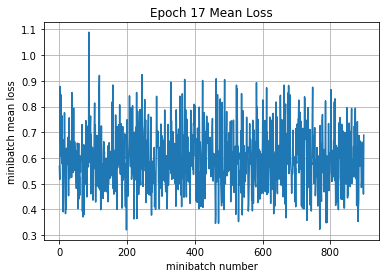

2017-10-25 16:43:24 Iter 15300: batch trn loss = 0.483, accuracy = 0.860
2017-10-25 16:43:44 Iter 15400: batch trn loss = 0.666, accuracy = 0.740
2017-10-25 16:44:04 Iter 15500: batch trn loss = 0.528, accuracy = 0.840
2017-10-25 16:44:24 Iter 15600: batch trn loss = 0.484, accuracy = 0.860
2017-10-25 16:44:44 Iter 15700: batch trn loss = 0.504, accuracy = 0.820
2017-10-25 16:45:04 Iter 15800: batch trn loss = 0.783, accuracy = 0.640
2017-10-25 16:45:24 Iter 15900: batch trn loss = 0.724, accuracy = 0.780
2017-10-25 16:45:45 Iter 16000: batch trn loss = 0.500, accuracy = 0.920
2017-10-25 16:46:06 Iter 16100: batch trn loss = 0.495, accuracy = 0.860
Epoch 17: mean loss = 0.574, accuracy = 0.814


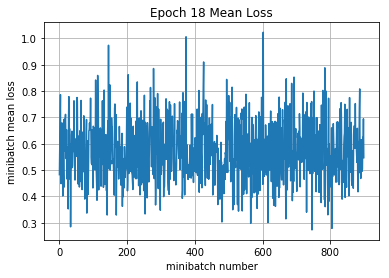

2017-10-25 16:46:27 Iter 16200: batch trn loss = 0.634, accuracy = 0.820
2017-10-25 16:46:48 Iter 16300: batch trn loss = 0.526, accuracy = 0.820
2017-10-25 16:47:08 Iter 16400: batch trn loss = 0.494, accuracy = 0.840
2017-10-25 16:47:28 Iter 16500: batch trn loss = 0.602, accuracy = 0.880
2017-10-25 16:47:49 Iter 16600: batch trn loss = 0.422, accuracy = 0.900
2017-10-25 16:48:09 Iter 16700: batch trn loss = 0.729, accuracy = 0.740
2017-10-25 16:48:30 Iter 16800: batch trn loss = 0.556, accuracy = 0.840
2017-10-25 16:48:53 Iter 16900: batch trn loss = 0.542, accuracy = 0.820
2017-10-25 16:49:17 Iter 17000: batch trn loss = 0.678, accuracy = 0.740
Epoch 18: mean loss = 0.550, accuracy = 0.824


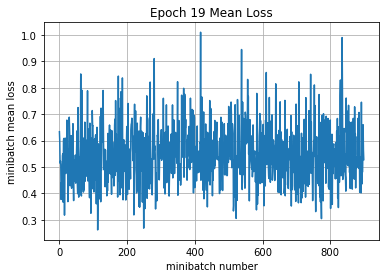

2017-10-25 16:49:40 Iter 17100: batch trn loss = 0.547, accuracy = 0.800
2017-10-25 16:50:00 Iter 17200: batch trn loss = 0.390, accuracy = 0.900
2017-10-25 16:50:21 Iter 17300: batch trn loss = 0.419, accuracy = 0.860
2017-10-25 16:50:43 Iter 17400: batch trn loss = 0.690, accuracy = 0.760
2017-10-25 16:51:10 Iter 17500: batch trn loss = 0.698, accuracy = 0.740
2017-10-25 16:51:32 Iter 17600: batch trn loss = 0.663, accuracy = 0.800
2017-10-25 16:51:53 Iter 17700: batch trn loss = 0.542, accuracy = 0.840
2017-10-25 16:52:14 Iter 17800: batch trn loss = 0.645, accuracy = 0.780
2017-10-25 16:52:36 Iter 17900: batch trn loss = 0.586, accuracy = 0.820
Epoch 19: mean loss = 0.530, accuracy = 0.832


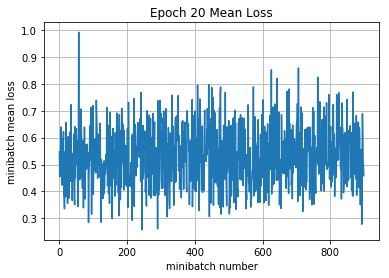

validation
Epoch 0: mean loss = 0.973, accuracy = 0.681


In [62]:
def model_fn(layer_input, labels, is_training):
    # conv - bn - max_pool
    F1 = 32
    layer = tf.layers.conv2d(inputs=layer_input, filters=F1, kernel_size=[5, 5], padding='same', activation=tf.nn.relu)
    layer = tf.layers.batch_normalization(inputs=layer, training=is_training)
    layer = tf.layers.max_pooling2d(inputs=layer, pool_size=[2, 2], strides=2)
    # conv - bn - max_pool
    F2 = 64
    layer = tf.layers.conv2d(inputs=layer, filters=F2, kernel_size=[5, 5], padding='same', activation=tf.nn.relu)
    layer = tf.layers.batch_normalization(inputs=layer, training=is_training)
    layer = tf.layers.max_pooling2d(inputs=layer, pool_size=[2, 2], strides=2)
    # dense1 - bn - softmax
    flat_size = int(H / 4 * W / 4 * F2)
    print(flat_size)
    layer = tf.reshape(layer, [-1, flat_size])
    layer = tf.layers.dense(inputs=layer, units=1024, activation=tf.nn.relu)
    layer = tf.layers.batch_normalization(inputs=layer, training=is_training)
    # layer_dropout = tf.layers.dropout(inputs=layer_dense, rate=0.4)
    # no activation here for logit, as it will be calculated in loss
    logit = tf.layers.dense(inputs=layer, units=T, activation=None)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int64), depth=10)
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=logit)
    return logit, loss

trainer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
cnn = CNN(model_fn, trainer)
print('train')
cnn.train(X_trn, y_trn, epochs=20, batch_size=50, print_every=100, plot_losses=True)
print('validation')
cnn.validate(X_val, y_val, epochs=1, batch_size=y_val.shape[0])

train
2017-10-25 17:12:04 Iter 0: batch trn loss = 0.504, accuracy = 0.840
2017-10-25 17:12:24 Iter 100: batch trn loss = 0.611, accuracy = 0.800
2017-10-25 17:12:44 Iter 200: batch trn loss = 0.586, accuracy = 0.800
2017-10-25 17:13:04 Iter 300: batch trn loss = 0.372, accuracy = 0.860
2017-10-25 17:13:25 Iter 400: batch trn loss = 0.401, accuracy = 0.920
2017-10-25 17:13:45 Iter 500: batch trn loss = 0.537, accuracy = 0.840
2017-10-25 17:14:05 Iter 600: batch trn loss = 0.347, accuracy = 0.880
2017-10-25 17:14:25 Iter 700: batch trn loss = 0.376, accuracy = 0.920
2017-10-25 17:14:46 Iter 800: batch trn loss = 0.515, accuracy = 0.840
Epoch 0: mean loss = 0.508, accuracy = 0.840


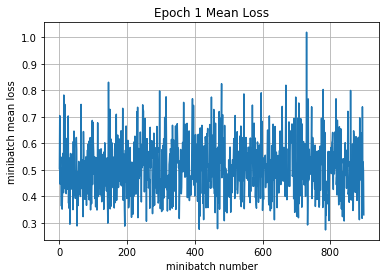

2017-10-25 17:15:06 Iter 900: batch trn loss = 0.615, accuracy = 0.800
2017-10-25 17:15:26 Iter 1000: batch trn loss = 0.340, accuracy = 0.900
2017-10-25 17:15:47 Iter 1100: batch trn loss = 0.502, accuracy = 0.840
2017-10-25 17:16:07 Iter 1200: batch trn loss = 0.648, accuracy = 0.800
2017-10-25 17:16:28 Iter 1300: batch trn loss = 0.485, accuracy = 0.820
2017-10-25 17:16:49 Iter 1400: batch trn loss = 0.529, accuracy = 0.800
2017-10-25 17:17:10 Iter 1500: batch trn loss = 0.430, accuracy = 0.900
2017-10-25 17:17:31 Iter 1600: batch trn loss = 0.559, accuracy = 0.840
2017-10-25 17:17:51 Iter 1700: batch trn loss = 0.349, accuracy = 0.880
Epoch 1: mean loss = 0.488, accuracy = 0.847


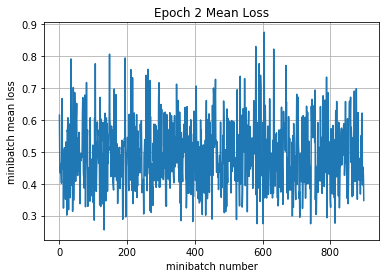

2017-10-25 17:18:14 Iter 1800: batch trn loss = 0.500, accuracy = 0.840
2017-10-25 17:18:35 Iter 1900: batch trn loss = 0.427, accuracy = 0.880
2017-10-25 17:18:55 Iter 2000: batch trn loss = 0.454, accuracy = 0.900
2017-10-25 17:19:16 Iter 2100: batch trn loss = 0.621, accuracy = 0.800
2017-10-25 17:19:36 Iter 2200: batch trn loss = 0.395, accuracy = 0.900
2017-10-25 17:19:57 Iter 2300: batch trn loss = 0.304, accuracy = 0.920
2017-10-25 17:20:17 Iter 2400: batch trn loss = 0.420, accuracy = 0.940
2017-10-25 17:20:37 Iter 2500: batch trn loss = 0.537, accuracy = 0.840
2017-10-25 17:20:58 Iter 2600: batch trn loss = 0.425, accuracy = 0.880
Epoch 2: mean loss = 0.469, accuracy = 0.857


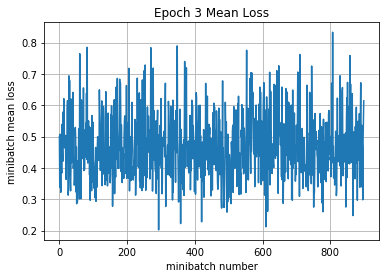

2017-10-25 17:21:18 Iter 2700: batch trn loss = 0.513, accuracy = 0.820
2017-10-25 17:21:38 Iter 2800: batch trn loss = 0.599, accuracy = 0.840
2017-10-25 17:21:59 Iter 2900: batch trn loss = 0.529, accuracy = 0.800
2017-10-25 17:22:19 Iter 3000: batch trn loss = 0.435, accuracy = 0.840
2017-10-25 17:22:39 Iter 3100: batch trn loss = 0.554, accuracy = 0.820
2017-10-25 17:22:59 Iter 3200: batch trn loss = 0.424, accuracy = 0.860
2017-10-25 17:23:19 Iter 3300: batch trn loss = 0.463, accuracy = 0.860
2017-10-25 17:23:40 Iter 3400: batch trn loss = 0.584, accuracy = 0.860
2017-10-25 17:24:01 Iter 3500: batch trn loss = 0.651, accuracy = 0.760
Epoch 3: mean loss = 0.447, accuracy = 0.863


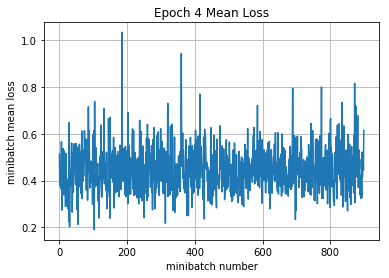

2017-10-25 17:24:21 Iter 3600: batch trn loss = 0.490, accuracy = 0.840
2017-10-25 17:24:42 Iter 3700: batch trn loss = 0.491, accuracy = 0.820
2017-10-25 17:25:02 Iter 3800: batch trn loss = 0.520, accuracy = 0.880
2017-10-25 17:25:22 Iter 3900: batch trn loss = 0.579, accuracy = 0.840
2017-10-25 17:25:43 Iter 4000: batch trn loss = 0.520, accuracy = 0.840
2017-10-25 17:26:03 Iter 4100: batch trn loss = 0.431, accuracy = 0.880
2017-10-25 17:26:23 Iter 4200: batch trn loss = 0.606, accuracy = 0.800
2017-10-25 17:26:44 Iter 4300: batch trn loss = 0.478, accuracy = 0.860
2017-10-25 17:27:04 Iter 4400: batch trn loss = 0.410, accuracy = 0.840
Epoch 4: mean loss = 0.429, accuracy = 0.872


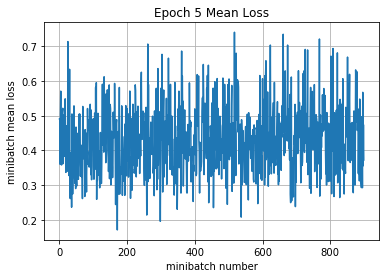

2017-10-25 17:27:24 Iter 4500: batch trn loss = 0.329, accuracy = 0.920
2017-10-25 17:27:45 Iter 4600: batch trn loss = 0.453, accuracy = 0.920
2017-10-25 17:28:05 Iter 4700: batch trn loss = 0.460, accuracy = 0.800
2017-10-25 17:28:25 Iter 4800: batch trn loss = 0.222, accuracy = 1.000
2017-10-25 17:28:46 Iter 4900: batch trn loss = 0.508, accuracy = 0.820
2017-10-25 17:29:06 Iter 5000: batch trn loss = 0.364, accuracy = 0.900
2017-10-25 17:29:26 Iter 5100: batch trn loss = 0.455, accuracy = 0.840
2017-10-25 17:29:47 Iter 5200: batch trn loss = 0.445, accuracy = 0.820
2017-10-25 17:30:07 Iter 5300: batch trn loss = 0.325, accuracy = 0.880
Epoch 5: mean loss = 0.413, accuracy = 0.879


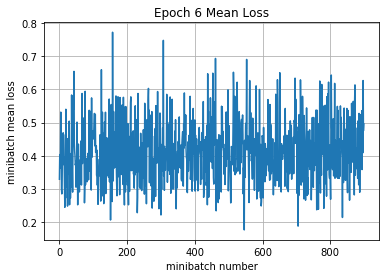

2017-10-25 17:30:27 Iter 5400: batch trn loss = 0.377, accuracy = 0.900
2017-10-25 17:30:47 Iter 5500: batch trn loss = 0.409, accuracy = 0.880
2017-10-25 17:31:09 Iter 5600: batch trn loss = 0.468, accuracy = 0.860
2017-10-25 17:31:33 Iter 5700: batch trn loss = 0.381, accuracy = 0.880
2017-10-25 17:31:54 Iter 5800: batch trn loss = 0.399, accuracy = 0.880
2017-10-25 17:32:15 Iter 5900: batch trn loss = 0.316, accuracy = 0.940
2017-10-25 17:32:35 Iter 6000: batch trn loss = 0.510, accuracy = 0.840
2017-10-25 17:32:56 Iter 6100: batch trn loss = 0.360, accuracy = 0.900
2017-10-25 17:33:16 Iter 6200: batch trn loss = 0.382, accuracy = 0.940
Epoch 6: mean loss = 0.395, accuracy = 0.887


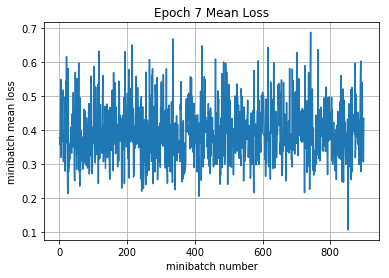

2017-10-25 17:33:36 Iter 6300: batch trn loss = 0.338, accuracy = 0.900
2017-10-25 17:33:58 Iter 6400: batch trn loss = 0.414, accuracy = 0.860
2017-10-25 17:34:22 Iter 6500: batch trn loss = 0.299, accuracy = 0.940
2017-10-25 17:34:44 Iter 6600: batch trn loss = 0.366, accuracy = 0.860
2017-10-25 17:35:07 Iter 6700: batch trn loss = 0.345, accuracy = 0.900
2017-10-25 17:35:28 Iter 6800: batch trn loss = 0.527, accuracy = 0.840
2017-10-25 17:35:49 Iter 6900: batch trn loss = 0.484, accuracy = 0.860
2017-10-25 17:36:10 Iter 7000: batch trn loss = 0.288, accuracy = 0.900
2017-10-25 17:36:30 Iter 7100: batch trn loss = 0.319, accuracy = 0.900
Epoch 7: mean loss = 0.378, accuracy = 0.892


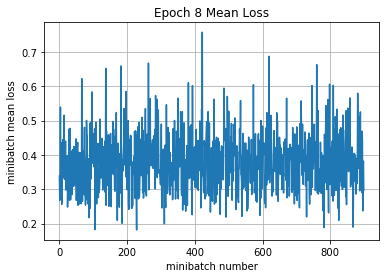

2017-10-25 17:36:51 Iter 7200: batch trn loss = 0.197, accuracy = 0.960
2017-10-25 17:37:11 Iter 7300: batch trn loss = 0.383, accuracy = 0.860
2017-10-25 17:37:31 Iter 7400: batch trn loss = 0.319, accuracy = 0.900
2017-10-25 17:37:52 Iter 7500: batch trn loss = 0.371, accuracy = 0.880
2017-10-25 17:38:12 Iter 7600: batch trn loss = 0.361, accuracy = 0.900
2017-10-25 17:38:33 Iter 7700: batch trn loss = 0.378, accuracy = 0.880
2017-10-25 17:38:53 Iter 7800: batch trn loss = 0.238, accuracy = 0.960
2017-10-25 17:39:13 Iter 7900: batch trn loss = 0.281, accuracy = 0.920
2017-10-25 17:39:34 Iter 8000: batch trn loss = 0.303, accuracy = 0.940
Epoch 8: mean loss = 0.362, accuracy = 0.898


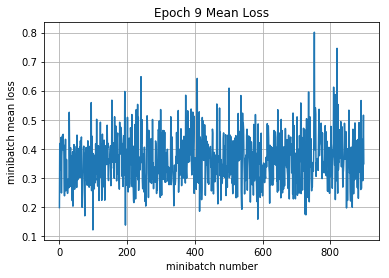

2017-10-25 17:39:55 Iter 8100: batch trn loss = 0.225, accuracy = 0.980
2017-10-25 17:40:15 Iter 8200: batch trn loss = 0.297, accuracy = 0.940
2017-10-25 17:40:35 Iter 8300: batch trn loss = 0.312, accuracy = 0.920
2017-10-25 17:40:55 Iter 8400: batch trn loss = 0.332, accuracy = 0.900
2017-10-25 17:41:16 Iter 8500: batch trn loss = 0.299, accuracy = 0.940
2017-10-25 17:41:36 Iter 8600: batch trn loss = 0.255, accuracy = 0.920
2017-10-25 17:41:56 Iter 8700: batch trn loss = 0.384, accuracy = 0.900
2017-10-25 17:42:17 Iter 8800: batch trn loss = 0.317, accuracy = 0.920
2017-10-25 17:42:37 Iter 8900: batch trn loss = 0.497, accuracy = 0.860
Epoch 9: mean loss = 0.347, accuracy = 0.904


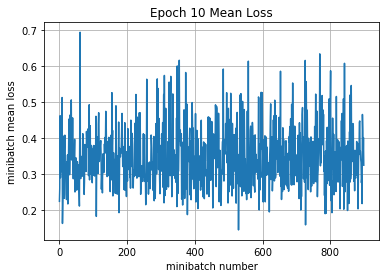

validation
Epoch 0: mean loss = 1.076, accuracy = 0.659


In [63]:
# continue on training for 10 more epochs to see if there will be any increase
# even worse
# trn: 0.904, val: 0.659

print('train')
cnn.train(X_trn, y_trn, epochs=10, batch_size=50, print_every=100, plot_losses=True)
print('validation')
cnn.validate(X_val, y_val, epochs=1, batch_size=50)

## omit the first pooling layer, worse
trn: 0.959, val: 0.669 (20 epochs)

16384
train
2017-10-25 17:47:25 Iter 0: batch trn loss = 2.981, accuracy = 0.060
2017-10-25 17:48:20 Iter 100: batch trn loss = 2.195, accuracy = 0.160
2017-10-25 17:49:15 Iter 200: batch trn loss = 1.785, accuracy = 0.340
2017-10-25 17:50:09 Iter 300: batch trn loss = 1.835, accuracy = 0.380
2017-10-25 17:51:03 Iter 400: batch trn loss = 1.559, accuracy = 0.480
2017-10-25 17:51:58 Iter 500: batch trn loss = 1.593, accuracy = 0.480
2017-10-25 17:52:52 Iter 600: batch trn loss = 1.785, accuracy = 0.520
2017-10-25 17:53:45 Iter 700: batch trn loss = 1.485, accuracy = 0.540
2017-10-25 17:54:39 Iter 800: batch trn loss = 1.498, accuracy = 0.540
Epoch 0: mean loss = 1.693, accuracy = 0.426


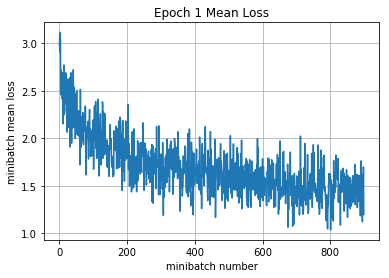

2017-10-25 17:55:33 Iter 900: batch trn loss = 1.496, accuracy = 0.520
2017-10-25 17:56:26 Iter 1000: batch trn loss = 1.316, accuracy = 0.620
2017-10-25 17:57:20 Iter 1100: batch trn loss = 1.582, accuracy = 0.460
2017-10-25 17:58:14 Iter 1200: batch trn loss = 1.334, accuracy = 0.540
2017-10-25 17:59:08 Iter 1300: batch trn loss = 1.160, accuracy = 0.580
2017-10-25 18:00:01 Iter 1400: batch trn loss = 1.447, accuracy = 0.460
2017-10-25 18:00:55 Iter 1500: batch trn loss = 1.393, accuracy = 0.460
2017-10-25 18:01:51 Iter 1600: batch trn loss = 1.117, accuracy = 0.660
2017-10-25 18:02:44 Iter 1700: batch trn loss = 1.343, accuracy = 0.620
Epoch 1: mean loss = 1.273, accuracy = 0.557


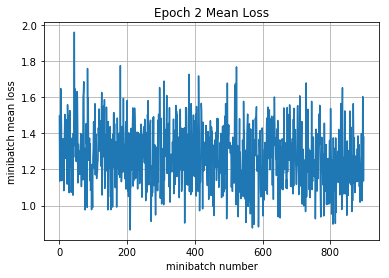

2017-10-25 18:03:38 Iter 1800: batch trn loss = 1.045, accuracy = 0.660
2017-10-25 18:04:32 Iter 1900: batch trn loss = 1.055, accuracy = 0.680
2017-10-25 18:05:25 Iter 2000: batch trn loss = 0.898, accuracy = 0.740
2017-10-25 18:06:19 Iter 2100: batch trn loss = 1.179, accuracy = 0.600
2017-10-25 18:07:13 Iter 2200: batch trn loss = 1.286, accuracy = 0.580
2017-10-25 18:08:07 Iter 2300: batch trn loss = 0.943, accuracy = 0.660
2017-10-25 18:09:00 Iter 2400: batch trn loss = 0.871, accuracy = 0.720
2017-10-25 18:09:54 Iter 2500: batch trn loss = 1.173, accuracy = 0.640
2017-10-25 18:10:47 Iter 2600: batch trn loss = 1.060, accuracy = 0.660
Epoch 2: mean loss = 1.112, accuracy = 0.613


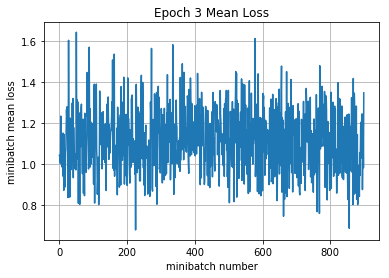

2017-10-25 18:11:41 Iter 2700: batch trn loss = 1.017, accuracy = 0.540
2017-10-25 18:12:36 Iter 2800: batch trn loss = 0.949, accuracy = 0.660
2017-10-25 18:13:32 Iter 2900: batch trn loss = 1.305, accuracy = 0.600
2017-10-25 18:14:26 Iter 3000: batch trn loss = 0.875, accuracy = 0.720
2017-10-25 18:15:20 Iter 3100: batch trn loss = 1.008, accuracy = 0.620
2017-10-25 18:16:14 Iter 3200: batch trn loss = 1.062, accuracy = 0.700
2017-10-25 18:17:08 Iter 3300: batch trn loss = 1.095, accuracy = 0.620
2017-10-25 18:18:03 Iter 3400: batch trn loss = 1.153, accuracy = 0.580
2017-10-25 18:19:00 Iter 3500: batch trn loss = 0.697, accuracy = 0.760
Epoch 3: mean loss = 0.993, accuracy = 0.657


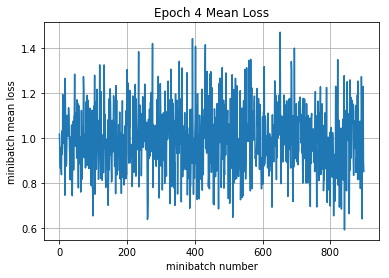

2017-10-25 18:19:56 Iter 3600: batch trn loss = 0.920, accuracy = 0.640
2017-10-25 18:20:53 Iter 3700: batch trn loss = 0.899, accuracy = 0.660
2017-10-25 18:21:57 Iter 3800: batch trn loss = 0.914, accuracy = 0.680
2017-10-25 18:22:58 Iter 3900: batch trn loss = 0.837, accuracy = 0.680
2017-10-25 18:23:53 Iter 4000: batch trn loss = 0.893, accuracy = 0.680
2017-10-25 18:24:50 Iter 4100: batch trn loss = 1.101, accuracy = 0.600
2017-10-25 18:25:48 Iter 4200: batch trn loss = 1.130, accuracy = 0.600
2017-10-25 18:26:42 Iter 4300: batch trn loss = 0.847, accuracy = 0.760
2017-10-25 18:27:38 Iter 4400: batch trn loss = 0.908, accuracy = 0.680
Epoch 4: mean loss = 0.898, accuracy = 0.692


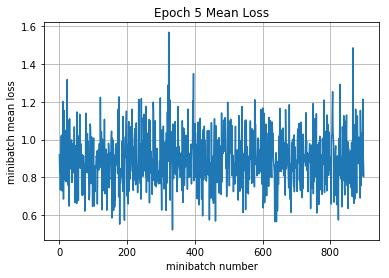

2017-10-25 18:28:34 Iter 4500: batch trn loss = 0.968, accuracy = 0.660
2017-10-25 18:29:34 Iter 4600: batch trn loss = 0.900, accuracy = 0.680
2017-10-25 18:30:30 Iter 4700: batch trn loss = 1.054, accuracy = 0.640
2017-10-25 18:31:35 Iter 4800: batch trn loss = 0.985, accuracy = 0.640
2017-10-25 18:32:31 Iter 4900: batch trn loss = 0.858, accuracy = 0.700
2017-10-25 18:33:32 Iter 5000: batch trn loss = 0.738, accuracy = 0.740
2017-10-25 18:34:31 Iter 5100: batch trn loss = 0.933, accuracy = 0.680
2017-10-25 18:35:28 Iter 5200: batch trn loss = 0.889, accuracy = 0.640
2017-10-25 18:36:24 Iter 5300: batch trn loss = 0.745, accuracy = 0.760
Epoch 5: mean loss = 0.818, accuracy = 0.724


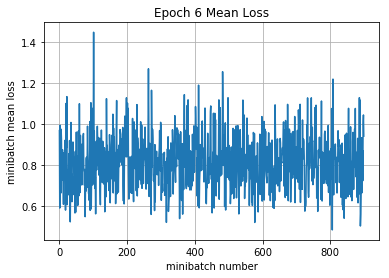

2017-10-25 18:37:20 Iter 5400: batch trn loss = 0.709, accuracy = 0.740
2017-10-25 18:38:16 Iter 5500: batch trn loss = 0.861, accuracy = 0.780
2017-10-25 18:39:14 Iter 5600: batch trn loss = 0.943, accuracy = 0.680
2017-10-25 18:40:11 Iter 5700: batch trn loss = 0.815, accuracy = 0.660
2017-10-25 18:41:07 Iter 5800: batch trn loss = 0.779, accuracy = 0.780
2017-10-25 18:42:09 Iter 5900: batch trn loss = 0.843, accuracy = 0.740
2017-10-25 18:43:04 Iter 6000: batch trn loss = 0.716, accuracy = 0.800
2017-10-25 18:43:58 Iter 6100: batch trn loss = 0.521, accuracy = 0.860
2017-10-25 18:44:53 Iter 6200: batch trn loss = 0.843, accuracy = 0.680
Epoch 6: mean loss = 0.747, accuracy = 0.751


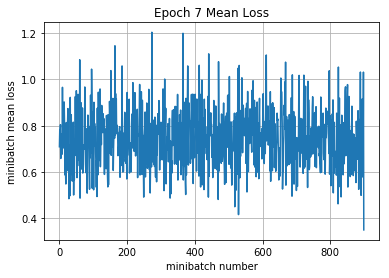

2017-10-25 18:45:48 Iter 6300: batch trn loss = 0.474, accuracy = 0.880
2017-10-25 18:46:43 Iter 6400: batch trn loss = 0.665, accuracy = 0.720
2017-10-25 18:47:38 Iter 6500: batch trn loss = 0.668, accuracy = 0.760
2017-10-25 18:48:33 Iter 6600: batch trn loss = 0.679, accuracy = 0.760
2017-10-25 18:49:28 Iter 6700: batch trn loss = 0.689, accuracy = 0.720
2017-10-25 18:50:22 Iter 6800: batch trn loss = 0.661, accuracy = 0.760
2017-10-25 18:51:17 Iter 6900: batch trn loss = 0.703, accuracy = 0.800
2017-10-25 18:52:12 Iter 7000: batch trn loss = 0.596, accuracy = 0.800
2017-10-25 18:53:07 Iter 7100: batch trn loss = 0.688, accuracy = 0.780
Epoch 7: mean loss = 0.682, accuracy = 0.777


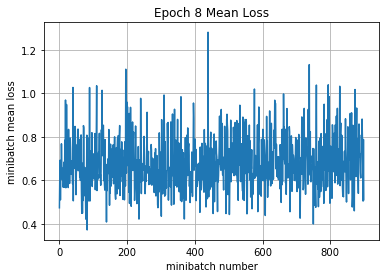

2017-10-25 18:54:03 Iter 7200: batch trn loss = 0.692, accuracy = 0.780
2017-10-25 18:54:59 Iter 7300: batch trn loss = 0.453, accuracy = 0.840
2017-10-25 18:55:54 Iter 7400: batch trn loss = 0.671, accuracy = 0.800
2017-10-25 18:56:49 Iter 7500: batch trn loss = 0.776, accuracy = 0.780
2017-10-25 18:57:43 Iter 7600: batch trn loss = 0.779, accuracy = 0.800
2017-10-25 18:58:38 Iter 7700: batch trn loss = 0.527, accuracy = 0.840
2017-10-25 18:59:32 Iter 7800: batch trn loss = 0.581, accuracy = 0.820
2017-10-25 19:00:27 Iter 7900: batch trn loss = 0.537, accuracy = 0.840
2017-10-25 19:01:27 Iter 8000: batch trn loss = 0.614, accuracy = 0.800
Epoch 8: mean loss = 0.628, accuracy = 0.799


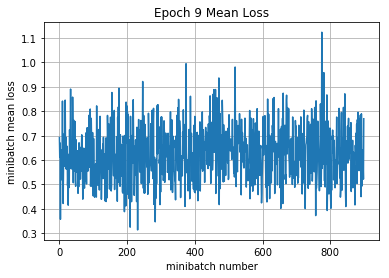

2017-10-25 19:02:22 Iter 8100: batch trn loss = 0.745, accuracy = 0.800
2017-10-25 19:03:17 Iter 8200: batch trn loss = 0.649, accuracy = 0.780
2017-10-25 19:04:12 Iter 8300: batch trn loss = 0.426, accuracy = 0.880
2017-10-25 19:05:08 Iter 8400: batch trn loss = 0.562, accuracy = 0.800
2017-10-25 19:06:02 Iter 8500: batch trn loss = 0.634, accuracy = 0.780
2017-10-25 19:06:59 Iter 8600: batch trn loss = 0.652, accuracy = 0.780
2017-10-25 19:07:55 Iter 8700: batch trn loss = 0.708, accuracy = 0.740
2017-10-25 19:08:51 Iter 8800: batch trn loss = 0.545, accuracy = 0.840
2017-10-25 19:09:57 Iter 8900: batch trn loss = 0.634, accuracy = 0.840
Epoch 9: mean loss = 0.573, accuracy = 0.821


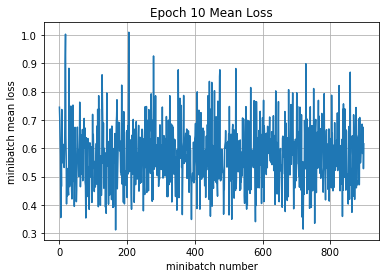

2017-10-25 19:11:00 Iter 9000: batch trn loss = 0.455, accuracy = 0.880
2017-10-25 19:11:55 Iter 9100: batch trn loss = 0.422, accuracy = 0.880
2017-10-25 19:12:51 Iter 9200: batch trn loss = 0.559, accuracy = 0.840
2017-10-25 19:13:46 Iter 9300: batch trn loss = 0.574, accuracy = 0.760
2017-10-25 19:14:40 Iter 9400: batch trn loss = 0.527, accuracy = 0.860
2017-10-25 19:15:35 Iter 9500: batch trn loss = 0.573, accuracy = 0.820
2017-10-25 19:16:33 Iter 9600: batch trn loss = 0.639, accuracy = 0.760
2017-10-25 19:17:28 Iter 9700: batch trn loss = 0.547, accuracy = 0.860
2017-10-25 19:18:27 Iter 9800: batch trn loss = 0.560, accuracy = 0.860
Epoch 10: mean loss = 0.524, accuracy = 0.839


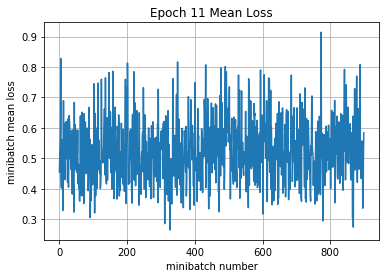

2017-10-25 19:19:23 Iter 9900: batch trn loss = 0.562, accuracy = 0.780
2017-10-25 19:20:18 Iter 10000: batch trn loss = 0.472, accuracy = 0.860
2017-10-25 19:21:13 Iter 10100: batch trn loss = 0.483, accuracy = 0.820
2017-10-25 19:22:08 Iter 10200: batch trn loss = 0.589, accuracy = 0.840
2017-10-25 19:23:04 Iter 10300: batch trn loss = 0.437, accuracy = 0.880
2017-10-25 19:23:59 Iter 10400: batch trn loss = 0.461, accuracy = 0.880
2017-10-25 19:24:54 Iter 10500: batch trn loss = 0.364, accuracy = 0.920
2017-10-25 19:25:55 Iter 10600: batch trn loss = 0.495, accuracy = 0.880
2017-10-25 19:26:50 Iter 10700: batch trn loss = 0.417, accuracy = 0.820
Epoch 11: mean loss = 0.479, accuracy = 0.858


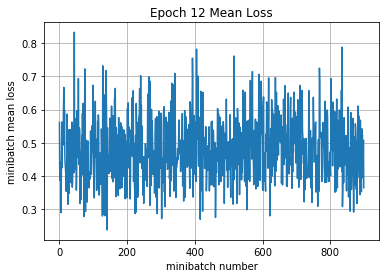

2017-10-25 19:27:45 Iter 10800: batch trn loss = 0.366, accuracy = 0.900
2017-10-25 19:28:40 Iter 10900: batch trn loss = 0.405, accuracy = 0.840
2017-10-25 19:29:36 Iter 11000: batch trn loss = 0.368, accuracy = 0.920
2017-10-25 19:30:31 Iter 11100: batch trn loss = 0.346, accuracy = 0.900
2017-10-25 19:31:30 Iter 11200: batch trn loss = 0.591, accuracy = 0.800
2017-10-25 19:32:26 Iter 11300: batch trn loss = 0.340, accuracy = 0.960
2017-10-25 19:33:21 Iter 11400: batch trn loss = 0.503, accuracy = 0.840
2017-10-25 19:34:16 Iter 11500: batch trn loss = 0.587, accuracy = 0.840
2017-10-25 19:35:12 Iter 11600: batch trn loss = 0.564, accuracy = 0.860
Epoch 12: mean loss = 0.435, accuracy = 0.875


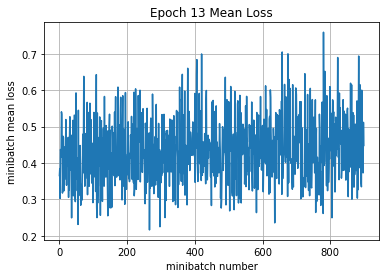

2017-10-25 19:36:07 Iter 11700: batch trn loss = 0.300, accuracy = 0.940
2017-10-25 19:37:03 Iter 11800: batch trn loss = 0.466, accuracy = 0.860
2017-10-25 19:37:59 Iter 11900: batch trn loss = 0.313, accuracy = 0.900
2017-10-25 19:38:55 Iter 12000: batch trn loss = 0.273, accuracy = 0.960
2017-10-25 19:39:51 Iter 12100: batch trn loss = 0.290, accuracy = 0.920
2017-10-25 19:40:48 Iter 12200: batch trn loss = 0.402, accuracy = 0.920
2017-10-25 19:41:46 Iter 12300: batch trn loss = 0.471, accuracy = 0.860
2017-10-25 19:42:43 Iter 12400: batch trn loss = 0.384, accuracy = 0.880
2017-10-25 19:43:38 Iter 12500: batch trn loss = 0.353, accuracy = 0.920
Epoch 13: mean loss = 0.397, accuracy = 0.892


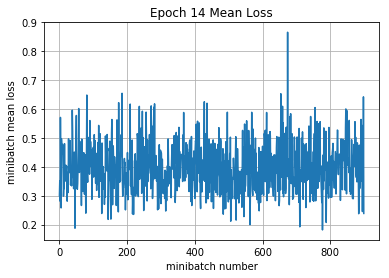

2017-10-25 19:44:35 Iter 12600: batch trn loss = 0.221, accuracy = 0.960
2017-10-25 19:45:33 Iter 12700: batch trn loss = 0.385, accuracy = 0.920
2017-10-25 19:46:30 Iter 12800: batch trn loss = 0.277, accuracy = 0.960
2017-10-25 19:47:29 Iter 12900: batch trn loss = 0.271, accuracy = 0.920
2017-10-25 19:48:24 Iter 13000: batch trn loss = 0.408, accuracy = 0.880
2017-10-25 19:49:19 Iter 13100: batch trn loss = 0.377, accuracy = 0.900
2017-10-25 19:50:16 Iter 13200: batch trn loss = 0.302, accuracy = 0.960
2017-10-25 19:51:14 Iter 13300: batch trn loss = 0.345, accuracy = 0.940
2017-10-25 19:52:15 Iter 13400: batch trn loss = 0.291, accuracy = 0.940
Epoch 14: mean loss = 0.359, accuracy = 0.909


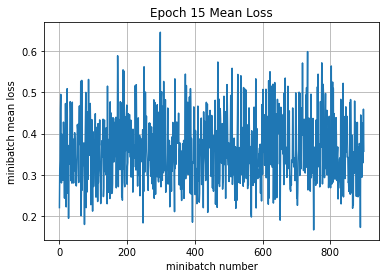

2017-10-25 19:53:18 Iter 13500: batch trn loss = 0.272, accuracy = 0.960
2017-10-25 19:54:15 Iter 13600: batch trn loss = 0.283, accuracy = 0.900
2017-10-25 19:55:12 Iter 13700: batch trn loss = 0.341, accuracy = 0.900
2017-10-25 19:56:07 Iter 13800: batch trn loss = 0.443, accuracy = 0.860
2017-10-25 19:57:06 Iter 13900: batch trn loss = 0.386, accuracy = 0.860
2017-10-25 19:58:04 Iter 14000: batch trn loss = 0.260, accuracy = 0.960
2017-10-25 19:59:00 Iter 14100: batch trn loss = 0.227, accuracy = 0.980
2017-10-25 19:59:58 Iter 14200: batch trn loss = 0.352, accuracy = 0.900
2017-10-25 20:00:53 Iter 14300: batch trn loss = 0.252, accuracy = 0.980
Epoch 15: mean loss = 0.328, accuracy = 0.919


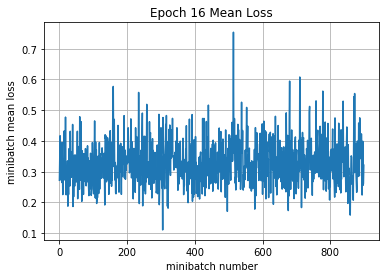

2017-10-25 20:01:52 Iter 14400: batch trn loss = 0.264, accuracy = 0.980
2017-10-25 20:02:47 Iter 14500: batch trn loss = 0.302, accuracy = 0.900
2017-10-25 20:03:41 Iter 14600: batch trn loss = 0.281, accuracy = 0.900
2017-10-25 20:04:36 Iter 14700: batch trn loss = 0.293, accuracy = 0.920
2017-10-25 20:05:31 Iter 14800: batch trn loss = 0.224, accuracy = 0.940
2017-10-25 20:06:27 Iter 14900: batch trn loss = 0.411, accuracy = 0.920
2017-10-25 20:07:24 Iter 15000: batch trn loss = 0.212, accuracy = 0.980
2017-10-25 20:08:19 Iter 15100: batch trn loss = 0.295, accuracy = 0.960
2017-10-25 20:09:14 Iter 15200: batch trn loss = 0.350, accuracy = 0.900
Epoch 16: mean loss = 0.299, accuracy = 0.931


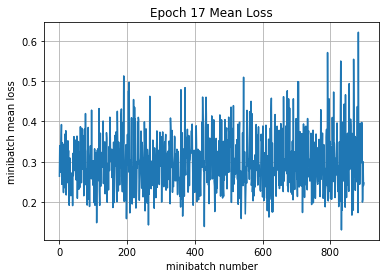

2017-10-25 20:10:09 Iter 15300: batch trn loss = 0.431, accuracy = 0.880
2017-10-25 20:11:04 Iter 15400: batch trn loss = 0.252, accuracy = 0.960
2017-10-25 20:12:01 Iter 15500: batch trn loss = 0.250, accuracy = 0.960
2017-10-25 20:12:58 Iter 15600: batch trn loss = 0.231, accuracy = 0.960
2017-10-25 20:13:54 Iter 15700: batch trn loss = 0.221, accuracy = 0.980
2017-10-25 20:14:49 Iter 15800: batch trn loss = 0.261, accuracy = 0.940
2017-10-25 20:15:43 Iter 15900: batch trn loss = 0.280, accuracy = 0.920
2017-10-25 20:16:38 Iter 16000: batch trn loss = 0.286, accuracy = 0.940
2017-10-25 20:17:33 Iter 16100: batch trn loss = 0.257, accuracy = 0.940
Epoch 17: mean loss = 0.270, accuracy = 0.942


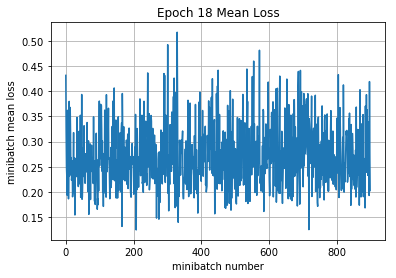

2017-10-25 20:18:28 Iter 16200: batch trn loss = 0.279, accuracy = 0.920
2017-10-25 20:19:23 Iter 16300: batch trn loss = 0.212, accuracy = 0.960
2017-10-25 20:20:17 Iter 16400: batch trn loss = 0.179, accuracy = 0.980
2017-10-25 20:21:12 Iter 16500: batch trn loss = 0.286, accuracy = 0.920
2017-10-25 20:22:07 Iter 16600: batch trn loss = 0.199, accuracy = 0.980
2017-10-25 20:23:02 Iter 16700: batch trn loss = 0.233, accuracy = 0.960
2017-10-25 20:23:58 Iter 16800: batch trn loss = 0.242, accuracy = 0.960
2017-10-25 20:24:53 Iter 16900: batch trn loss = 0.204, accuracy = 0.960
2017-10-25 20:25:48 Iter 17000: batch trn loss = 0.161, accuracy = 0.980
Epoch 18: mean loss = 0.248, accuracy = 0.949


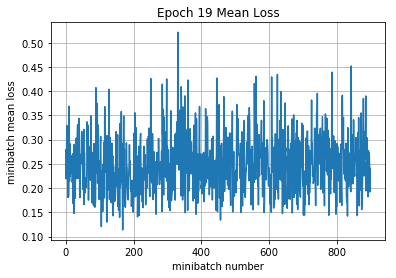

2017-10-25 20:26:43 Iter 17100: batch trn loss = 0.213, accuracy = 0.960
2017-10-25 20:27:39 Iter 17200: batch trn loss = 0.179, accuracy = 0.980
2017-10-25 20:28:35 Iter 17300: batch trn loss = 0.205, accuracy = 0.960
2017-10-25 20:29:32 Iter 17400: batch trn loss = 0.195, accuracy = 0.960
2017-10-25 20:30:27 Iter 17500: batch trn loss = 0.166, accuracy = 1.000
2017-10-25 20:31:25 Iter 17600: batch trn loss = 0.206, accuracy = 0.980
2017-10-25 20:32:23 Iter 17700: batch trn loss = 0.205, accuracy = 0.980
2017-10-25 20:33:18 Iter 17800: batch trn loss = 0.165, accuracy = 0.980
2017-10-25 20:34:14 Iter 17900: batch trn loss = 0.259, accuracy = 0.940
Epoch 19: mean loss = 0.223, accuracy = 0.959


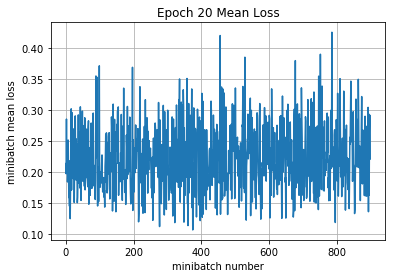

validation
Epoch 0: mean loss = 1.020, accuracy = 0.669


In [65]:
def model_fn(layer_input, labels, is_training):
    # conv - bn - max_pool
    F1 = 32
    layer = tf.layers.conv2d(inputs=layer_input, filters=F1, kernel_size=[5, 5], padding='same', activation=tf.nn.relu)
    layer = tf.layers.batch_normalization(inputs=layer, training=is_training)
    # layer = tf.layers.max_pooling2d(inputs=layer, pool_size=[2, 2], strides=2)
    # conv - bn - max_pool
    F2 = 64
    layer = tf.layers.conv2d(inputs=layer, filters=F2, kernel_size=[5, 5], padding='same', activation=tf.nn.relu)
    layer = tf.layers.batch_normalization(inputs=layer, training=is_training)
    layer = tf.layers.max_pooling2d(inputs=layer, pool_size=[2, 2], strides=2)
    # dense1 - bn - softmax
    flat_size = int(H / 2 * W / 2 * F2)
    print(flat_size)
    layer = tf.reshape(layer, [-1, flat_size])
    layer = tf.layers.dense(inputs=layer, units=1024, activation=tf.nn.relu)
    layer = tf.layers.batch_normalization(inputs=layer, training=is_training)
    # layer_dropout = tf.layers.dropout(inputs=layer_dense, rate=0.4)
    # no activation here for logit, as it will be calculated in loss
    logit = tf.layers.dense(inputs=layer, units=T, activation=None)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int64), depth=10)
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=logit)
    return logit, loss

trainer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
cnn = CNN(model_fn, trainer)
print('train')
cnn.train(X_trn, y_trn, epochs=20, batch_size=50, print_every=100, plot_losses=True)
print('validation')
cnn.validate(X_val, y_val, epochs=1, batch_size=y_val.shape[0])

## Adjust FC to 512 with BN, add another 64 FC with BN
trn: 0.933, val: 0.668 (40 epochs)

4096
train
2017-10-25 21:00:34 Iter 0: batch trn loss = 2.947, accuracy = 0.200
2017-10-25 21:00:56 Iter 100: batch trn loss = 2.195, accuracy = 0.260
2017-10-25 21:01:18 Iter 200: batch trn loss = 1.791, accuracy = 0.280
2017-10-25 21:01:39 Iter 300: batch trn loss = 1.981, accuracy = 0.360
2017-10-25 21:01:59 Iter 400: batch trn loss = 1.992, accuracy = 0.320
2017-10-25 21:02:19 Iter 500: batch trn loss = 1.687, accuracy = 0.360
2017-10-25 21:02:39 Iter 600: batch trn loss = 1.533, accuracy = 0.440
2017-10-25 21:02:59 Iter 700: batch trn loss = 1.582, accuracy = 0.460
2017-10-25 21:03:19 Iter 800: batch trn loss = 1.785, accuracy = 0.360
Epoch 0: mean loss = 1.890, accuracy = 0.350


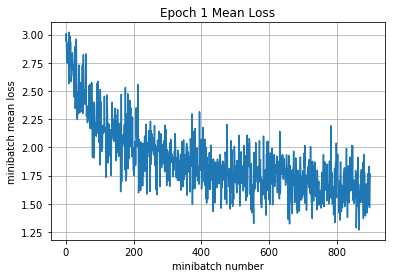

2017-10-25 21:03:39 Iter 900: batch trn loss = 1.623, accuracy = 0.520
2017-10-25 21:03:59 Iter 1000: batch trn loss = 1.672, accuracy = 0.420
2017-10-25 21:04:19 Iter 1100: batch trn loss = 1.583, accuracy = 0.420
2017-10-25 21:04:38 Iter 1200: batch trn loss = 1.590, accuracy = 0.500
2017-10-25 21:04:59 Iter 1300: batch trn loss = 1.267, accuracy = 0.560
2017-10-25 21:05:20 Iter 1400: batch trn loss = 1.387, accuracy = 0.480
2017-10-25 21:05:39 Iter 1500: batch trn loss = 1.317, accuracy = 0.480
2017-10-25 21:05:59 Iter 1600: batch trn loss = 1.201, accuracy = 0.560
2017-10-25 21:06:19 Iter 1700: batch trn loss = 1.538, accuracy = 0.460
Epoch 1: mean loss = 1.496, accuracy = 0.473


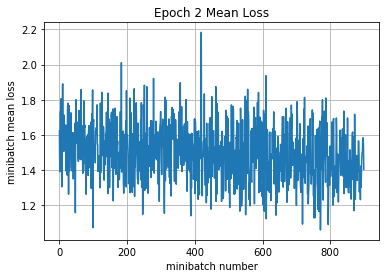

2017-10-25 21:06:40 Iter 1800: batch trn loss = 1.330, accuracy = 0.520
2017-10-25 21:06:59 Iter 1900: batch trn loss = 1.335, accuracy = 0.540
2017-10-25 21:07:19 Iter 2000: batch trn loss = 1.665, accuracy = 0.480
2017-10-25 21:07:39 Iter 2100: batch trn loss = 1.512, accuracy = 0.420
2017-10-25 21:07:59 Iter 2200: batch trn loss = 1.192, accuracy = 0.580
2017-10-25 21:08:19 Iter 2300: batch trn loss = 1.261, accuracy = 0.660
2017-10-25 21:08:39 Iter 2400: batch trn loss = 1.319, accuracy = 0.540
2017-10-25 21:08:58 Iter 2500: batch trn loss = 1.225, accuracy = 0.480
2017-10-25 21:09:17 Iter 2600: batch trn loss = 1.451, accuracy = 0.580
Epoch 2: mean loss = 1.356, accuracy = 0.522


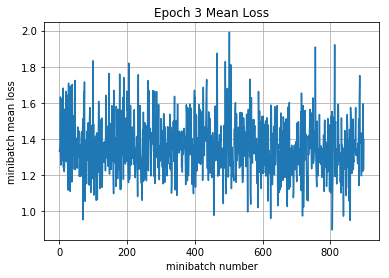

2017-10-25 21:09:37 Iter 2700: batch trn loss = 1.249, accuracy = 0.560
2017-10-25 21:09:56 Iter 2800: batch trn loss = 1.266, accuracy = 0.520
2017-10-25 21:10:16 Iter 2900: batch trn loss = 1.157, accuracy = 0.600
2017-10-25 21:10:35 Iter 3000: batch trn loss = 1.193, accuracy = 0.640
2017-10-25 21:10:54 Iter 3100: batch trn loss = 1.221, accuracy = 0.580
2017-10-25 21:11:15 Iter 3200: batch trn loss = 1.318, accuracy = 0.500
2017-10-25 21:11:34 Iter 3300: batch trn loss = 1.317, accuracy = 0.440
2017-10-25 21:11:54 Iter 3400: batch trn loss = 1.309, accuracy = 0.560
2017-10-25 21:12:14 Iter 3500: batch trn loss = 1.162, accuracy = 0.560
Epoch 3: mean loss = 1.261, accuracy = 0.558


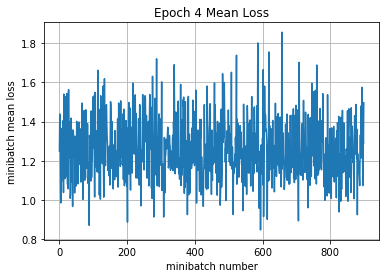

2017-10-25 21:12:35 Iter 3600: batch trn loss = 1.122, accuracy = 0.560
2017-10-25 21:12:56 Iter 3700: batch trn loss = 0.998, accuracy = 0.700
2017-10-25 21:13:16 Iter 3800: batch trn loss = 1.116, accuracy = 0.580
2017-10-25 21:13:35 Iter 3900: batch trn loss = 1.287, accuracy = 0.560
2017-10-25 21:13:55 Iter 4000: batch trn loss = 1.032, accuracy = 0.620
2017-10-25 21:14:14 Iter 4100: batch trn loss = 1.374, accuracy = 0.480
2017-10-25 21:14:33 Iter 4200: batch trn loss = 1.322, accuracy = 0.520
2017-10-25 21:14:53 Iter 4300: batch trn loss = 1.377, accuracy = 0.500
2017-10-25 21:15:12 Iter 4400: batch trn loss = 1.445, accuracy = 0.460
Epoch 4: mean loss = 1.188, accuracy = 0.584


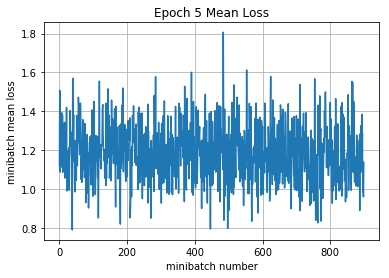

2017-10-25 21:15:31 Iter 4500: batch trn loss = 1.041, accuracy = 0.640
2017-10-25 21:15:51 Iter 4600: batch trn loss = 1.110, accuracy = 0.580
2017-10-25 21:16:10 Iter 4700: batch trn loss = 1.066, accuracy = 0.660
2017-10-25 21:16:30 Iter 4800: batch trn loss = 1.035, accuracy = 0.700
2017-10-25 21:16:49 Iter 4900: batch trn loss = 1.035, accuracy = 0.640
2017-10-25 21:17:09 Iter 5000: batch trn loss = 1.137, accuracy = 0.560
2017-10-25 21:17:29 Iter 5100: batch trn loss = 1.016, accuracy = 0.680
2017-10-25 21:17:48 Iter 5200: batch trn loss = 1.048, accuracy = 0.620
2017-10-25 21:18:08 Iter 5300: batch trn loss = 1.417, accuracy = 0.540
Epoch 5: mean loss = 1.124, accuracy = 0.610


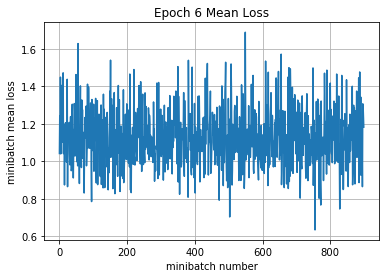

2017-10-25 21:18:29 Iter 5400: batch trn loss = 1.097, accuracy = 0.620
2017-10-25 21:18:49 Iter 5500: batch trn loss = 1.273, accuracy = 0.580
2017-10-25 21:19:09 Iter 5600: batch trn loss = 1.088, accuracy = 0.600
2017-10-25 21:19:28 Iter 5700: batch trn loss = 1.135, accuracy = 0.580
2017-10-25 21:19:48 Iter 5800: batch trn loss = 1.030, accuracy = 0.640
2017-10-25 21:20:08 Iter 5900: batch trn loss = 0.950, accuracy = 0.660
2017-10-25 21:20:28 Iter 6000: batch trn loss = 1.013, accuracy = 0.640
2017-10-25 21:20:47 Iter 6100: batch trn loss = 1.109, accuracy = 0.600
2017-10-25 21:21:07 Iter 6200: batch trn loss = 1.006, accuracy = 0.660
Epoch 6: mean loss = 1.066, accuracy = 0.632


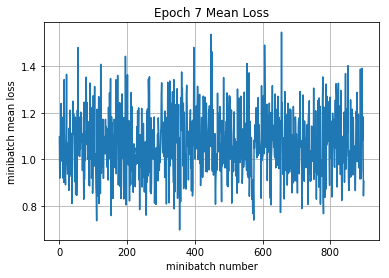

2017-10-25 21:21:26 Iter 6300: batch trn loss = 0.907, accuracy = 0.740
2017-10-25 21:21:46 Iter 6400: batch trn loss = 0.972, accuracy = 0.680
2017-10-25 21:22:06 Iter 6500: batch trn loss = 0.956, accuracy = 0.720
2017-10-25 21:22:26 Iter 6600: batch trn loss = 0.828, accuracy = 0.700
2017-10-25 21:22:45 Iter 6700: batch trn loss = 0.991, accuracy = 0.600
2017-10-25 21:23:06 Iter 6800: batch trn loss = 1.006, accuracy = 0.700
2017-10-25 21:23:26 Iter 6900: batch trn loss = 0.928, accuracy = 0.700
2017-10-25 21:23:46 Iter 7000: batch trn loss = 1.175, accuracy = 0.640
2017-10-25 21:24:06 Iter 7100: batch trn loss = 1.035, accuracy = 0.600
Epoch 7: mean loss = 1.019, accuracy = 0.649


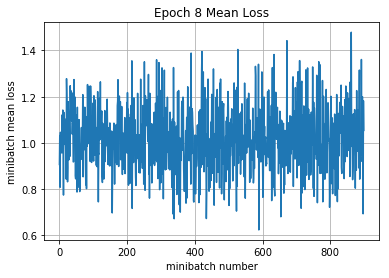

2017-10-25 21:24:26 Iter 7200: batch trn loss = 0.895, accuracy = 0.720
2017-10-25 21:24:46 Iter 7300: batch trn loss = 0.932, accuracy = 0.640
2017-10-25 21:25:06 Iter 7400: batch trn loss = 0.971, accuracy = 0.600
2017-10-25 21:25:25 Iter 7500: batch trn loss = 0.996, accuracy = 0.660
2017-10-25 21:25:45 Iter 7600: batch trn loss = 1.097, accuracy = 0.580
2017-10-25 21:26:05 Iter 7700: batch trn loss = 0.983, accuracy = 0.760
2017-10-25 21:26:24 Iter 7800: batch trn loss = 0.900, accuracy = 0.700
2017-10-25 21:26:44 Iter 7900: batch trn loss = 0.884, accuracy = 0.680
2017-10-25 21:27:03 Iter 8000: batch trn loss = 0.945, accuracy = 0.640
Epoch 8: mean loss = 0.967, accuracy = 0.669


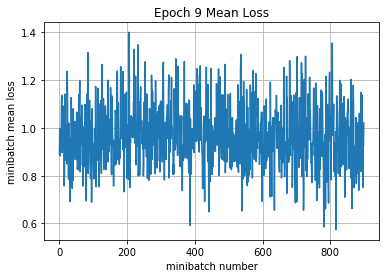

2017-10-25 21:27:23 Iter 8100: batch trn loss = 0.816, accuracy = 0.740
2017-10-25 21:27:42 Iter 8200: batch trn loss = 0.837, accuracy = 0.660
2017-10-25 21:28:02 Iter 8300: batch trn loss = 0.826, accuracy = 0.680
2017-10-25 21:28:21 Iter 8400: batch trn loss = 0.929, accuracy = 0.680
2017-10-25 21:28:41 Iter 8500: batch trn loss = 0.970, accuracy = 0.720
2017-10-25 21:29:01 Iter 8600: batch trn loss = 1.297, accuracy = 0.540
2017-10-25 21:29:20 Iter 8700: batch trn loss = 0.770, accuracy = 0.740
2017-10-25 21:29:40 Iter 8800: batch trn loss = 1.066, accuracy = 0.680
2017-10-25 21:29:59 Iter 8900: batch trn loss = 0.980, accuracy = 0.680
Epoch 9: mean loss = 0.927, accuracy = 0.683


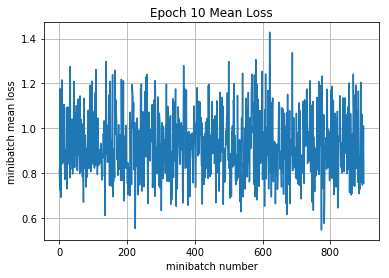

2017-10-25 21:30:19 Iter 9000: batch trn loss = 0.939, accuracy = 0.740
2017-10-25 21:30:39 Iter 9100: batch trn loss = 1.203, accuracy = 0.600
2017-10-25 21:30:59 Iter 9200: batch trn loss = 0.896, accuracy = 0.740
2017-10-25 21:31:19 Iter 9300: batch trn loss = 0.955, accuracy = 0.700
2017-10-25 21:31:39 Iter 9400: batch trn loss = 1.076, accuracy = 0.640
2017-10-25 21:31:59 Iter 9500: batch trn loss = 0.970, accuracy = 0.620
2017-10-25 21:32:18 Iter 9600: batch trn loss = 0.804, accuracy = 0.740
2017-10-25 21:32:38 Iter 9700: batch trn loss = 0.844, accuracy = 0.680
2017-10-25 21:32:57 Iter 9800: batch trn loss = 0.933, accuracy = 0.720
Epoch 10: mean loss = 0.892, accuracy = 0.697


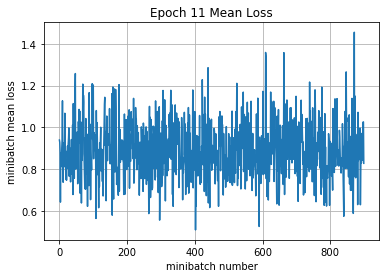

2017-10-25 21:33:17 Iter 9900: batch trn loss = 0.973, accuracy = 0.720
2017-10-25 21:33:36 Iter 10000: batch trn loss = 0.853, accuracy = 0.700
2017-10-25 21:33:55 Iter 10100: batch trn loss = 0.650, accuracy = 0.780
2017-10-25 21:34:15 Iter 10200: batch trn loss = 0.827, accuracy = 0.720
2017-10-25 21:34:34 Iter 10300: batch trn loss = 0.714, accuracy = 0.740
2017-10-25 21:34:54 Iter 10400: batch trn loss = 0.835, accuracy = 0.700
2017-10-25 21:35:13 Iter 10500: batch trn loss = 0.765, accuracy = 0.740
2017-10-25 21:35:33 Iter 10600: batch trn loss = 1.036, accuracy = 0.660
2017-10-25 21:35:52 Iter 10700: batch trn loss = 0.911, accuracy = 0.640
Epoch 11: mean loss = 0.855, accuracy = 0.708


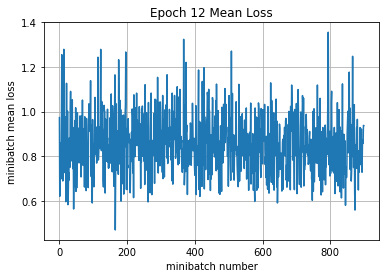

2017-10-25 21:36:13 Iter 10800: batch trn loss = 0.705, accuracy = 0.740
2017-10-25 21:36:33 Iter 10900: batch trn loss = 0.624, accuracy = 0.800
2017-10-25 21:36:53 Iter 11000: batch trn loss = 0.680, accuracy = 0.700
2017-10-25 21:37:13 Iter 11100: batch trn loss = 0.924, accuracy = 0.680
2017-10-25 21:37:33 Iter 11200: batch trn loss = 0.893, accuracy = 0.660
2017-10-25 21:37:53 Iter 11300: batch trn loss = 0.695, accuracy = 0.740
2017-10-25 21:38:12 Iter 11400: batch trn loss = 0.829, accuracy = 0.680
2017-10-25 21:38:32 Iter 11500: batch trn loss = 0.794, accuracy = 0.780
2017-10-25 21:38:52 Iter 11600: batch trn loss = 1.231, accuracy = 0.620
Epoch 12: mean loss = 0.820, accuracy = 0.722


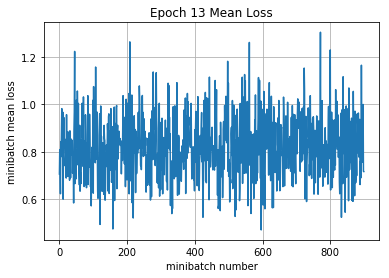

2017-10-25 21:39:12 Iter 11700: batch trn loss = 0.969, accuracy = 0.660
2017-10-25 21:39:32 Iter 11800: batch trn loss = 0.742, accuracy = 0.740
2017-10-25 21:39:52 Iter 11900: batch trn loss = 0.815, accuracy = 0.760
2017-10-25 21:40:11 Iter 12000: batch trn loss = 0.610, accuracy = 0.840
2017-10-25 21:40:31 Iter 12100: batch trn loss = 0.575, accuracy = 0.860
2017-10-25 21:40:51 Iter 12200: batch trn loss = 0.989, accuracy = 0.620
2017-10-25 21:41:10 Iter 12300: batch trn loss = 0.786, accuracy = 0.720
2017-10-25 21:41:30 Iter 12400: batch trn loss = 0.656, accuracy = 0.740
2017-10-25 21:41:50 Iter 12500: batch trn loss = 0.705, accuracy = 0.740
Epoch 13: mean loss = 0.791, accuracy = 0.733


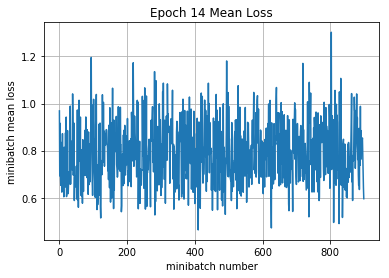

2017-10-25 21:42:09 Iter 12600: batch trn loss = 0.575, accuracy = 0.860
2017-10-25 21:42:29 Iter 12700: batch trn loss = 0.908, accuracy = 0.680
2017-10-25 21:42:49 Iter 12800: batch trn loss = 0.909, accuracy = 0.700
2017-10-25 21:43:09 Iter 12900: batch trn loss = 0.719, accuracy = 0.820
2017-10-25 21:43:29 Iter 13000: batch trn loss = 0.854, accuracy = 0.740
2017-10-25 21:43:51 Iter 13100: batch trn loss = 0.689, accuracy = 0.820
2017-10-25 21:44:11 Iter 13200: batch trn loss = 0.559, accuracy = 0.800
2017-10-25 21:44:33 Iter 13300: batch trn loss = 0.647, accuracy = 0.780
2017-10-25 21:44:53 Iter 13400: batch trn loss = 0.972, accuracy = 0.600
Epoch 14: mean loss = 0.761, accuracy = 0.744


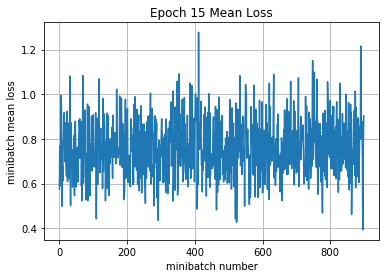

2017-10-25 21:45:13 Iter 13500: batch trn loss = 0.578, accuracy = 0.800
2017-10-25 21:45:34 Iter 13600: batch trn loss = 0.759, accuracy = 0.700
2017-10-25 21:45:54 Iter 13700: batch trn loss = 0.743, accuracy = 0.740
2017-10-25 21:46:14 Iter 13800: batch trn loss = 0.665, accuracy = 0.740
2017-10-25 21:46:34 Iter 13900: batch trn loss = 0.770, accuracy = 0.860
2017-10-25 21:46:53 Iter 14000: batch trn loss = 0.921, accuracy = 0.700
2017-10-25 21:47:14 Iter 14100: batch trn loss = 0.620, accuracy = 0.780
2017-10-25 21:47:35 Iter 14200: batch trn loss = 0.783, accuracy = 0.780
2017-10-25 21:47:55 Iter 14300: batch trn loss = 0.784, accuracy = 0.700
Epoch 15: mean loss = 0.735, accuracy = 0.753


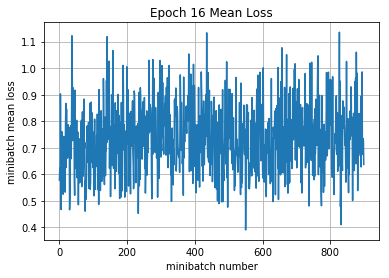

2017-10-25 21:48:15 Iter 14400: batch trn loss = 0.594, accuracy = 0.800
2017-10-25 21:48:34 Iter 14500: batch trn loss = 0.646, accuracy = 0.780
2017-10-25 21:48:54 Iter 14600: batch trn loss = 0.796, accuracy = 0.760
2017-10-25 21:49:13 Iter 14700: batch trn loss = 0.577, accuracy = 0.840
2017-10-25 21:49:33 Iter 14800: batch trn loss = 0.601, accuracy = 0.820
2017-10-25 21:49:52 Iter 14900: batch trn loss = 0.835, accuracy = 0.720
2017-10-25 21:50:11 Iter 15000: batch trn loss = 0.709, accuracy = 0.820
2017-10-25 21:50:31 Iter 15100: batch trn loss = 0.588, accuracy = 0.760
2017-10-25 21:50:50 Iter 15200: batch trn loss = 0.677, accuracy = 0.680
Epoch 16: mean loss = 0.705, accuracy = 0.765


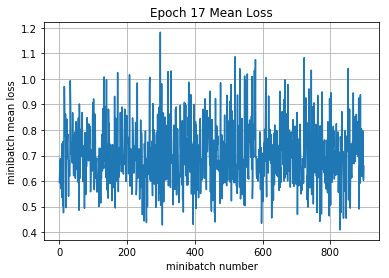

2017-10-25 21:51:10 Iter 15300: batch trn loss = 0.700, accuracy = 0.740
2017-10-25 21:51:29 Iter 15400: batch trn loss = 0.785, accuracy = 0.740
2017-10-25 21:51:49 Iter 15500: batch trn loss = 0.707, accuracy = 0.880
2017-10-25 21:52:08 Iter 15600: batch trn loss = 0.648, accuracy = 0.860
2017-10-25 21:52:28 Iter 15700: batch trn loss = 0.582, accuracy = 0.820
2017-10-25 21:52:48 Iter 15800: batch trn loss = 0.769, accuracy = 0.760
2017-10-25 21:53:08 Iter 15900: batch trn loss = 0.815, accuracy = 0.700
2017-10-25 21:53:27 Iter 16000: batch trn loss = 0.787, accuracy = 0.780
2017-10-25 21:53:47 Iter 16100: batch trn loss = 0.817, accuracy = 0.800
Epoch 17: mean loss = 0.682, accuracy = 0.772


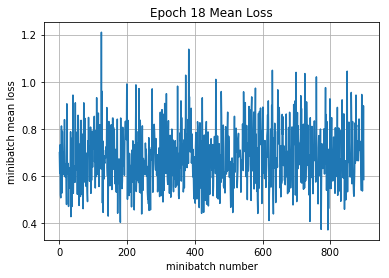

2017-10-25 21:54:06 Iter 16200: batch trn loss = 0.667, accuracy = 0.700
2017-10-25 21:54:26 Iter 16300: batch trn loss = 0.500, accuracy = 0.860
2017-10-25 21:54:45 Iter 16400: batch trn loss = 0.496, accuracy = 0.920
2017-10-25 21:55:05 Iter 16500: batch trn loss = 0.473, accuracy = 0.840
2017-10-25 21:55:24 Iter 16600: batch trn loss = 0.669, accuracy = 0.800
2017-10-25 21:55:44 Iter 16700: batch trn loss = 0.700, accuracy = 0.740
2017-10-25 21:56:03 Iter 16800: batch trn loss = 0.461, accuracy = 0.840
2017-10-25 21:56:23 Iter 16900: batch trn loss = 0.468, accuracy = 0.920
2017-10-25 21:56:43 Iter 17000: batch trn loss = 0.516, accuracy = 0.840
Epoch 18: mean loss = 0.655, accuracy = 0.782


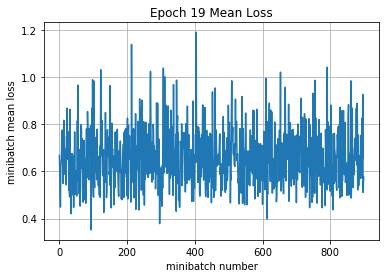

2017-10-25 21:57:02 Iter 17100: batch trn loss = 0.685, accuracy = 0.760
2017-10-25 21:57:22 Iter 17200: batch trn loss = 0.613, accuracy = 0.820
2017-10-25 21:57:42 Iter 17300: batch trn loss = 0.732, accuracy = 0.760
2017-10-25 21:58:01 Iter 17400: batch trn loss = 0.650, accuracy = 0.760
2017-10-25 21:58:21 Iter 17500: batch trn loss = 0.510, accuracy = 0.800
2017-10-25 21:58:41 Iter 17600: batch trn loss = 0.536, accuracy = 0.820
2017-10-25 21:59:01 Iter 17700: batch trn loss = 0.596, accuracy = 0.820
2017-10-25 21:59:22 Iter 17800: batch trn loss = 0.810, accuracy = 0.760
2017-10-25 21:59:43 Iter 17900: batch trn loss = 0.634, accuracy = 0.860
Epoch 19: mean loss = 0.630, accuracy = 0.793


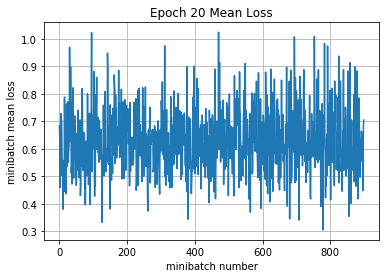

validation
Epoch 0: mean loss = 1.257, accuracy = 0.594


In [66]:
def model_fn(layer_input, labels, is_training):
    # conv - bn - max_pool
    F1 = 32
    layer = tf.layers.conv2d(inputs=layer_input, filters=F1, kernel_size=[5, 5], padding='same', activation=tf.nn.relu)
    layer = tf.layers.batch_normalization(inputs=layer, training=is_training)
    layer = tf.layers.max_pooling2d(inputs=layer, pool_size=[2, 2], strides=2)
    # conv - bn - max_pool
    F2 = 64
    layer = tf.layers.conv2d(inputs=layer, filters=F2, kernel_size=[5, 5], padding='same', activation=tf.nn.relu)
    layer = tf.layers.batch_normalization(inputs=layer, training=is_training)
    layer = tf.layers.max_pooling2d(inputs=layer, pool_size=[2, 2], strides=2)
    # dense1 - bn - dense2 - bn - softmax
    flat_size = int(H / 4 * W / 4 * F2)
    print(flat_size)
    layer = tf.reshape(layer, [-1, flat_size])
    layer = tf.layers.dense(inputs=layer, units=512, activation=tf.nn.relu)
    layer = tf.layers.batch_normalization(inputs=layer, training=is_training)
    layer = tf.layers.dense(inputs=layer, units=64, activation=tf.nn.relu)
    layer = tf.layers.batch_normalization(inputs=layer, training=is_training)
    # layer_dropout = tf.layers.dropout(inputs=layer_dense, rate=0.4)
    # no activation here for logit, as it will be calculated in loss
    logit = tf.layers.dense(inputs=layer, units=T, activation=None)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int64), depth=10)
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=logit)
    return logit, loss

trainer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
cnn = CNN(model_fn, trainer)
print('train')
cnn.train(X_trn, y_trn, epochs=20, batch_size=50, print_every=100, plot_losses=True)
print('validation')
cnn.validate(X_val, y_val, epochs=1, batch_size=y_val.shape[0])

train
2017-10-25 22:25:58 Iter 0: batch trn loss = 0.942, accuracy = 0.700
2017-10-25 22:26:18 Iter 100: batch trn loss = 0.588, accuracy = 0.780
2017-10-25 22:26:38 Iter 200: batch trn loss = 0.477, accuracy = 0.860
2017-10-25 22:26:58 Iter 300: batch trn loss = 0.602, accuracy = 0.820
2017-10-25 22:27:17 Iter 400: batch trn loss = 0.721, accuracy = 0.780
2017-10-25 22:27:37 Iter 500: batch trn loss = 0.657, accuracy = 0.740
2017-10-25 22:27:57 Iter 600: batch trn loss = 0.536, accuracy = 0.860
2017-10-25 22:28:17 Iter 700: batch trn loss = 0.511, accuracy = 0.880
2017-10-25 22:28:37 Iter 800: batch trn loss = 0.623, accuracy = 0.840
Epoch 0: mean loss = 0.605, accuracy = 0.802


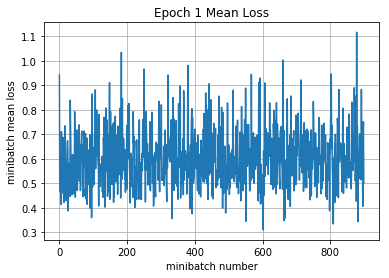

2017-10-25 22:28:57 Iter 900: batch trn loss = 0.541, accuracy = 0.840
2017-10-25 22:29:17 Iter 1000: batch trn loss = 0.410, accuracy = 0.880
2017-10-25 22:29:41 Iter 1100: batch trn loss = 0.551, accuracy = 0.800
2017-10-25 22:30:04 Iter 1200: batch trn loss = 0.453, accuracy = 0.880
2017-10-25 22:30:24 Iter 1300: batch trn loss = 0.554, accuracy = 0.820
2017-10-25 22:30:44 Iter 1400: batch trn loss = 0.656, accuracy = 0.760
2017-10-25 22:31:06 Iter 1500: batch trn loss = 0.464, accuracy = 0.860
2017-10-25 22:31:27 Iter 1600: batch trn loss = 0.643, accuracy = 0.780
2017-10-25 22:31:49 Iter 1700: batch trn loss = 0.492, accuracy = 0.880
Epoch 1: mean loss = 0.579, accuracy = 0.813


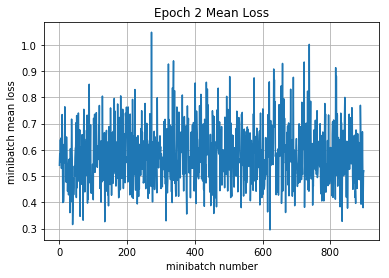

2017-10-25 22:32:12 Iter 1800: batch trn loss = 0.521, accuracy = 0.820
2017-10-25 22:32:32 Iter 1900: batch trn loss = 0.697, accuracy = 0.740
2017-10-25 22:32:55 Iter 2000: batch trn loss = 0.623, accuracy = 0.840
2017-10-25 22:33:16 Iter 2100: batch trn loss = 0.546, accuracy = 0.840
2017-10-25 22:33:38 Iter 2200: batch trn loss = 0.510, accuracy = 0.840
2017-10-25 22:34:00 Iter 2300: batch trn loss = 0.607, accuracy = 0.800
2017-10-25 22:34:21 Iter 2400: batch trn loss = 0.442, accuracy = 0.820
2017-10-25 22:34:40 Iter 2500: batch trn loss = 0.363, accuracy = 0.900
2017-10-25 22:34:59 Iter 2600: batch trn loss = 0.341, accuracy = 0.880
Epoch 2: mean loss = 0.561, accuracy = 0.819


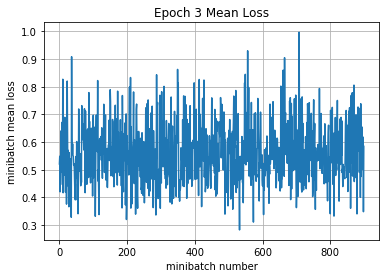

2017-10-25 22:35:18 Iter 2700: batch trn loss = 0.432, accuracy = 0.880
2017-10-25 22:35:37 Iter 2800: batch trn loss = 0.522, accuracy = 0.800
2017-10-25 22:35:56 Iter 2900: batch trn loss = 0.450, accuracy = 0.860
2017-10-25 22:36:14 Iter 3000: batch trn loss = 0.716, accuracy = 0.760
2017-10-25 22:36:33 Iter 3100: batch trn loss = 0.688, accuracy = 0.760
2017-10-25 22:36:52 Iter 3200: batch trn loss = 0.571, accuracy = 0.820
2017-10-25 22:37:11 Iter 3300: batch trn loss = 0.453, accuracy = 0.860
2017-10-25 22:37:31 Iter 3400: batch trn loss = 0.634, accuracy = 0.780
2017-10-25 22:37:50 Iter 3500: batch trn loss = 0.532, accuracy = 0.800
Epoch 3: mean loss = 0.539, accuracy = 0.828


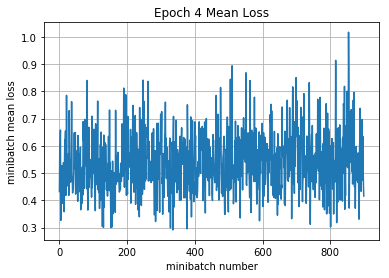

2017-10-25 22:38:10 Iter 3600: batch trn loss = 0.403, accuracy = 0.920
2017-10-25 22:38:29 Iter 3700: batch trn loss = 0.517, accuracy = 0.820
2017-10-25 22:38:48 Iter 3800: batch trn loss = 0.503, accuracy = 0.880
2017-10-25 22:39:07 Iter 3900: batch trn loss = 0.411, accuracy = 0.900
2017-10-25 22:39:26 Iter 4000: batch trn loss = 0.540, accuracy = 0.820
2017-10-25 22:39:45 Iter 4100: batch trn loss = 0.484, accuracy = 0.880
2017-10-25 22:40:04 Iter 4200: batch trn loss = 0.594, accuracy = 0.820
2017-10-25 22:40:23 Iter 4300: batch trn loss = 0.492, accuracy = 0.900
2017-10-25 22:40:42 Iter 4400: batch trn loss = 0.477, accuracy = 0.860
Epoch 4: mean loss = 0.515, accuracy = 0.837


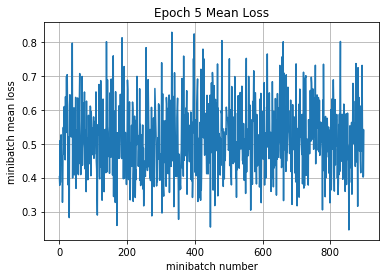

2017-10-25 22:41:02 Iter 4500: batch trn loss = 0.689, accuracy = 0.760
2017-10-25 22:41:21 Iter 4600: batch trn loss = 0.482, accuracy = 0.860
2017-10-25 22:41:40 Iter 4700: batch trn loss = 0.503, accuracy = 0.840
2017-10-25 22:41:59 Iter 4800: batch trn loss = 0.511, accuracy = 0.880
2017-10-25 22:42:19 Iter 4900: batch trn loss = 0.576, accuracy = 0.780
2017-10-25 22:42:40 Iter 5000: batch trn loss = 0.456, accuracy = 0.880
2017-10-25 22:43:01 Iter 5100: batch trn loss = 0.525, accuracy = 0.840
2017-10-25 22:43:22 Iter 5200: batch trn loss = 0.531, accuracy = 0.860
2017-10-25 22:43:41 Iter 5300: batch trn loss = 0.685, accuracy = 0.820
Epoch 5: mean loss = 0.495, accuracy = 0.844


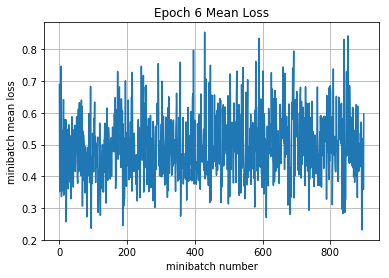

2017-10-25 22:44:01 Iter 5400: batch trn loss = 0.591, accuracy = 0.820
2017-10-25 22:44:21 Iter 5500: batch trn loss = 0.491, accuracy = 0.860
2017-10-25 22:44:41 Iter 5600: batch trn loss = 0.398, accuracy = 0.840
2017-10-25 22:45:01 Iter 5700: batch trn loss = 0.534, accuracy = 0.880
2017-10-25 22:45:21 Iter 5800: batch trn loss = 0.451, accuracy = 0.920
2017-10-25 22:45:40 Iter 5900: batch trn loss = 0.483, accuracy = 0.860
2017-10-25 22:45:59 Iter 6000: batch trn loss = 0.483, accuracy = 0.820
2017-10-25 22:46:20 Iter 6100: batch trn loss = 0.398, accuracy = 0.900
2017-10-25 22:46:39 Iter 6200: batch trn loss = 0.456, accuracy = 0.880
Epoch 6: mean loss = 0.473, accuracy = 0.854


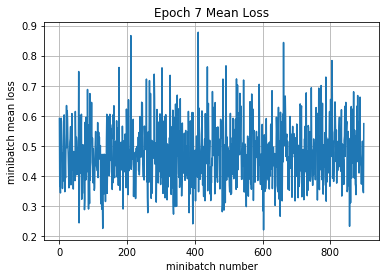

2017-10-25 22:46:59 Iter 6300: batch trn loss = 0.599, accuracy = 0.820
2017-10-25 22:47:19 Iter 6400: batch trn loss = 0.406, accuracy = 0.820
2017-10-25 22:47:39 Iter 6500: batch trn loss = 0.523, accuracy = 0.780
2017-10-25 22:47:58 Iter 6600: batch trn loss = 0.518, accuracy = 0.800
2017-10-25 22:48:18 Iter 6700: batch trn loss = 0.500, accuracy = 0.860
2017-10-25 22:48:38 Iter 6800: batch trn loss = 0.343, accuracy = 0.880
2017-10-25 22:48:57 Iter 6900: batch trn loss = 0.445, accuracy = 0.800
2017-10-25 22:49:17 Iter 7000: batch trn loss = 0.612, accuracy = 0.840
2017-10-25 22:49:37 Iter 7100: batch trn loss = 0.462, accuracy = 0.840
Epoch 7: mean loss = 0.457, accuracy = 0.858


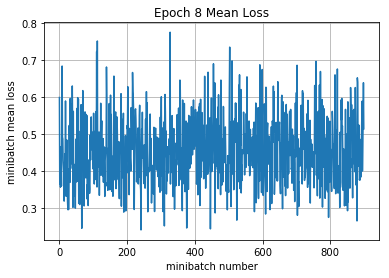

2017-10-25 22:49:57 Iter 7200: batch trn loss = 0.231, accuracy = 0.980
2017-10-25 22:50:16 Iter 7300: batch trn loss = 0.404, accuracy = 0.880
2017-10-25 22:50:36 Iter 7400: batch trn loss = 0.536, accuracy = 0.840
2017-10-25 22:50:57 Iter 7500: batch trn loss = 0.470, accuracy = 0.880
2017-10-25 22:51:16 Iter 7600: batch trn loss = 0.551, accuracy = 0.780
2017-10-25 22:51:36 Iter 7700: batch trn loss = 0.432, accuracy = 0.880
2017-10-25 22:51:56 Iter 7800: batch trn loss = 0.481, accuracy = 0.840
2017-10-25 22:52:15 Iter 7900: batch trn loss = 0.511, accuracy = 0.780
2017-10-25 22:52:35 Iter 8000: batch trn loss = 0.514, accuracy = 0.820
Epoch 8: mean loss = 0.433, accuracy = 0.868


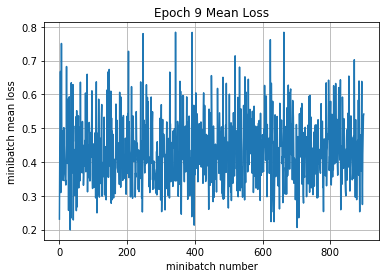

2017-10-25 22:52:55 Iter 8100: batch trn loss = 0.336, accuracy = 0.920
2017-10-25 22:53:14 Iter 8200: batch trn loss = 0.519, accuracy = 0.840
2017-10-25 22:53:34 Iter 8300: batch trn loss = 0.458, accuracy = 0.800
2017-10-25 22:53:55 Iter 8400: batch trn loss = 0.451, accuracy = 0.920
2017-10-25 22:54:15 Iter 8500: batch trn loss = 0.226, accuracy = 0.960
2017-10-25 22:54:37 Iter 8600: batch trn loss = 0.392, accuracy = 0.880
2017-10-25 22:55:02 Iter 8700: batch trn loss = 0.450, accuracy = 0.820
2017-10-25 22:55:23 Iter 8800: batch trn loss = 0.424, accuracy = 0.860
2017-10-25 22:55:44 Iter 8900: batch trn loss = 0.437, accuracy = 0.820
Epoch 9: mean loss = 0.418, accuracy = 0.874


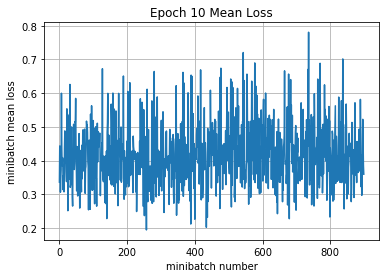

validation
Epoch 0: mean loss = 1.046, accuracy = 0.663


In [67]:
# 10 more epochs
print('train')
cnn.train(X_trn, y_trn, epochs=10, batch_size=50, print_every=100, plot_losses=True)
print('validation')
cnn.validate(X_val, y_val, epochs=1, batch_size=y_val.shape[0])

train
2017-10-25 22:58:26 Iter 0: batch trn loss = 0.355, accuracy = 0.880
2017-10-25 22:58:47 Iter 100: batch trn loss = 0.680, accuracy = 0.720
2017-10-25 22:59:07 Iter 200: batch trn loss = 0.235, accuracy = 0.960
2017-10-25 22:59:27 Iter 300: batch trn loss = 0.373, accuracy = 0.880
2017-10-25 22:59:47 Iter 400: batch trn loss = 0.460, accuracy = 0.880
2017-10-25 23:00:07 Iter 500: batch trn loss = 0.331, accuracy = 0.900
2017-10-25 23:00:27 Iter 600: batch trn loss = 0.266, accuracy = 0.960
2017-10-25 23:00:47 Iter 700: batch trn loss = 0.328, accuracy = 0.900
2017-10-25 23:01:08 Iter 800: batch trn loss = 0.280, accuracy = 0.940
Epoch 0: mean loss = 0.397, accuracy = 0.883


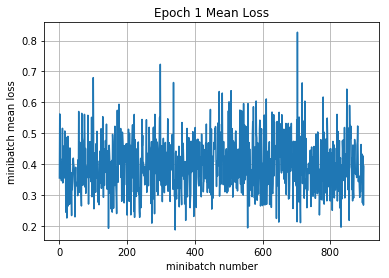

2017-10-25 23:01:28 Iter 900: batch trn loss = 0.425, accuracy = 0.840
2017-10-25 23:01:48 Iter 1000: batch trn loss = 0.296, accuracy = 0.920
2017-10-25 23:02:08 Iter 1100: batch trn loss = 0.349, accuracy = 0.940
2017-10-25 23:02:28 Iter 1200: batch trn loss = 0.243, accuracy = 0.960
2017-10-25 23:02:48 Iter 1300: batch trn loss = 0.423, accuracy = 0.860
2017-10-25 23:03:07 Iter 1400: batch trn loss = 0.524, accuracy = 0.880
2017-10-25 23:03:27 Iter 1500: batch trn loss = 0.446, accuracy = 0.880
2017-10-25 23:03:47 Iter 1600: batch trn loss = 0.296, accuracy = 0.940
2017-10-25 23:04:06 Iter 1700: batch trn loss = 0.417, accuracy = 0.820
Epoch 1: mean loss = 0.383, accuracy = 0.887


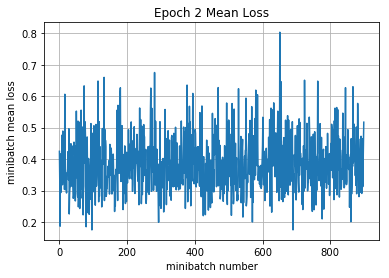

2017-10-25 23:04:26 Iter 1800: batch trn loss = 0.283, accuracy = 0.940
2017-10-25 23:04:45 Iter 1900: batch trn loss = 0.383, accuracy = 0.900
2017-10-25 23:05:04 Iter 2000: batch trn loss = 0.446, accuracy = 0.880
2017-10-25 23:05:24 Iter 2100: batch trn loss = 0.557, accuracy = 0.900
2017-10-25 23:05:43 Iter 2200: batch trn loss = 0.295, accuracy = 0.960
2017-10-25 23:06:03 Iter 2300: batch trn loss = 0.498, accuracy = 0.860
2017-10-25 23:06:22 Iter 2400: batch trn loss = 0.408, accuracy = 0.900
2017-10-25 23:06:42 Iter 2500: batch trn loss = 0.299, accuracy = 0.920
2017-10-25 23:07:02 Iter 2600: batch trn loss = 0.336, accuracy = 0.840
Epoch 2: mean loss = 0.367, accuracy = 0.893


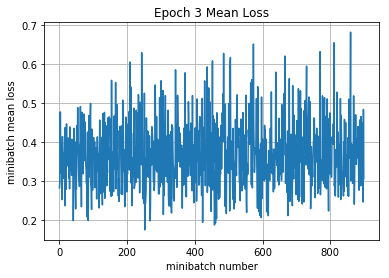

2017-10-25 23:07:21 Iter 2700: batch trn loss = 0.368, accuracy = 0.900
2017-10-25 23:07:41 Iter 2800: batch trn loss = 0.244, accuracy = 0.960
2017-10-25 23:08:01 Iter 2900: batch trn loss = 0.333, accuracy = 0.860
2017-10-25 23:08:21 Iter 3000: batch trn loss = 0.247, accuracy = 0.980
2017-10-25 23:08:41 Iter 3100: batch trn loss = 0.267, accuracy = 0.960
2017-10-25 23:09:01 Iter 3200: batch trn loss = 0.504, accuracy = 0.760
2017-10-25 23:09:21 Iter 3300: batch trn loss = 0.374, accuracy = 0.840
2017-10-25 23:09:40 Iter 3400: batch trn loss = 0.426, accuracy = 0.900
2017-10-25 23:10:00 Iter 3500: batch trn loss = 0.407, accuracy = 0.840
Epoch 3: mean loss = 0.347, accuracy = 0.900


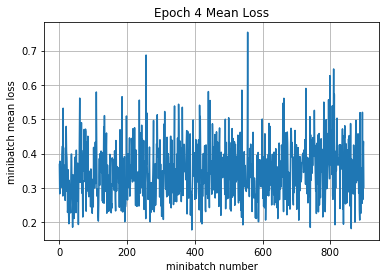

2017-10-25 23:10:21 Iter 3600: batch trn loss = 0.271, accuracy = 0.940
2017-10-25 23:10:41 Iter 3700: batch trn loss = 0.252, accuracy = 0.940
2017-10-25 23:11:00 Iter 3800: batch trn loss = 0.385, accuracy = 0.940
2017-10-25 23:11:20 Iter 3900: batch trn loss = 0.320, accuracy = 0.940
2017-10-25 23:11:39 Iter 4000: batch trn loss = 0.260, accuracy = 0.960
2017-10-25 23:11:59 Iter 4100: batch trn loss = 0.288, accuracy = 0.920
2017-10-25 23:12:19 Iter 4200: batch trn loss = 0.382, accuracy = 0.920
2017-10-25 23:12:39 Iter 4300: batch trn loss = 0.354, accuracy = 0.880
2017-10-25 23:12:58 Iter 4400: batch trn loss = 0.549, accuracy = 0.820
Epoch 4: mean loss = 0.331, accuracy = 0.907


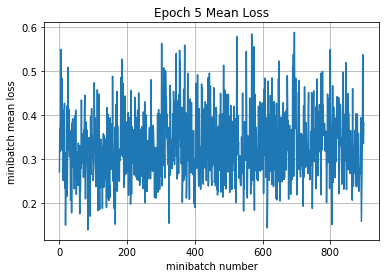

2017-10-25 23:13:17 Iter 4500: batch trn loss = 0.328, accuracy = 0.920
2017-10-25 23:13:36 Iter 4600: batch trn loss = 0.307, accuracy = 0.920
2017-10-25 23:13:55 Iter 4700: batch trn loss = 0.255, accuracy = 0.960
2017-10-25 23:14:15 Iter 4800: batch trn loss = 0.261, accuracy = 0.960
2017-10-25 23:14:34 Iter 4900: batch trn loss = 0.301, accuracy = 0.920
2017-10-25 23:14:52 Iter 5000: batch trn loss = 0.274, accuracy = 0.920
2017-10-25 23:15:12 Iter 5100: batch trn loss = 0.266, accuracy = 0.960
2017-10-25 23:15:32 Iter 5200: batch trn loss = 0.242, accuracy = 0.960
2017-10-25 23:15:51 Iter 5300: batch trn loss = 0.305, accuracy = 0.900
Epoch 5: mean loss = 0.316, accuracy = 0.913


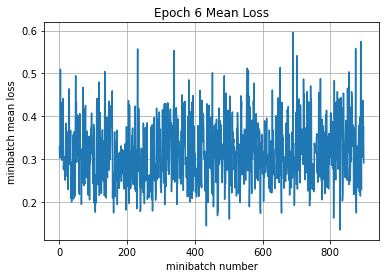

2017-10-25 23:16:11 Iter 5400: batch trn loss = 0.290, accuracy = 0.960
2017-10-25 23:16:30 Iter 5500: batch trn loss = 0.300, accuracy = 0.920
2017-10-25 23:16:49 Iter 5600: batch trn loss = 0.228, accuracy = 0.960
2017-10-25 23:17:09 Iter 5700: batch trn loss = 0.306, accuracy = 0.960
2017-10-25 23:17:28 Iter 5800: batch trn loss = 0.433, accuracy = 0.860
2017-10-25 23:17:47 Iter 5900: batch trn loss = 0.396, accuracy = 0.900
2017-10-25 23:18:06 Iter 6000: batch trn loss = 0.241, accuracy = 0.920
2017-10-25 23:18:25 Iter 6100: batch trn loss = 0.378, accuracy = 0.920
2017-10-25 23:18:44 Iter 6200: batch trn loss = 0.229, accuracy = 0.960
Epoch 6: mean loss = 0.300, accuracy = 0.920


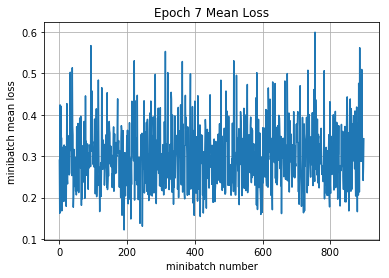

2017-10-25 23:19:04 Iter 6300: batch trn loss = 0.248, accuracy = 0.940
2017-10-25 23:19:24 Iter 6400: batch trn loss = 0.311, accuracy = 0.960
2017-10-25 23:19:43 Iter 6500: batch trn loss = 0.337, accuracy = 0.880
2017-10-25 23:20:02 Iter 6600: batch trn loss = 0.304, accuracy = 0.920
2017-10-25 23:20:21 Iter 6700: batch trn loss = 0.247, accuracy = 0.940
2017-10-25 23:20:40 Iter 6800: batch trn loss = 0.294, accuracy = 0.920
2017-10-25 23:20:59 Iter 6900: batch trn loss = 0.302, accuracy = 0.900
2017-10-25 23:21:17 Iter 7000: batch trn loss = 0.303, accuracy = 0.920
2017-10-25 23:21:36 Iter 7100: batch trn loss = 0.330, accuracy = 0.900
Epoch 7: mean loss = 0.287, accuracy = 0.923


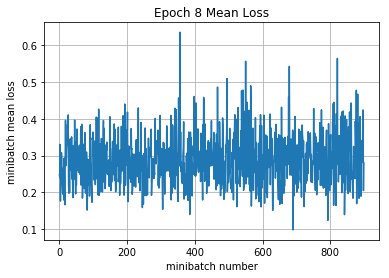

2017-10-25 23:21:57 Iter 7200: batch trn loss = 0.325, accuracy = 0.940
2017-10-25 23:22:16 Iter 7300: batch trn loss = 0.327, accuracy = 0.900
2017-10-25 23:22:35 Iter 7400: batch trn loss = 0.408, accuracy = 0.920
2017-10-25 23:22:54 Iter 7500: batch trn loss = 0.305, accuracy = 0.920
2017-10-25 23:23:13 Iter 7600: batch trn loss = 0.213, accuracy = 0.960
2017-10-25 23:23:33 Iter 7700: batch trn loss = 0.261, accuracy = 0.900
2017-10-25 23:23:53 Iter 7800: batch trn loss = 0.234, accuracy = 0.960
2017-10-25 23:24:12 Iter 7900: batch trn loss = 0.230, accuracy = 0.940
2017-10-25 23:24:31 Iter 8000: batch trn loss = 0.316, accuracy = 0.940
Epoch 8: mean loss = 0.273, accuracy = 0.929


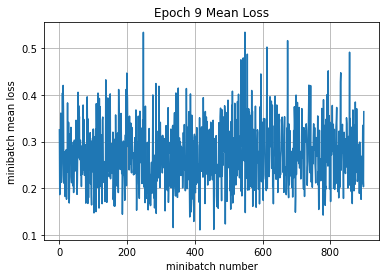

2017-10-25 23:24:50 Iter 8100: batch trn loss = 0.245, accuracy = 0.920
2017-10-25 23:25:09 Iter 8200: batch trn loss = 0.265, accuracy = 0.920
2017-10-25 23:25:28 Iter 8300: batch trn loss = 0.315, accuracy = 0.900
2017-10-25 23:25:47 Iter 8400: batch trn loss = 0.260, accuracy = 0.900
2017-10-25 23:26:06 Iter 8500: batch trn loss = 0.310, accuracy = 0.940
2017-10-25 23:26:26 Iter 8600: batch trn loss = 0.343, accuracy = 0.900
2017-10-25 23:26:45 Iter 8700: batch trn loss = 0.204, accuracy = 0.960
2017-10-25 23:27:05 Iter 8800: batch trn loss = 0.273, accuracy = 0.900
2017-10-25 23:27:24 Iter 8900: batch trn loss = 0.260, accuracy = 0.940
Epoch 9: mean loss = 0.262, accuracy = 0.933


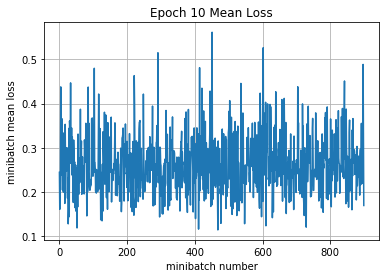

validation
Epoch 0: mean loss = 1.088, accuracy = 0.668


In [68]:
# 10 more epochs, val from 0.663 to 0.668
print('train')
cnn.train(X_trn, y_trn, epochs=10, batch_size=50, print_every=100, plot_losses=True)
print('validation')
cnn.validate(X_val, y_val, epochs=1, batch_size=y_val.shape[0])

In [ ]:
def model_fn(layer_input, labels, is_training):
    # conv - bn - max_pool
    F1 = 32
    layer = tf.layers.conv2d(inputs=layer_input, filters=F1, kernel_size=[5, 5], padding='same', activation=tf.nn.relu)
    layer = tf.layers.batch_normalization(inputs=layer, training=is_training)
    layer = tf.layers.max_pooling2d(inputs=layer, pool_size=[2, 2], strides=2)
    # conv - bn - max_pool
    F2 = 64
    layer = tf.layers.conv2d(inputs=layer, filters=F2, kernel_size=[5, 5], padding='same', activation=tf.nn.relu)
    layer = tf.layers.batch_normalization(inputs=layer, training=is_training)
    layer = tf.layers.max_pooling2d(inputs=layer, pool_size=[2, 2], strides=2)
    # dense1 - bn - dense2 - bn - softmax
    flat_size = int(H / 4 * W / 4 * F2)
    print(flat_size)
    layer = tf.reshape(layer, [-1, flat_size])
    layer = tf.layers.dense(inputs=layer, units=512, activation=tf.nn.relu)
    layer = tf.layers.batch_normalization(inputs=layer, training=is_training)
    layer = tf.layers.dense(inputs=layer, units=64, activation=tf.nn.relu)
    layer = tf.layers.batch_normalization(inputs=layer, training=is_training)
    # layer_dropout = tf.layers.dropout(inputs=layer_dense, rate=0.4)
    # no activation here for logit, as it will be calculated in loss
    logit = tf.layers.dense(inputs=layer, units=T, activation=None)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int64), depth=10)
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=logit)
    return logit, loss

trainer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
cnn = CNN(model_fn, trainer)
print('train')
cnn.train(X_trn, y_trn, epochs=20, batch_size=50, print_every=100, plot_losses=True)
print('validation')
cnn.validate(X_val, y_val, epochs=1, batch_size=y_val.shape[0])

## [10/26] [0010] Add l2 regularizer with reg_scale=0.1
- Base: (0005) on last dense with activation and batch normalization
- trn: 0.827, val: 0.653 (20 epochs) (worse than 0005)
- trn: 0.899, val: 0.676 (30 epochs) (worse than 0005)
- trn: 0.948, val: 0.691 (40 epochs) (best)
- trn: 0.976, val: 0.686 (50 epochs) (worse than 40 epochs, may imply that 0.1 is too small)

4096
train
2017-10-26 10:08:19 Iter 0: batch trn loss = 2.960, accuracy = 0.100
2017-10-26 10:08:39 Iter 100: batch trn loss = 2.212, accuracy = 0.340
2017-10-26 10:08:58 Iter 200: batch trn loss = 2.084, accuracy = 0.200
2017-10-26 10:09:18 Iter 300: batch trn loss = 2.047, accuracy = 0.300
2017-10-26 10:09:37 Iter 400: batch trn loss = 2.157, accuracy = 0.320
2017-10-26 10:09:57 Iter 500: batch trn loss = 1.438, accuracy = 0.540
2017-10-26 10:10:16 Iter 600: batch trn loss = 1.794, accuracy = 0.480
2017-10-26 10:10:35 Iter 700: batch trn loss = 1.202, accuracy = 0.620
2017-10-26 10:10:55 Iter 800: batch trn loss = 1.627, accuracy = 0.520
Epoch 0: mean loss = 1.791, accuracy = 0.393


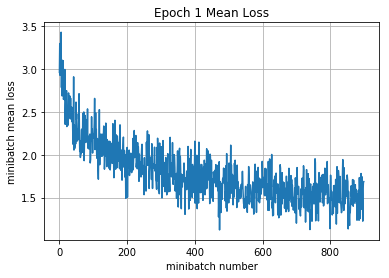

2017-10-26 10:11:14 Iter 900: batch trn loss = 1.407, accuracy = 0.420
2017-10-26 10:11:34 Iter 1000: batch trn loss = 1.174, accuracy = 0.520
2017-10-26 10:11:54 Iter 1100: batch trn loss = 1.349, accuracy = 0.520
2017-10-26 10:12:13 Iter 1200: batch trn loss = 1.414, accuracy = 0.460
2017-10-26 10:12:32 Iter 1300: batch trn loss = 1.286, accuracy = 0.560
2017-10-26 10:12:52 Iter 1400: batch trn loss = 1.346, accuracy = 0.520
2017-10-26 10:13:11 Iter 1500: batch trn loss = 1.062, accuracy = 0.660
2017-10-26 10:13:31 Iter 1600: batch trn loss = 1.156, accuracy = 0.620
2017-10-26 10:13:50 Iter 1700: batch trn loss = 1.386, accuracy = 0.540
Epoch 1: mean loss = 1.354, accuracy = 0.528


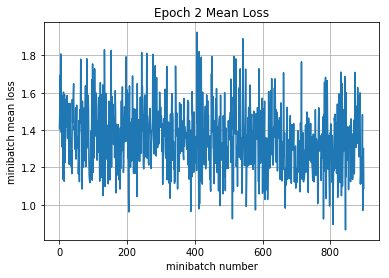

2017-10-26 10:14:10 Iter 1800: batch trn loss = 1.170, accuracy = 0.560
2017-10-26 10:14:29 Iter 1900: batch trn loss = 1.391, accuracy = 0.520
2017-10-26 10:14:49 Iter 2000: batch trn loss = 0.991, accuracy = 0.660
2017-10-26 10:15:09 Iter 2100: batch trn loss = 1.274, accuracy = 0.520
2017-10-26 10:15:30 Iter 2200: batch trn loss = 1.271, accuracy = 0.560
2017-10-26 10:15:50 Iter 2300: batch trn loss = 1.158, accuracy = 0.660
2017-10-26 10:16:12 Iter 2400: batch trn loss = 1.539, accuracy = 0.520
2017-10-26 10:16:32 Iter 2500: batch trn loss = 1.105, accuracy = 0.580
2017-10-26 10:16:54 Iter 2600: batch trn loss = 1.098, accuracy = 0.620
Epoch 2: mean loss = 1.207, accuracy = 0.579


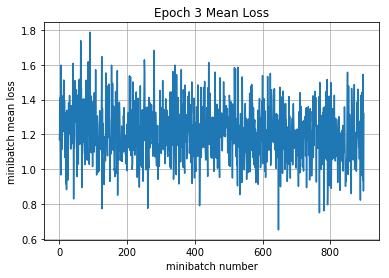

2017-10-26 10:17:15 Iter 2700: batch trn loss = 1.464, accuracy = 0.540
2017-10-26 10:17:35 Iter 2800: batch trn loss = 1.323, accuracy = 0.580
2017-10-26 10:17:55 Iter 2900: batch trn loss = 1.398, accuracy = 0.600
2017-10-26 10:18:15 Iter 3000: batch trn loss = 1.120, accuracy = 0.620
2017-10-26 10:18:36 Iter 3100: batch trn loss = 1.327, accuracy = 0.560
2017-10-26 10:18:55 Iter 3200: batch trn loss = 1.199, accuracy = 0.580
2017-10-26 10:19:15 Iter 3300: batch trn loss = 1.301, accuracy = 0.600
2017-10-26 10:19:35 Iter 3400: batch trn loss = 1.246, accuracy = 0.540
2017-10-26 10:19:54 Iter 3500: batch trn loss = 1.146, accuracy = 0.600
Epoch 3: mean loss = 1.114, accuracy = 0.615


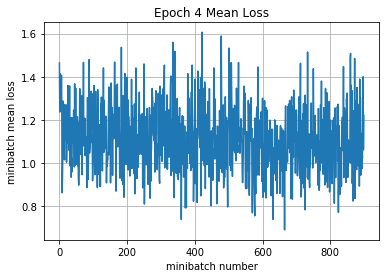

2017-10-26 10:20:14 Iter 3600: batch trn loss = 1.305, accuracy = 0.580
2017-10-26 10:20:34 Iter 3700: batch trn loss = 1.135, accuracy = 0.580
2017-10-26 10:20:54 Iter 3800: batch trn loss = 1.016, accuracy = 0.680
2017-10-26 10:21:14 Iter 3900: batch trn loss = 1.128, accuracy = 0.600
2017-10-26 10:21:34 Iter 4000: batch trn loss = 1.284, accuracy = 0.540
2017-10-26 10:21:53 Iter 4100: batch trn loss = 1.073, accuracy = 0.680
2017-10-26 10:22:13 Iter 4200: batch trn loss = 1.258, accuracy = 0.580
2017-10-26 10:22:32 Iter 4300: batch trn loss = 1.201, accuracy = 0.580
2017-10-26 10:22:52 Iter 4400: batch trn loss = 0.997, accuracy = 0.580
Epoch 4: mean loss = 1.043, accuracy = 0.640


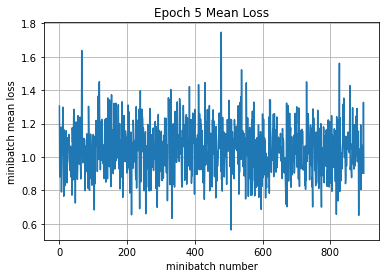

2017-10-26 10:23:12 Iter 4500: batch trn loss = 0.786, accuracy = 0.760
2017-10-26 10:23:31 Iter 4600: batch trn loss = 1.319, accuracy = 0.560
2017-10-26 10:23:50 Iter 4700: batch trn loss = 0.840, accuracy = 0.700
2017-10-26 10:24:10 Iter 4800: batch trn loss = 1.386, accuracy = 0.560
2017-10-26 10:24:29 Iter 4900: batch trn loss = 1.016, accuracy = 0.600
2017-10-26 10:24:48 Iter 5000: batch trn loss = 0.928, accuracy = 0.640
2017-10-26 10:25:08 Iter 5100: batch trn loss = 1.026, accuracy = 0.620
2017-10-26 10:25:27 Iter 5200: batch trn loss = 0.769, accuracy = 0.720
2017-10-26 10:25:46 Iter 5300: batch trn loss = 1.139, accuracy = 0.660
Epoch 5: mean loss = 0.986, accuracy = 0.660


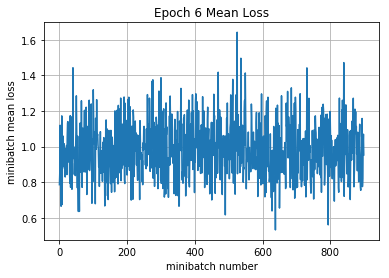

2017-10-26 10:26:06 Iter 5400: batch trn loss = 0.916, accuracy = 0.620
2017-10-26 10:26:25 Iter 5500: batch trn loss = 0.847, accuracy = 0.700
2017-10-26 10:26:45 Iter 5600: batch trn loss = 0.793, accuracy = 0.660
2017-10-26 10:27:04 Iter 5700: batch trn loss = 0.826, accuracy = 0.740
2017-10-26 10:27:23 Iter 5800: batch trn loss = 0.828, accuracy = 0.760
2017-10-26 10:27:43 Iter 5900: batch trn loss = 0.777, accuracy = 0.780
2017-10-26 10:28:03 Iter 6000: batch trn loss = 1.068, accuracy = 0.660
2017-10-26 10:28:22 Iter 6100: batch trn loss = 0.956, accuracy = 0.700
2017-10-26 10:28:42 Iter 6200: batch trn loss = 0.864, accuracy = 0.780
Epoch 6: mean loss = 0.934, accuracy = 0.681


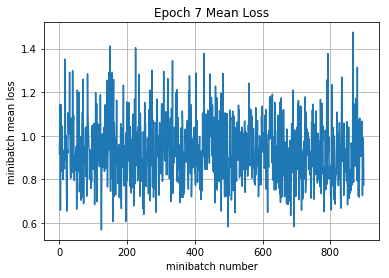

2017-10-26 10:29:01 Iter 6300: batch trn loss = 0.715, accuracy = 0.840
2017-10-26 10:29:20 Iter 6400: batch trn loss = 0.990, accuracy = 0.620
2017-10-26 10:29:40 Iter 6500: batch trn loss = 1.012, accuracy = 0.680
2017-10-26 10:30:00 Iter 6600: batch trn loss = 1.237, accuracy = 0.640
2017-10-26 10:30:20 Iter 6700: batch trn loss = 0.843, accuracy = 0.700
2017-10-26 10:30:40 Iter 6800: batch trn loss = 1.061, accuracy = 0.660
2017-10-26 10:30:59 Iter 6900: batch trn loss = 0.854, accuracy = 0.760
2017-10-26 10:31:19 Iter 7000: batch trn loss = 1.058, accuracy = 0.600
2017-10-26 10:31:39 Iter 7100: batch trn loss = 0.771, accuracy = 0.740
Epoch 7: mean loss = 0.889, accuracy = 0.699


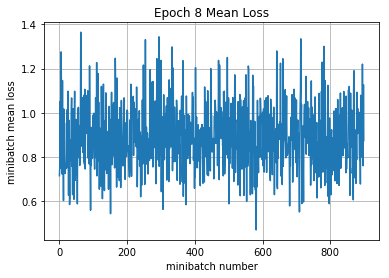

2017-10-26 10:31:59 Iter 7200: batch trn loss = 0.840, accuracy = 0.720
2017-10-26 10:32:19 Iter 7300: batch trn loss = 0.955, accuracy = 0.700
2017-10-26 10:32:40 Iter 7400: batch trn loss = 0.836, accuracy = 0.740
2017-10-26 10:32:59 Iter 7500: batch trn loss = 0.857, accuracy = 0.740
2017-10-26 10:33:18 Iter 7600: batch trn loss = 0.800, accuracy = 0.720
2017-10-26 10:33:38 Iter 7700: batch trn loss = 0.908, accuracy = 0.680
2017-10-26 10:33:57 Iter 7800: batch trn loss = 0.830, accuracy = 0.680
2017-10-26 10:34:16 Iter 7900: batch trn loss = 0.788, accuracy = 0.780
2017-10-26 10:34:36 Iter 8000: batch trn loss = 0.757, accuracy = 0.760
Epoch 8: mean loss = 0.851, accuracy = 0.711


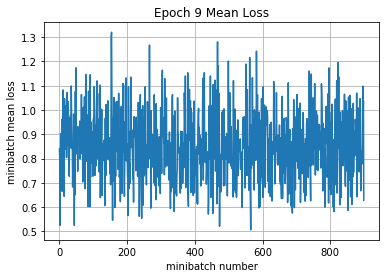

2017-10-26 10:34:55 Iter 8100: batch trn loss = 0.679, accuracy = 0.780
2017-10-26 10:35:14 Iter 8200: batch trn loss = 0.844, accuracy = 0.740
2017-10-26 10:35:34 Iter 8300: batch trn loss = 0.808, accuracy = 0.700
2017-10-26 10:35:53 Iter 8400: batch trn loss = 1.016, accuracy = 0.660
2017-10-26 10:36:13 Iter 8500: batch trn loss = 0.718, accuracy = 0.760
2017-10-26 10:36:32 Iter 8600: batch trn loss = 0.755, accuracy = 0.780
2017-10-26 10:36:51 Iter 8700: batch trn loss = 0.977, accuracy = 0.660
2017-10-26 10:37:11 Iter 8800: batch trn loss = 1.096, accuracy = 0.620
2017-10-26 10:37:30 Iter 8900: batch trn loss = 0.689, accuracy = 0.800
Epoch 9: mean loss = 0.814, accuracy = 0.724


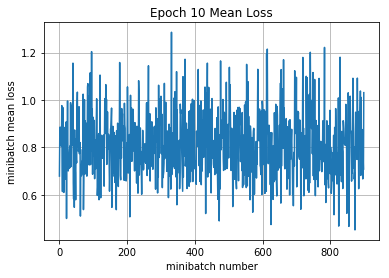

2017-10-26 10:37:50 Iter 9000: batch trn loss = 0.558, accuracy = 0.780
2017-10-26 10:38:09 Iter 9100: batch trn loss = 0.617, accuracy = 0.760
2017-10-26 10:38:28 Iter 9200: batch trn loss = 0.613, accuracy = 0.800
2017-10-26 10:38:48 Iter 9300: batch trn loss = 0.860, accuracy = 0.740
2017-10-26 10:39:07 Iter 9400: batch trn loss = 0.989, accuracy = 0.620
2017-10-26 10:39:26 Iter 9500: batch trn loss = 0.617, accuracy = 0.820
2017-10-26 10:39:45 Iter 9600: batch trn loss = 0.536, accuracy = 0.800
2017-10-26 10:40:05 Iter 9700: batch trn loss = 1.059, accuracy = 0.620
2017-10-26 10:40:24 Iter 9800: batch trn loss = 0.894, accuracy = 0.620
Epoch 10: mean loss = 0.779, accuracy = 0.738


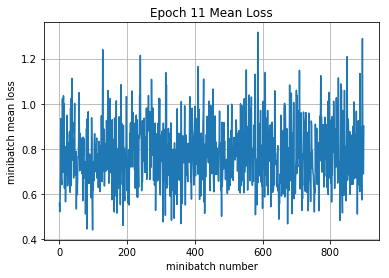

2017-10-26 10:40:44 Iter 9900: batch trn loss = 0.887, accuracy = 0.600
2017-10-26 10:41:03 Iter 10000: batch trn loss = 0.795, accuracy = 0.720
2017-10-26 10:41:22 Iter 10100: batch trn loss = 0.794, accuracy = 0.780
2017-10-26 10:41:41 Iter 10200: batch trn loss = 0.675, accuracy = 0.720
2017-10-26 10:42:01 Iter 10300: batch trn loss = 0.727, accuracy = 0.720
2017-10-26 10:42:20 Iter 10400: batch trn loss = 0.625, accuracy = 0.780
2017-10-26 10:42:39 Iter 10500: batch trn loss = 0.732, accuracy = 0.740
2017-10-26 10:42:59 Iter 10600: batch trn loss = 0.863, accuracy = 0.680
2017-10-26 10:43:18 Iter 10700: batch trn loss = 0.640, accuracy = 0.760
Epoch 11: mean loss = 0.747, accuracy = 0.749


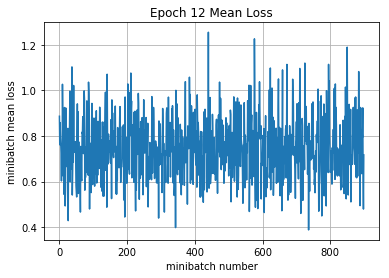

2017-10-26 10:43:37 Iter 10800: batch trn loss = 0.647, accuracy = 0.760
2017-10-26 10:43:57 Iter 10900: batch trn loss = 0.685, accuracy = 0.800
2017-10-26 10:44:16 Iter 11000: batch trn loss = 0.627, accuracy = 0.840
2017-10-26 10:44:36 Iter 11100: batch trn loss = 0.834, accuracy = 0.700
2017-10-26 10:44:55 Iter 11200: batch trn loss = 0.977, accuracy = 0.740
2017-10-26 10:45:14 Iter 11300: batch trn loss = 0.747, accuracy = 0.800
2017-10-26 10:45:34 Iter 11400: batch trn loss = 0.838, accuracy = 0.720
2017-10-26 10:45:53 Iter 11500: batch trn loss = 0.660, accuracy = 0.800
2017-10-26 10:46:12 Iter 11600: batch trn loss = 0.898, accuracy = 0.640
Epoch 12: mean loss = 0.718, accuracy = 0.761


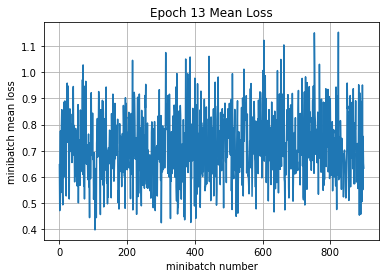

2017-10-26 10:46:32 Iter 11700: batch trn loss = 0.660, accuracy = 0.720
2017-10-26 10:46:52 Iter 11800: batch trn loss = 0.676, accuracy = 0.800
2017-10-26 10:47:13 Iter 11900: batch trn loss = 0.700, accuracy = 0.800
2017-10-26 10:47:32 Iter 12000: batch trn loss = 0.674, accuracy = 0.800
2017-10-26 10:47:51 Iter 12100: batch trn loss = 0.712, accuracy = 0.720
2017-10-26 10:48:11 Iter 12200: batch trn loss = 0.678, accuracy = 0.740
2017-10-26 10:48:30 Iter 12300: batch trn loss = 0.542, accuracy = 0.800
2017-10-26 10:48:49 Iter 12400: batch trn loss = 0.597, accuracy = 0.780
2017-10-26 10:49:09 Iter 12500: batch trn loss = 0.818, accuracy = 0.700
Epoch 13: mean loss = 0.688, accuracy = 0.770


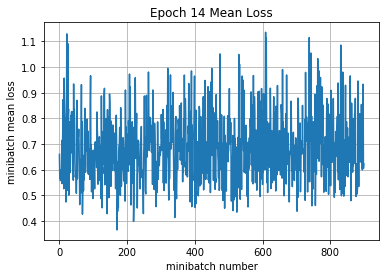

2017-10-26 10:49:28 Iter 12600: batch trn loss = 0.504, accuracy = 0.860
2017-10-26 10:49:47 Iter 12700: batch trn loss = 0.778, accuracy = 0.700
2017-10-26 10:50:07 Iter 12800: batch trn loss = 0.671, accuracy = 0.780
2017-10-26 10:50:26 Iter 12900: batch trn loss = 0.559, accuracy = 0.860
2017-10-26 10:50:45 Iter 13000: batch trn loss = 0.776, accuracy = 0.740
2017-10-26 10:51:04 Iter 13100: batch trn loss = 0.706, accuracy = 0.740
2017-10-26 10:51:24 Iter 13200: batch trn loss = 0.639, accuracy = 0.800
2017-10-26 10:51:43 Iter 13300: batch trn loss = 0.711, accuracy = 0.720
2017-10-26 10:52:02 Iter 13400: batch trn loss = 0.699, accuracy = 0.740
Epoch 14: mean loss = 0.661, accuracy = 0.781


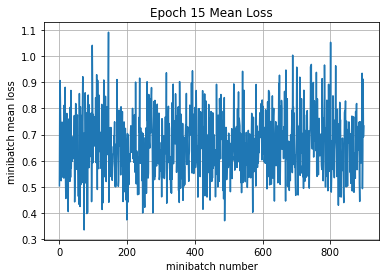

2017-10-26 10:52:22 Iter 13500: batch trn loss = 0.524, accuracy = 0.840
2017-10-26 10:52:41 Iter 13600: batch trn loss = 0.775, accuracy = 0.720
2017-10-26 10:53:00 Iter 13700: batch trn loss = 0.752, accuracy = 0.760
2017-10-26 10:53:20 Iter 13800: batch trn loss = 0.989, accuracy = 0.620
2017-10-26 10:53:39 Iter 13900: batch trn loss = 0.697, accuracy = 0.800
2017-10-26 10:53:58 Iter 14000: batch trn loss = 0.473, accuracy = 0.860
2017-10-26 10:54:18 Iter 14100: batch trn loss = 0.709, accuracy = 0.760
2017-10-26 10:54:37 Iter 14200: batch trn loss = 0.944, accuracy = 0.680
2017-10-26 10:54:56 Iter 14300: batch trn loss = 0.661, accuracy = 0.840
Epoch 15: mean loss = 0.633, accuracy = 0.792


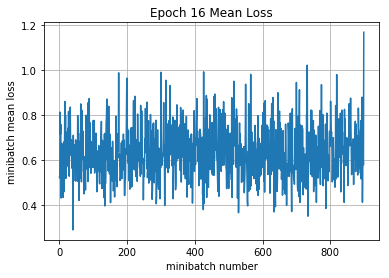

2017-10-26 10:55:15 Iter 14400: batch trn loss = 0.429, accuracy = 0.860
2017-10-26 10:55:35 Iter 14500: batch trn loss = 0.466, accuracy = 0.900
2017-10-26 10:55:54 Iter 14600: batch trn loss = 0.517, accuracy = 0.820
2017-10-26 10:56:13 Iter 14700: batch trn loss = 0.638, accuracy = 0.760
2017-10-26 10:56:33 Iter 14800: batch trn loss = 0.561, accuracy = 0.800
2017-10-26 10:56:52 Iter 14900: batch trn loss = 0.371, accuracy = 0.920
2017-10-26 10:57:11 Iter 15000: batch trn loss = 0.550, accuracy = 0.800
2017-10-26 10:57:30 Iter 15100: batch trn loss = 0.710, accuracy = 0.800
2017-10-26 10:57:50 Iter 15200: batch trn loss = 0.620, accuracy = 0.760
Epoch 16: mean loss = 0.614, accuracy = 0.800


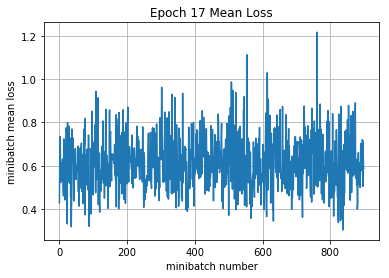

2017-10-26 10:58:09 Iter 15300: batch trn loss = 0.361, accuracy = 0.840
2017-10-26 10:58:28 Iter 15400: batch trn loss = 0.699, accuracy = 0.800
2017-10-26 10:58:48 Iter 15500: batch trn loss = 0.599, accuracy = 0.780
2017-10-26 10:59:07 Iter 15600: batch trn loss = 0.643, accuracy = 0.800
2017-10-26 10:59:26 Iter 15700: batch trn loss = 0.576, accuracy = 0.800
2017-10-26 10:59:45 Iter 15800: batch trn loss = 0.770, accuracy = 0.680
2017-10-26 11:00:05 Iter 15900: batch trn loss = 0.648, accuracy = 0.740
2017-10-26 11:00:24 Iter 16000: batch trn loss = 0.587, accuracy = 0.840
2017-10-26 11:00:43 Iter 16100: batch trn loss = 0.652, accuracy = 0.800
Epoch 17: mean loss = 0.586, accuracy = 0.811


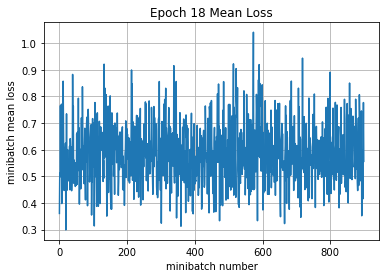

2017-10-26 11:01:03 Iter 16200: batch trn loss = 0.339, accuracy = 0.880
2017-10-26 11:01:22 Iter 16300: batch trn loss = 0.610, accuracy = 0.760
2017-10-26 11:01:41 Iter 16400: batch trn loss = 0.530, accuracy = 0.820
2017-10-26 11:02:01 Iter 16500: batch trn loss = 0.690, accuracy = 0.760
2017-10-26 11:02:20 Iter 16600: batch trn loss = 0.618, accuracy = 0.820
2017-10-26 11:02:39 Iter 16700: batch trn loss = 0.590, accuracy = 0.820
2017-10-26 11:02:59 Iter 16800: batch trn loss = 0.548, accuracy = 0.820
2017-10-26 11:03:18 Iter 16900: batch trn loss = 0.636, accuracy = 0.840
2017-10-26 11:03:37 Iter 17000: batch trn loss = 0.712, accuracy = 0.800
Epoch 18: mean loss = 0.566, accuracy = 0.820


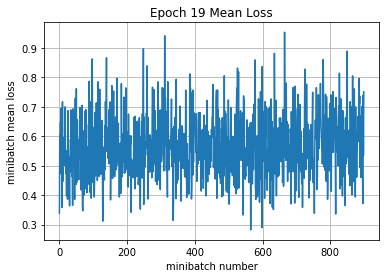

2017-10-26 11:03:57 Iter 17100: batch trn loss = 0.332, accuracy = 0.880
2017-10-26 11:04:16 Iter 17200: batch trn loss = 0.527, accuracy = 0.780
2017-10-26 11:04:35 Iter 17300: batch trn loss = 0.481, accuracy = 0.840
2017-10-26 11:04:54 Iter 17400: batch trn loss = 0.555, accuracy = 0.820
2017-10-26 11:05:14 Iter 17500: batch trn loss = 0.557, accuracy = 0.760
2017-10-26 11:05:33 Iter 17600: batch trn loss = 0.603, accuracy = 0.800
2017-10-26 11:05:52 Iter 17700: batch trn loss = 0.640, accuracy = 0.800
2017-10-26 11:06:12 Iter 17800: batch trn loss = 0.508, accuracy = 0.780
2017-10-26 11:06:31 Iter 17900: batch trn loss = 0.578, accuracy = 0.840
Epoch 19: mean loss = 0.544, accuracy = 0.827


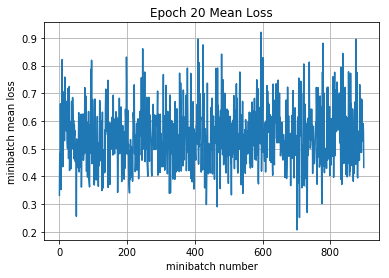

validation
Epoch 0: mean loss = 1.033, accuracy = 0.653


(1.0333408, 0.6532)

In [17]:
def model_fn(layer_input, labels, is_training):
    reg_scale= 0.1
    regularizer = tf.contrib.layers.l2_regularizer(scale=reg_scale)
    # conv - bn - max_pool
    F1 = 32
    layer = tf.layers.conv2d(inputs=layer_input, filters=F1, kernel_size=[5, 5], padding='same', activation=tf.nn.relu,
                             kernel_regularizer=regularizer)
    layer = tf.layers.batch_normalization(inputs=layer, training=is_training,
                                          beta_regularizer=regularizer, gamma_regularizer=regularizer)
    layer = tf.layers.max_pooling2d(inputs=layer, pool_size=[2, 2], strides=2)
    # conv - bn - max_pool
    F2 = 64
    layer = tf.layers.conv2d(inputs=layer, filters=F2, kernel_size=[5, 5], padding='same', activation=tf.nn.relu,
                             kernel_regularizer=regularizer)
    layer = tf.layers.batch_normalization(inputs=layer, training=is_training,
                                          beta_regularizer=regularizer, gamma_regularizer=regularizer)
    layer = tf.layers.max_pooling2d(inputs=layer, pool_size=[2, 2], strides=2)
    # dense1 - bn - softmax
    flat_size = int(H / 4 * W / 4 * F2)
    print(flat_size)
    layer = tf.reshape(layer, [-1, flat_size])
    layer = tf.layers.dense(inputs=layer, units=1024, activation=tf.nn.relu,
                            kernel_regularizer=regularizer)
    layer = tf.layers.batch_normalization(inputs=layer, training=is_training,
                                          beta_regularizer=regularizer, gamma_regularizer=regularizer)
    # layer_dropout = tf.layers.dropout(inputs=layer_dense, rate=0.4)
    # no activation here for logit, as it will be calculated in loss
    logit = tf.layers.dense(inputs=layer, units=T, activation=None,
                            kernel_regularizer=regularizer)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int64), depth=10)
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=logit)
    return logit, loss

trainer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
cnn = CNN(model_fn, trainer)
print('train')
cnn.train(X_trn, y_trn, epochs=20, batch_size=50, print_every=100, plot_losses=True)
print('validation')
cnn.validate(X_val, y_val, epochs=1, batch_size=y_val.shape[0])

train
2017-10-26 11:22:52 Iter 0: batch trn loss = 0.415, accuracy = 0.860
2017-10-26 11:23:12 Iter 100: batch trn loss = 0.297, accuracy = 0.900
2017-10-26 11:23:32 Iter 200: batch trn loss = 0.426, accuracy = 0.860
2017-10-26 11:23:52 Iter 300: batch trn loss = 0.392, accuracy = 0.920
2017-10-26 11:24:13 Iter 400: batch trn loss = 0.442, accuracy = 0.900
2017-10-26 11:24:32 Iter 500: batch trn loss = 0.443, accuracy = 0.820
2017-10-26 11:24:52 Iter 600: batch trn loss = 0.406, accuracy = 0.840
2017-10-26 11:25:11 Iter 700: batch trn loss = 0.429, accuracy = 0.900
2017-10-26 11:25:30 Iter 800: batch trn loss = 0.439, accuracy = 0.860
Epoch 0: mean loss = 0.523, accuracy = 0.835


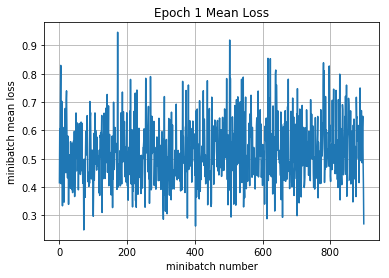

2017-10-26 11:25:50 Iter 900: batch trn loss = 0.730, accuracy = 0.660
2017-10-26 11:26:09 Iter 1000: batch trn loss = 0.507, accuracy = 0.860
2017-10-26 11:26:28 Iter 1100: batch trn loss = 0.487, accuracy = 0.880
2017-10-26 11:26:48 Iter 1200: batch trn loss = 0.351, accuracy = 0.880
2017-10-26 11:27:08 Iter 1300: batch trn loss = 0.542, accuracy = 0.820
2017-10-26 11:27:27 Iter 1400: batch trn loss = 0.555, accuracy = 0.840
2017-10-26 11:27:47 Iter 1500: batch trn loss = 0.452, accuracy = 0.820
2017-10-26 11:28:07 Iter 1600: batch trn loss = 0.552, accuracy = 0.840
2017-10-26 11:28:27 Iter 1700: batch trn loss = 0.539, accuracy = 0.860
Epoch 1: mean loss = 0.500, accuracy = 0.845


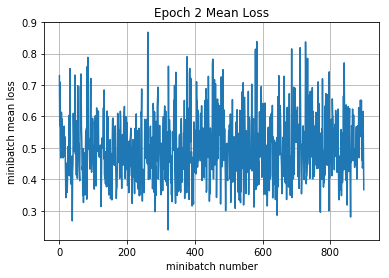

2017-10-26 11:28:47 Iter 1800: batch trn loss = 0.504, accuracy = 0.780
2017-10-26 11:29:08 Iter 1900: batch trn loss = 0.515, accuracy = 0.840
2017-10-26 11:29:27 Iter 2000: batch trn loss = 0.658, accuracy = 0.780
2017-10-26 11:29:47 Iter 2100: batch trn loss = 0.574, accuracy = 0.820
2017-10-26 11:30:09 Iter 2200: batch trn loss = 0.625, accuracy = 0.820
2017-10-26 11:30:29 Iter 2300: batch trn loss = 0.566, accuracy = 0.840
2017-10-26 11:30:50 Iter 2400: batch trn loss = 0.636, accuracy = 0.760
2017-10-26 11:31:09 Iter 2500: batch trn loss = 0.434, accuracy = 0.860
2017-10-26 11:31:29 Iter 2600: batch trn loss = 0.550, accuracy = 0.820
Epoch 2: mean loss = 0.482, accuracy = 0.850


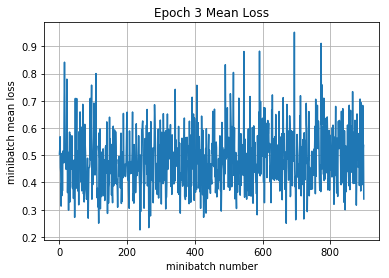

2017-10-26 11:31:49 Iter 2700: batch trn loss = 0.544, accuracy = 0.820
2017-10-26 11:32:10 Iter 2800: batch trn loss = 0.372, accuracy = 0.860
2017-10-26 11:32:32 Iter 2900: batch trn loss = 0.422, accuracy = 0.860
2017-10-26 11:32:55 Iter 3000: batch trn loss = 0.504, accuracy = 0.860
2017-10-26 11:33:15 Iter 3100: batch trn loss = 0.422, accuracy = 0.900
2017-10-26 11:33:35 Iter 3200: batch trn loss = 0.377, accuracy = 0.900
2017-10-26 11:33:55 Iter 3300: batch trn loss = 0.555, accuracy = 0.800
2017-10-26 11:34:15 Iter 3400: batch trn loss = 0.668, accuracy = 0.760
2017-10-26 11:34:35 Iter 3500: batch trn loss = 0.369, accuracy = 0.920
Epoch 3: mean loss = 0.464, accuracy = 0.858


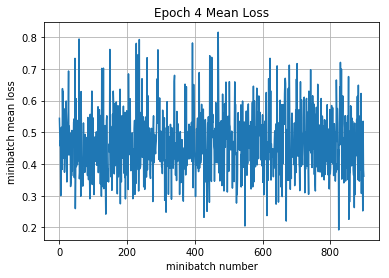

2017-10-26 11:34:57 Iter 3600: batch trn loss = 0.473, accuracy = 0.900
2017-10-26 11:35:18 Iter 3700: batch trn loss = 0.340, accuracy = 0.940
2017-10-26 11:35:37 Iter 3800: batch trn loss = 0.452, accuracy = 0.840
2017-10-26 11:35:57 Iter 3900: batch trn loss = 0.579, accuracy = 0.820
2017-10-26 11:36:17 Iter 4000: batch trn loss = 0.425, accuracy = 0.920
2017-10-26 11:36:37 Iter 4100: batch trn loss = 0.274, accuracy = 0.940
2017-10-26 11:36:57 Iter 4200: batch trn loss = 0.340, accuracy = 0.860
2017-10-26 11:37:19 Iter 4300: batch trn loss = 0.234, accuracy = 0.940
2017-10-26 11:37:39 Iter 4400: batch trn loss = 0.506, accuracy = 0.900
Epoch 4: mean loss = 0.442, accuracy = 0.867


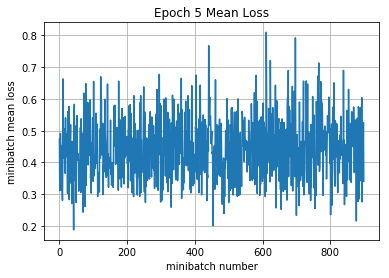

2017-10-26 11:37:59 Iter 4500: batch trn loss = 0.447, accuracy = 0.900
2017-10-26 11:38:18 Iter 4600: batch trn loss = 0.314, accuracy = 0.920
2017-10-26 11:38:40 Iter 4700: batch trn loss = 0.599, accuracy = 0.840
2017-10-26 11:39:01 Iter 4800: batch trn loss = 0.567, accuracy = 0.860
2017-10-26 11:39:21 Iter 4900: batch trn loss = 0.346, accuracy = 0.880
2017-10-26 11:39:42 Iter 5000: batch trn loss = 0.333, accuracy = 0.860
2017-10-26 11:40:03 Iter 5100: batch trn loss = 0.527, accuracy = 0.780
2017-10-26 11:40:24 Iter 5200: batch trn loss = 0.411, accuracy = 0.880
2017-10-26 11:40:44 Iter 5300: batch trn loss = 0.457, accuracy = 0.840
Epoch 5: mean loss = 0.427, accuracy = 0.872


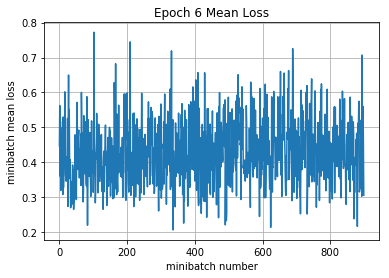

2017-10-26 11:41:05 Iter 5400: batch trn loss = 0.325, accuracy = 0.940
2017-10-26 11:41:25 Iter 5500: batch trn loss = 0.405, accuracy = 0.880
2017-10-26 11:41:47 Iter 5600: batch trn loss = 0.289, accuracy = 0.900
2017-10-26 11:42:08 Iter 5700: batch trn loss = 0.348, accuracy = 0.940
2017-10-26 11:42:29 Iter 5800: batch trn loss = 0.334, accuracy = 0.880
2017-10-26 11:42:48 Iter 5900: batch trn loss = 0.379, accuracy = 0.820
2017-10-26 11:43:08 Iter 6000: batch trn loss = 0.389, accuracy = 0.880
2017-10-26 11:43:28 Iter 6100: batch trn loss = 0.246, accuracy = 0.960
2017-10-26 11:43:48 Iter 6200: batch trn loss = 0.412, accuracy = 0.900
Epoch 6: mean loss = 0.407, accuracy = 0.880


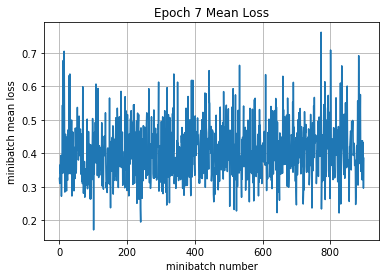

2017-10-26 11:44:09 Iter 6300: batch trn loss = 0.415, accuracy = 0.880
2017-10-26 11:44:28 Iter 6400: batch trn loss = 0.524, accuracy = 0.860
2017-10-26 11:44:50 Iter 6500: batch trn loss = 0.379, accuracy = 0.900
2017-10-26 11:45:10 Iter 6600: batch trn loss = 0.357, accuracy = 0.860
2017-10-26 11:45:29 Iter 6700: batch trn loss = 0.553, accuracy = 0.820
2017-10-26 11:45:49 Iter 6800: batch trn loss = 0.244, accuracy = 0.940
2017-10-26 11:46:09 Iter 6900: batch trn loss = 0.280, accuracy = 0.940
2017-10-26 11:46:28 Iter 7000: batch trn loss = 0.467, accuracy = 0.840
2017-10-26 11:46:48 Iter 7100: batch trn loss = 0.284, accuracy = 0.920
Epoch 7: mean loss = 0.392, accuracy = 0.887


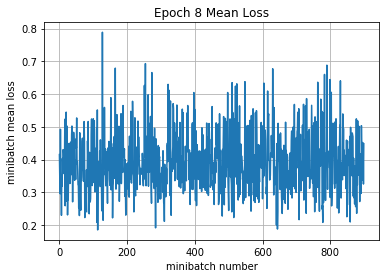

2017-10-26 11:47:09 Iter 7200: batch trn loss = 0.468, accuracy = 0.900
2017-10-26 11:47:28 Iter 7300: batch trn loss = 0.398, accuracy = 0.900
2017-10-26 11:47:48 Iter 7400: batch trn loss = 0.361, accuracy = 0.860
2017-10-26 11:48:08 Iter 7500: batch trn loss = 0.624, accuracy = 0.820
2017-10-26 11:48:28 Iter 7600: batch trn loss = 0.537, accuracy = 0.860
2017-10-26 11:48:47 Iter 7700: batch trn loss = 0.399, accuracy = 0.860
2017-10-26 11:49:07 Iter 7800: batch trn loss = 0.416, accuracy = 0.880
2017-10-26 11:49:27 Iter 7900: batch trn loss = 0.309, accuracy = 0.920
2017-10-26 11:49:46 Iter 8000: batch trn loss = 0.436, accuracy = 0.900
Epoch 8: mean loss = 0.373, accuracy = 0.895


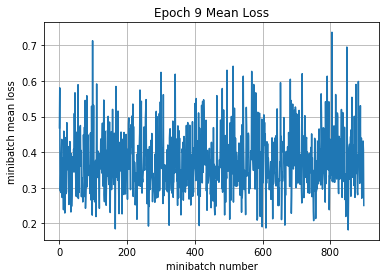

2017-10-26 11:50:06 Iter 8100: batch trn loss = 0.212, accuracy = 0.980
2017-10-26 11:50:26 Iter 8200: batch trn loss = 0.369, accuracy = 0.920
2017-10-26 11:50:46 Iter 8300: batch trn loss = 0.310, accuracy = 0.920
2017-10-26 11:51:08 Iter 8400: batch trn loss = 0.341, accuracy = 0.900
2017-10-26 11:51:28 Iter 8500: batch trn loss = 0.469, accuracy = 0.840
2017-10-26 11:51:49 Iter 8600: batch trn loss = 0.539, accuracy = 0.780
2017-10-26 11:52:09 Iter 8700: batch trn loss = 0.337, accuracy = 0.920
2017-10-26 11:52:29 Iter 8800: batch trn loss = 0.343, accuracy = 0.920
2017-10-26 11:52:49 Iter 8900: batch trn loss = 0.474, accuracy = 0.860
Epoch 9: mean loss = 0.361, accuracy = 0.899


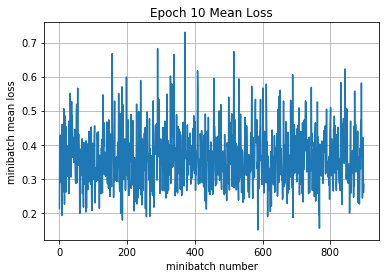

validation
Epoch 0: mean loss = 0.978, accuracy = 0.676


(0.97804356, 0.6764)

In [18]:
# 10 more epochs
print('train')
cnn.train(X_trn, y_trn, epochs=10, batch_size=50, print_every=100, plot_losses=True)
print('validation')
cnn.validate(X_val, y_val, epochs=1, batch_size=y_val.shape[0])

train
2017-10-26 11:54:00 Iter 0: batch trn loss = 0.261, accuracy = 0.960
2017-10-26 11:54:20 Iter 100: batch trn loss = 0.269, accuracy = 0.920
2017-10-26 11:54:40 Iter 200: batch trn loss = 0.433, accuracy = 0.840
2017-10-26 11:55:01 Iter 300: batch trn loss = 0.257, accuracy = 0.940
2017-10-26 11:55:21 Iter 400: batch trn loss = 0.287, accuracy = 0.920
2017-10-26 11:55:41 Iter 500: batch trn loss = 0.298, accuracy = 0.940
2017-10-26 11:56:01 Iter 600: batch trn loss = 0.355, accuracy = 0.880
2017-10-26 11:56:20 Iter 700: batch trn loss = 0.377, accuracy = 0.860
2017-10-26 11:56:40 Iter 800: batch trn loss = 0.332, accuracy = 0.880
Epoch 0: mean loss = 0.344, accuracy = 0.906


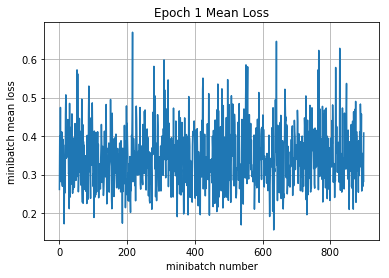

2017-10-26 11:56:59 Iter 900: batch trn loss = 0.254, accuracy = 0.960
2017-10-26 11:57:19 Iter 1000: batch trn loss = 0.390, accuracy = 0.900
2017-10-26 11:57:40 Iter 1100: batch trn loss = 0.225, accuracy = 0.960
2017-10-26 11:58:01 Iter 1200: batch trn loss = 0.305, accuracy = 0.940
2017-10-26 11:58:22 Iter 1300: batch trn loss = 0.296, accuracy = 0.920
2017-10-26 11:58:43 Iter 1400: batch trn loss = 0.212, accuracy = 0.960
2017-10-26 11:59:04 Iter 1500: batch trn loss = 0.368, accuracy = 0.940
2017-10-26 11:59:25 Iter 1600: batch trn loss = 0.316, accuracy = 0.920
2017-10-26 11:59:46 Iter 1700: batch trn loss = 0.507, accuracy = 0.860
Epoch 1: mean loss = 0.329, accuracy = 0.912


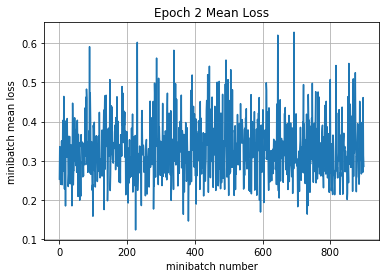

2017-10-26 12:00:07 Iter 1800: batch trn loss = 0.234, accuracy = 0.940
2017-10-26 12:00:28 Iter 1900: batch trn loss = 0.447, accuracy = 0.860
2017-10-26 12:00:48 Iter 2000: batch trn loss = 0.323, accuracy = 0.920
2017-10-26 12:01:11 Iter 2100: batch trn loss = 0.359, accuracy = 0.920
2017-10-26 12:01:30 Iter 2200: batch trn loss = 0.342, accuracy = 0.900
2017-10-26 12:01:51 Iter 2300: batch trn loss = 0.380, accuracy = 0.840
2017-10-26 12:02:13 Iter 2400: batch trn loss = 0.423, accuracy = 0.880
2017-10-26 12:02:33 Iter 2500: batch trn loss = 0.234, accuracy = 0.940
2017-10-26 12:02:53 Iter 2600: batch trn loss = 0.305, accuracy = 0.940
Epoch 2: mean loss = 0.314, accuracy = 0.917


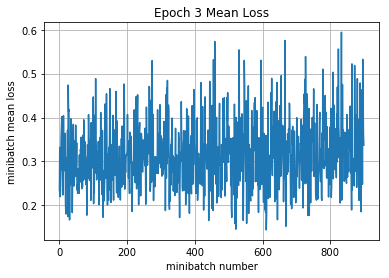

2017-10-26 12:03:13 Iter 2700: batch trn loss = 0.202, accuracy = 0.960
2017-10-26 12:03:33 Iter 2800: batch trn loss = 0.235, accuracy = 0.940
2017-10-26 12:03:52 Iter 2900: batch trn loss = 0.244, accuracy = 0.940
2017-10-26 12:04:12 Iter 3000: batch trn loss = 0.270, accuracy = 0.900
2017-10-26 12:04:31 Iter 3100: batch trn loss = 0.405, accuracy = 0.900
2017-10-26 12:04:51 Iter 3200: batch trn loss = 0.195, accuracy = 0.980
2017-10-26 12:05:10 Iter 3300: batch trn loss = 0.229, accuracy = 1.000
2017-10-26 12:05:29 Iter 3400: batch trn loss = 0.312, accuracy = 0.920
2017-10-26 12:05:49 Iter 3500: batch trn loss = 0.282, accuracy = 0.940
Epoch 3: mean loss = 0.302, accuracy = 0.922


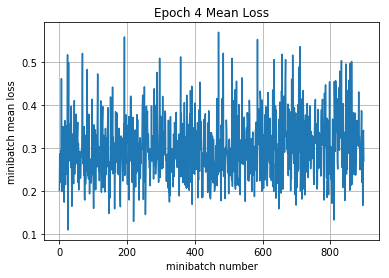

2017-10-26 12:06:08 Iter 3600: batch trn loss = 0.463, accuracy = 0.840
2017-10-26 12:06:28 Iter 3700: batch trn loss = 0.252, accuracy = 0.960
2017-10-26 12:06:47 Iter 3800: batch trn loss = 0.279, accuracy = 0.960
2017-10-26 12:07:07 Iter 3900: batch trn loss = 0.217, accuracy = 0.960
2017-10-26 12:07:26 Iter 4000: batch trn loss = 0.287, accuracy = 0.920
2017-10-26 12:07:46 Iter 4100: batch trn loss = 0.231, accuracy = 0.940
2017-10-26 12:08:05 Iter 4200: batch trn loss = 0.294, accuracy = 0.920
2017-10-26 12:08:25 Iter 4300: batch trn loss = 0.347, accuracy = 0.840
2017-10-26 12:08:44 Iter 4400: batch trn loss = 0.174, accuracy = 0.980
Epoch 4: mean loss = 0.289, accuracy = 0.926


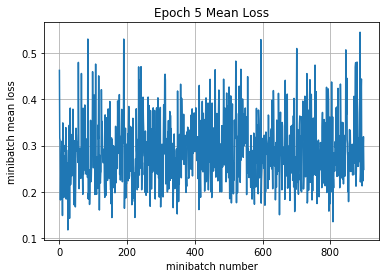

2017-10-26 12:09:04 Iter 4500: batch trn loss = 0.204, accuracy = 0.940
2017-10-26 12:09:23 Iter 4600: batch trn loss = 0.378, accuracy = 0.880
2017-10-26 12:09:42 Iter 4700: batch trn loss = 0.166, accuracy = 0.980
2017-10-26 12:10:02 Iter 4800: batch trn loss = 0.285, accuracy = 0.940
2017-10-26 12:10:21 Iter 4900: batch trn loss = 0.274, accuracy = 0.960
2017-10-26 12:10:41 Iter 5000: batch trn loss = 0.171, accuracy = 0.980
2017-10-26 12:11:00 Iter 5100: batch trn loss = 0.374, accuracy = 0.860
2017-10-26 12:11:20 Iter 5200: batch trn loss = 0.281, accuracy = 0.920
2017-10-26 12:11:39 Iter 5300: batch trn loss = 0.321, accuracy = 0.900
Epoch 5: mean loss = 0.276, accuracy = 0.932


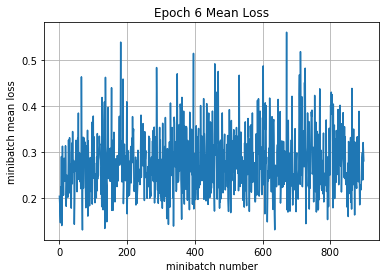

2017-10-26 12:11:59 Iter 5400: batch trn loss = 0.308, accuracy = 0.920
2017-10-26 12:12:18 Iter 5500: batch trn loss = 0.284, accuracy = 0.920
2017-10-26 12:12:38 Iter 5600: batch trn loss = 0.298, accuracy = 0.920
2017-10-26 12:12:57 Iter 5700: batch trn loss = 0.174, accuracy = 0.980
2017-10-26 12:13:16 Iter 5800: batch trn loss = 0.222, accuracy = 0.920
2017-10-26 12:13:36 Iter 5900: batch trn loss = 0.337, accuracy = 0.900
2017-10-26 12:13:55 Iter 6000: batch trn loss = 0.239, accuracy = 0.920
2017-10-26 12:14:15 Iter 6100: batch trn loss = 0.229, accuracy = 0.920
2017-10-26 12:14:34 Iter 6200: batch trn loss = 0.217, accuracy = 1.000
Epoch 6: mean loss = 0.264, accuracy = 0.937


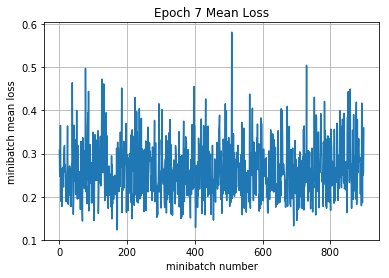

2017-10-26 12:14:54 Iter 6300: batch trn loss = 0.283, accuracy = 0.920
2017-10-26 12:15:13 Iter 6400: batch trn loss = 0.317, accuracy = 0.940
2017-10-26 12:15:33 Iter 6500: batch trn loss = 0.264, accuracy = 0.960
2017-10-26 12:15:52 Iter 6600: batch trn loss = 0.273, accuracy = 0.960
2017-10-26 12:16:12 Iter 6700: batch trn loss = 0.203, accuracy = 0.980
2017-10-26 12:16:31 Iter 6800: batch trn loss = 0.259, accuracy = 0.900
2017-10-26 12:16:51 Iter 6900: batch trn loss = 0.213, accuracy = 0.960
2017-10-26 12:17:11 Iter 7000: batch trn loss = 0.287, accuracy = 0.960
2017-10-26 12:17:31 Iter 7100: batch trn loss = 0.132, accuracy = 1.000
Epoch 7: mean loss = 0.253, accuracy = 0.941


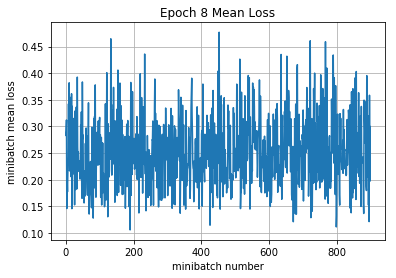

2017-10-26 12:17:51 Iter 7200: batch trn loss = 0.268, accuracy = 0.960
2017-10-26 12:18:10 Iter 7300: batch trn loss = 0.225, accuracy = 0.980
2017-10-26 12:18:30 Iter 7400: batch trn loss = 0.441, accuracy = 0.900
2017-10-26 12:18:49 Iter 7500: batch trn loss = 0.337, accuracy = 0.920
2017-10-26 12:19:08 Iter 7600: batch trn loss = 0.245, accuracy = 0.920
2017-10-26 12:19:28 Iter 7700: batch trn loss = 0.158, accuracy = 0.980
2017-10-26 12:19:47 Iter 7800: batch trn loss = 0.249, accuracy = 0.960
2017-10-26 12:20:07 Iter 7900: batch trn loss = 0.184, accuracy = 0.980
2017-10-26 12:20:26 Iter 8000: batch trn loss = 0.212, accuracy = 0.980
Epoch 8: mean loss = 0.244, accuracy = 0.945


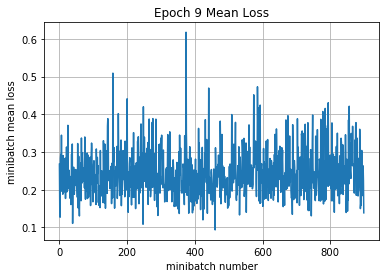

2017-10-26 12:20:46 Iter 8100: batch trn loss = 0.279, accuracy = 0.960
2017-10-26 12:21:05 Iter 8200: batch trn loss = 0.232, accuracy = 0.940
2017-10-26 12:21:25 Iter 8300: batch trn loss = 0.235, accuracy = 0.960
2017-10-26 12:21:44 Iter 8400: batch trn loss = 0.255, accuracy = 0.980
2017-10-26 12:22:04 Iter 8500: batch trn loss = 0.206, accuracy = 0.960
2017-10-26 12:22:23 Iter 8600: batch trn loss = 0.187, accuracy = 0.960
2017-10-26 12:22:43 Iter 8700: batch trn loss = 0.227, accuracy = 0.940
2017-10-26 12:23:02 Iter 8800: batch trn loss = 0.190, accuracy = 0.960
2017-10-26 12:23:21 Iter 8900: batch trn loss = 0.319, accuracy = 0.900
Epoch 9: mean loss = 0.232, accuracy = 0.948


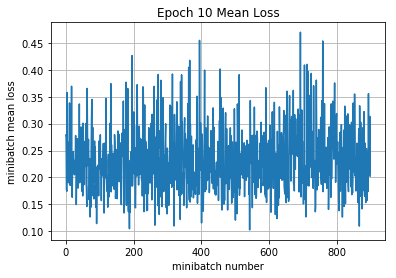

validation
Epoch 0: mean loss = 0.987, accuracy = 0.692


(0.98722869, 0.69159999999999999)

In [19]:
# 10 more epochs
print('train')
cnn.train(X_trn, y_trn, epochs=10, batch_size=50, print_every=100, plot_losses=True)
print('validation')
cnn.validate(X_val, y_val, epochs=1, batch_size=y_val.shape[0])

train
2017-10-26 14:38:58 Iter 0: batch trn loss = 0.237, accuracy = 0.900
2017-10-26 14:39:19 Iter 100: batch trn loss = 0.235, accuracy = 0.960
2017-10-26 14:39:39 Iter 200: batch trn loss = 0.154, accuracy = 0.980
2017-10-26 14:40:00 Iter 300: batch trn loss = 0.216, accuracy = 0.940
2017-10-26 14:40:22 Iter 400: batch trn loss = 0.247, accuracy = 0.900
2017-10-26 14:40:43 Iter 500: batch trn loss = 0.252, accuracy = 0.920
2017-10-26 14:41:03 Iter 600: batch trn loss = 0.191, accuracy = 0.960
2017-10-26 14:41:22 Iter 700: batch trn loss = 0.149, accuracy = 0.980
2017-10-26 14:41:41 Iter 800: batch trn loss = 0.186, accuracy = 0.940
Epoch 0: mean loss = 0.219, accuracy = 0.952


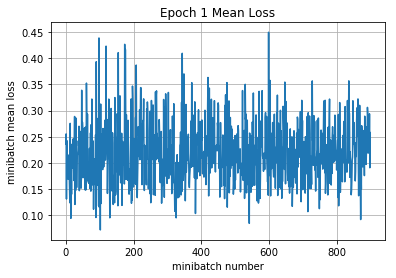

2017-10-26 14:42:01 Iter 900: batch trn loss = 0.212, accuracy = 0.940
2017-10-26 14:42:21 Iter 1000: batch trn loss = 0.233, accuracy = 0.940
2017-10-26 14:42:41 Iter 1100: batch trn loss = 0.161, accuracy = 1.000
2017-10-26 14:43:00 Iter 1200: batch trn loss = 0.185, accuracy = 0.960
2017-10-26 14:43:19 Iter 1300: batch trn loss = 0.149, accuracy = 0.980
2017-10-26 14:43:40 Iter 1400: batch trn loss = 0.123, accuracy = 1.000
2017-10-26 14:44:00 Iter 1500: batch trn loss = 0.215, accuracy = 0.920
2017-10-26 14:44:20 Iter 1600: batch trn loss = 0.253, accuracy = 0.920
2017-10-26 14:44:39 Iter 1700: batch trn loss = 0.215, accuracy = 0.980
Epoch 1: mean loss = 0.209, accuracy = 0.957


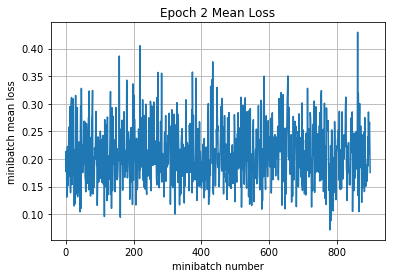

2017-10-26 14:45:01 Iter 1800: batch trn loss = 0.228, accuracy = 0.960
2017-10-26 14:45:22 Iter 1900: batch trn loss = 0.135, accuracy = 0.980
2017-10-26 14:45:43 Iter 2000: batch trn loss = 0.263, accuracy = 0.920
2017-10-26 14:46:03 Iter 2100: batch trn loss = 0.150, accuracy = 1.000
2017-10-26 14:46:23 Iter 2200: batch trn loss = 0.245, accuracy = 0.960
2017-10-26 14:46:43 Iter 2300: batch trn loss = 0.200, accuracy = 0.920
2017-10-26 14:47:03 Iter 2400: batch trn loss = 0.217, accuracy = 0.980
2017-10-26 14:47:23 Iter 2500: batch trn loss = 0.200, accuracy = 0.980
2017-10-26 14:47:43 Iter 2600: batch trn loss = 0.316, accuracy = 0.920
Epoch 2: mean loss = 0.203, accuracy = 0.959


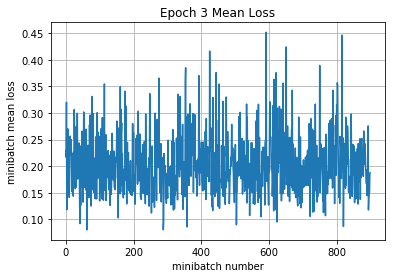

2017-10-26 14:48:04 Iter 2700: batch trn loss = 0.187, accuracy = 0.960
2017-10-26 14:48:25 Iter 2800: batch trn loss = 0.183, accuracy = 0.960
2017-10-26 14:48:46 Iter 2900: batch trn loss = 0.188, accuracy = 0.960
2017-10-26 14:49:05 Iter 3000: batch trn loss = 0.218, accuracy = 0.960
2017-10-26 14:49:25 Iter 3100: batch trn loss = 0.234, accuracy = 0.900
2017-10-26 14:49:44 Iter 3200: batch trn loss = 0.220, accuracy = 0.940
2017-10-26 14:50:03 Iter 3300: batch trn loss = 0.096, accuracy = 1.000
2017-10-26 14:50:24 Iter 3400: batch trn loss = 0.234, accuracy = 0.940
2017-10-26 14:50:43 Iter 3500: batch trn loss = 0.312, accuracy = 0.880
Epoch 3: mean loss = 0.194, accuracy = 0.961


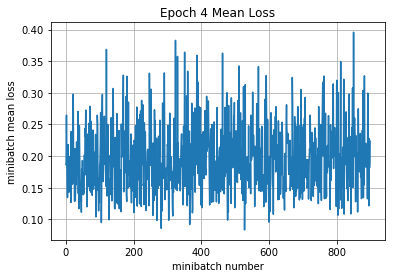

2017-10-26 14:51:03 Iter 3600: batch trn loss = 0.214, accuracy = 0.980
2017-10-26 14:51:23 Iter 3700: batch trn loss = 0.139, accuracy = 0.980
2017-10-26 14:51:42 Iter 3800: batch trn loss = 0.206, accuracy = 0.960
2017-10-26 14:52:02 Iter 3900: batch trn loss = 0.207, accuracy = 0.940
2017-10-26 14:52:22 Iter 4000: batch trn loss = 0.160, accuracy = 0.980
2017-10-26 14:52:41 Iter 4100: batch trn loss = 0.226, accuracy = 0.920
2017-10-26 14:53:01 Iter 4200: batch trn loss = 0.220, accuracy = 0.980
2017-10-26 14:53:23 Iter 4300: batch trn loss = 0.156, accuracy = 0.940
2017-10-26 14:53:43 Iter 4400: batch trn loss = 0.200, accuracy = 0.960
Epoch 4: mean loss = 0.186, accuracy = 0.964


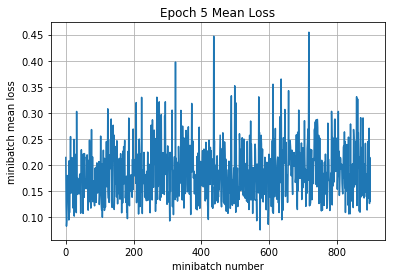

2017-10-26 14:54:03 Iter 4500: batch trn loss = 0.111, accuracy = 1.000
2017-10-26 14:54:23 Iter 4600: batch trn loss = 0.176, accuracy = 0.960
2017-10-26 14:54:43 Iter 4700: batch trn loss = 0.295, accuracy = 0.920
2017-10-26 14:55:02 Iter 4800: batch trn loss = 0.149, accuracy = 0.980
2017-10-26 14:55:22 Iter 4900: batch trn loss = 0.202, accuracy = 0.980
2017-10-26 14:55:41 Iter 5000: batch trn loss = 0.173, accuracy = 0.960
2017-10-26 14:56:01 Iter 5100: batch trn loss = 0.191, accuracy = 0.940
2017-10-26 14:56:22 Iter 5200: batch trn loss = 0.147, accuracy = 1.000
2017-10-26 14:56:41 Iter 5300: batch trn loss = 0.115, accuracy = 1.000
Epoch 5: mean loss = 0.176, accuracy = 0.968


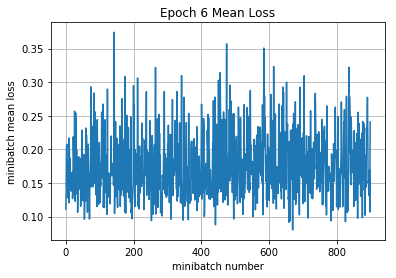

2017-10-26 14:57:02 Iter 5400: batch trn loss = 0.126, accuracy = 1.000
2017-10-26 14:57:21 Iter 5500: batch trn loss = 0.143, accuracy = 0.980
2017-10-26 14:57:41 Iter 5600: batch trn loss = 0.079, accuracy = 1.000
2017-10-26 14:58:02 Iter 5700: batch trn loss = 0.151, accuracy = 0.980
2017-10-26 14:58:21 Iter 5800: batch trn loss = 0.184, accuracy = 0.980
2017-10-26 14:58:42 Iter 5900: batch trn loss = 0.156, accuracy = 0.960
2017-10-26 14:59:03 Iter 6000: batch trn loss = 0.137, accuracy = 0.980
2017-10-26 14:59:24 Iter 6100: batch trn loss = 0.147, accuracy = 0.960
2017-10-26 14:59:43 Iter 6200: batch trn loss = 0.148, accuracy = 0.980
Epoch 6: mean loss = 0.169, accuracy = 0.970


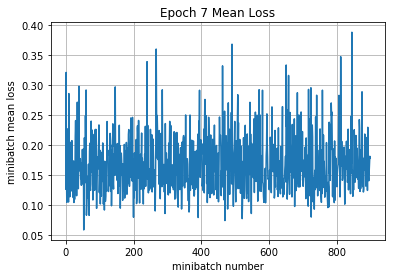

2017-10-26 15:00:03 Iter 6300: batch trn loss = 0.160, accuracy = 1.000
2017-10-26 15:00:22 Iter 6400: batch trn loss = 0.214, accuracy = 0.980
2017-10-26 15:00:43 Iter 6500: batch trn loss = 0.225, accuracy = 0.960
2017-10-26 15:01:03 Iter 6600: batch trn loss = 0.172, accuracy = 0.980
2017-10-26 15:01:22 Iter 6700: batch trn loss = 0.115, accuracy = 1.000
2017-10-26 15:01:42 Iter 6800: batch trn loss = 0.133, accuracy = 1.000
2017-10-26 15:02:01 Iter 6900: batch trn loss = 0.157, accuracy = 0.980
2017-10-26 15:02:22 Iter 7000: batch trn loss = 0.187, accuracy = 1.000
2017-10-26 15:02:41 Iter 7100: batch trn loss = 0.221, accuracy = 0.920
Epoch 7: mean loss = 0.165, accuracy = 0.970


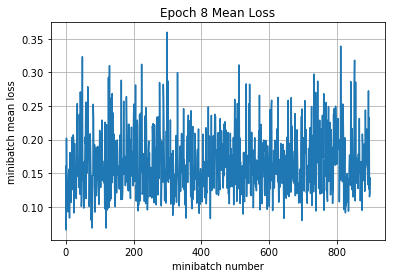

2017-10-26 15:03:01 Iter 7200: batch trn loss = 0.173, accuracy = 0.940
2017-10-26 15:03:20 Iter 7300: batch trn loss = 0.151, accuracy = 0.960
2017-10-26 15:03:39 Iter 7400: batch trn loss = 0.233, accuracy = 0.940
2017-10-26 15:04:00 Iter 7500: batch trn loss = 0.177, accuracy = 0.980
2017-10-26 15:04:19 Iter 7600: batch trn loss = 0.165, accuracy = 1.000
2017-10-26 15:04:38 Iter 7700: batch trn loss = 0.176, accuracy = 0.960
2017-10-26 15:04:58 Iter 7800: batch trn loss = 0.146, accuracy = 0.980
2017-10-26 15:05:17 Iter 7900: batch trn loss = 0.198, accuracy = 0.920
2017-10-26 15:05:37 Iter 8000: batch trn loss = 0.139, accuracy = 0.980
Epoch 8: mean loss = 0.157, accuracy = 0.973


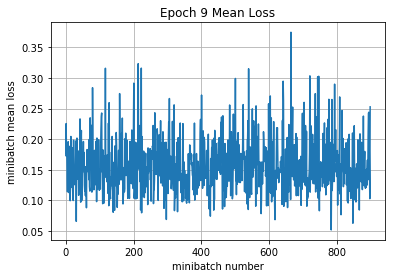

2017-10-26 15:05:57 Iter 8100: batch trn loss = 0.160, accuracy = 0.980
2017-10-26 15:06:16 Iter 8200: batch trn loss = 0.103, accuracy = 0.980
2017-10-26 15:06:35 Iter 8300: batch trn loss = 0.114, accuracy = 1.000
2017-10-26 15:06:55 Iter 8400: batch trn loss = 0.120, accuracy = 1.000
2017-10-26 15:07:15 Iter 8500: batch trn loss = 0.159, accuracy = 0.980
2017-10-26 15:07:34 Iter 8600: batch trn loss = 0.113, accuracy = 0.980
2017-10-26 15:07:54 Iter 8700: batch trn loss = 0.169, accuracy = 0.920
2017-10-26 15:08:13 Iter 8800: batch trn loss = 0.086, accuracy = 1.000
2017-10-26 15:08:33 Iter 8900: batch trn loss = 0.077, accuracy = 1.000
Epoch 9: mean loss = 0.148, accuracy = 0.976


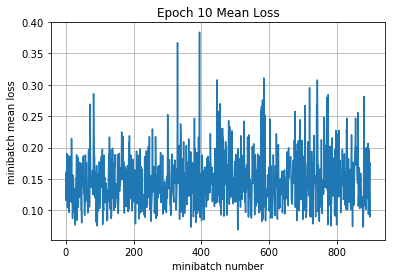

validation
Epoch 0: mean loss = 1.027, accuracy = 0.686


(1.0273317, 0.68579999999999997)

In [20]:
# 10 more epochs
print('train')
cnn.train(X_trn, y_trn, epochs=10, batch_size=50, print_every=100, plot_losses=True)
print('validation')
cnn.validate(X_val, y_val, epochs=1, batch_size=y_val.shape[0])

## [10/26] [0011] stronger l2 regularization with reg_scale=1
- base (0010)
- trn: ,val:

In [ ]:
def model_fn(layer_input, labels, is_training):
    reg_scale= 1
    regularizer = tf.contrib.layers.l2_regularizer(scale=reg_scale)
    # conv - bn - max_pool
    F1 = 32
    layer = tf.layers.conv2d(inputs=layer_input, filters=F1, kernel_size=[5, 5], padding='same', activation=tf.nn.relu,
                             kernel_regularizer=regularizer)
    layer = tf.layers.batch_normalization(inputs=layer, training=is_training,
                                          beta_regularizer=regularizer, gamma_regularizer=regularizer)
    layer = tf.layers.max_pooling2d(inputs=layer, pool_size=[2, 2], strides=2)
    # conv - bn - max_pool
    F2 = 64
    layer = tf.layers.conv2d(inputs=layer, filters=F2, kernel_size=[5, 5], padding='same', activation=tf.nn.relu,
                             kernel_regularizer=regularizer)
    layer = tf.layers.batch_normalization(inputs=layer, training=is_training,
                                          beta_regularizer=regularizer, gamma_regularizer=regularizer)
    layer = tf.layers.max_pooling2d(inputs=layer, pool_size=[2, 2], strides=2)
    # dense1 - bn - softmax
    flat_size = int(H / 4 * W / 4 * F2)
    print(flat_size)
    layer = tf.reshape(layer, [-1, flat_size])
    layer = tf.layers.dense(inputs=layer, units=1024, activation=tf.nn.relu,
                            kernel_regularizer=regularizer)
    layer = tf.layers.batch_normalization(inputs=layer, training=is_training,
                                          beta_regularizer=regularizer, gamma_regularizer=regularizer)
    # layer_dropout = tf.layers.dropout(inputs=layer_dense, rate=0.4)
    # no activation here for logit, as it will be calculated in loss
    logit = tf.layers.dense(inputs=layer, units=T, activation=None,
                            kernel_regularizer=regularizer)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int64), depth=10)
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=logit)
    return logit, loss

trainer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
cnn = CNN(model_fn, trainer)
print('train')
cnn.train(X_trn, y_trn, epochs=20, batch_size=50, print_every=100, plot_losses=True)
print('validation')
cnn.validate(X_val, y_val, epochs=1, batch_size=y_val.shape[0])

## Part 2: improve the performance and generalization of the Convolutional Neural Network
#### Add dropout and L2 regularization